In [1]:

from prompts import *
from config import Config
import os
import tiktoken, random
import numpy as np

config = Config()


# Prompt

In [3]:
# 相对排名评价response, 给出response_1, response_2的相对好坏
pair_eval_prompt = '''
You are a fair assessment expert in the area of Chinese Literature Teaching. You will be given one question-answer pair along with 2 different responses. Your task is to decide which response is better. You should take into consideration the accuracy, coherence, factuality, and comprehensiveness of the responses to reach a judgment. 
The position of responses is randomly assigned and has no preference.
Only return: “Response 1” or “Response 2”. You DO NOT need to explain the reason. 
Question: {Question}
Answer: {Answer}
Response 1: {Response_1}
Response 2: {Response_2}
Think step by step:
'''

# 去中心化的专家组评估, 绝对分数
eva_exp_sys = '''
You are a talent Chinese language teacher with a deep understanding of literature teaching. You give accurate evaluations of teaching records.
'''

eva_exp_prompt = '''
Given a teaching record, please evaluate the teacher's performance on the following aspects:
1. Overall teaching effectiveness
2. Knowledge and understanding of the subject
3. Communication skills
4. Ability to motivate and engage students

teaching record: {teaching_record}.

Give rating score ONLY (0-5, with each 0.2 increment representing a different rating level):
'''


# teacher_sys = '''
# 你是一位深谙语文教学之道的中国语文教育专家,精通阅读理解、文学分析和写作技巧。
# 你熟悉各种文学流派、写作风格和修辞技巧,擅长设计与“整本书阅读”相关的语文教学活动和讨论话题。
# 你能够引导学生深入探索文本的主题、象征和深层含义。具有丰富的教学经验,能够设计吸引人的开放性问题。
# '''

# single teacher system prompt
teacher_sys = '''
You are a talented Chinese language teacher with a deep understanding of literature teaching.
'''
# You are a good communicator and have a good understanding of the importance of effective communication in teaching.
# You have a strong grasp of literary theory and have a good understanding of the role of literature in education.
# You are a natural leader and have a good understanding of the role of leadership in education.



# 单教师智能体prompt：生成response 


# 综合所有teacher对question的修改意见
teacher_question_gather_prompt = '''
##### 设定 #####
<对话主题>:{topic}.
<学生发言>:{student_responses}.
<待修改文本>:{response_sentence}.
<专家意见>:{expert_refine}.

##### 要求 #####
基于自己的专业知识,遵循以下要求,整合多份<专家意见>,对<待修改文本>做出最终修改:
0. **你不能回答<待修改文本>中的问题**,否则将受到惩罚。
1. 仔细、全面地评估每一份<专家意见>,特别注意不同专家之间可能存在的差异和矛盾。
2. 基于<专家意见>,对<待修改文本>进行全面总结的分析和必要的修改润色,以确保内容的**语言亲和性**、教育性和专业深度。
3. 在修改过程中保留<待修改文本>的核心信息和教育目标,确保整合后的文本忠实于原始主题和意图。
4. 必须符合五年级中国小学生的认知水平和词汇量,避免采用抽象词汇和高级概念。
5. 使用活泼生动的小学生语言风格。
6. 整合方案保持简练,只问**一个**问题,不能超出<待修改文本>过长。

##### 输出 #####
<整合后文本>:
'''

# 第一个学生角色是
# gender: boy
# char1: 0
# char2: 2
# You are living in Haidian, Beijing, China.
# You also enjoy building things, from simple gadgets to complex Lego structures, which you proudly display in your room. 
# This hobby not only feeds your creativity but also your curiosity about how things work.
# Drawing maps and creating stories about imaginary places are among your favorite activities. 
# You often spend your evenings sketching out new worlds in your notebooks, inspired by the adventures of Tintin.
# You speak Chinese at home and with your friends, and you sometimes write your own adventure stories in Chinese, imagining yourself exploring ancient Chinese landmarks or discovering hidden treasures in your city.
# Your daily life is filled with the joy of learning new things, whether it's through reading, exploring, building, or storytelling. 
# You cherish the moments you spend with your family and friends, sharing stories and dreams about your next adventure.

# 第二个学生是
# gender: girl
# char1: 3
# char2: 7
# YOU live in Sanya City, Hainan Province, China.
# YOU enjoy spending time at the beach, collecting seashells, and building sandcastles with your friends.
# YOU often ride your bicycle along the palm tree-lined streets of your neighborhood.
# YOU like to read adventure books and imagine yourself on exciting journeys like Robinson Crusoe.
# YOU are always coming up with new stories and ideas, using your creativity to make your everyday life more interesting.

# 生成问题

In [ ]:
import re
with open('answers.txt', 'r', encoding='utf-8') as f:
    answers = re.split(r'\d+ ', ''.join(f.readlines()))[1:]
print('number of answers:', len(answers))

# 导入"问题-回答"pair(new)

In [ ]:
with open('./questions_new.txt', 'r', encoding='utf-8') as f:
    questions = f.readlines()
questions = [ques.split(' ')[1].split('\n')[0] for ques in questions]

with open('./answers_new.txt', 'r', encoding='utf-8') as f:
    answers = f.readlines()
answers = [answer.split(' ')[1] for answer in answers]


Q_A_new = {}
for i, ques in enumerate(questions):
    Q_A_new[ques] = [[answers[i], list(Q_A.values())[i][0][1]], list(Q_A.values())[i][1]]
with open('Q_A_new.json', 'w', encoding='utf-8') as f:
    # 使用json.dump()将字典写入文件
    json.dump(Q_A_new, f, ensure_ascii=False, indent=4)

In [ ]:
import json
with open('./generated_data/Q_A_new.json', 'r', encoding='utf-8') as f:
    Q_A = json.load(f)
questions = list(Q_A.keys())

print('导入学生1的回答')
answers = [Q_A[item][0] for item in Q_A] # answers from student #1

# print('导入学生2的回答')
# answers = [Q_A[item][1] for item in Q_A] # answers from student #2

print('number of questions:', len(questions))
print('number of answers:', len(answers))

#### 保存用于evaluation的问题-回答对

In [38]:
import json, re
with open('./generated_data/eval_ques.txt', 'r', encoding='utf-8') as f:
    questions = f.readlines()
with open('./generated_data/eval_ans.txt', 'r', encoding='utf-8') as f:
    answers = re.split(r'\d+\s', ''.join(f.readlines()))[1:]
Q_A_eval = {}
for i, (ques, ans) in enumerate(zip(questions, answers)):
    Q_A_eval[ques] = [ans]
with open('./generated_data/Q_A_eval.json', 'w', encoding='utf-8') as f:
    json.dump(Q_A_eval, f, ensure_ascii=False, indent=4)

#### 读取evaluation question-answer pairs

In [4]:
import json
with open('./generated_data/Q_A_eval.json', 'r', encoding='utf-8') as f:
    Q_A_eval = json.load(f)
questions = list(Q_A_eval.keys())
answers = [Q_A_eval[item][0] for item in Q_A_eval] # answers from student #1
print('number of evaluation questions:', len(questions))
print('number of evaluation answers:', len(answers))

number of evaluation questions: 136
number of evaluation answers: 136


# Rewriting Query and RRF

# 2024.5.3
### Group-reflection + Query-rewriting for Evaluation

In [17]:
empty_list = [75, 114, 120, 126, 128,]
for i, ques, ans in zip(empty_list, [questions[i] for i in empty_list], [answers[i] for i in empty_list]):
# for i, (ques, ans) in enumerate(zip(questions, answers)):
    reranked_results = rewritings_rrf(
        query=ans,
        HS_V=np.ones((42041)),
        model_name='gpt-4-turbo-preview',  # glm-4
        )
    
    # 7专家累计
    cumulative_decisions = np.zeros((len(reranked_results)))
    for field in fields_7:
        decisions = group_reflection_qwen(ques, ans, reranked_results, field)
        for j, label in enumerate(decisions):
            if 'Yes' in label or 'YES' in label or 'yes' in label:
                cumulative_decisions[j] += 1
    cumulative_decisions /= len(fields_7)
    
    references = [list(reranked_results.keys())[j] for j, label in enumerate(cumulative_decisions) if label >= 0.0]
    # for j, label in enumerate(cumulative_decisions):
    #     if label >= 0.5:
    #         references.append()
    if len(references) >= 3:
        for j, ref in enumerate(random.sample(references, 3)):
            print('here')
            # analysis = glm4_client.chat.completions.create(
            #     model='glm-4',
            #     messages=[
            #         {"role": "system", "content": teacher_sys},
            #         {"role": "user", "content": teacher_analyze_ref_prompt.format(
            #             question=ques,
            #             answer=ans[0],
            #             reference=ref,)}
            #     ]
            # )
            
            # response = glm4_client.chat.completions.create(
            #     model='glm-4', # gpt-4-turbo-preview
            #     messages=[
            #         {"role": "system", "content": teacher_sys},
            #         {"role": "user", "content": teacher_response_prompt.format(
            #             question=ques,
            #             answer=ans[0],
            #             reference=ref+'\n'+analysis.choices[0].message.content)},
            #         ]
            #     )
            # print(i, j, response.choices[0].message.content)
            
            _, ref_index = get_retrieval_index(split_docs, ref)
            
            # analysis = qwen_client.completion(
            #     prompt=teacher_analyze_ref_prompt.format(
            #         question=ques,
            #         answer=ans[0],
            #         reference=ref,),
            #     system_prompt=teacher_sys,
            # )
            
            # response = qwen_client.completion(
            #     prompt=teacher_analyze_ref_prompt.format(
            #         question=ques,
            #         answer=ans[0],
            #         reference=ref+'\n'+analysis,),
            #     system_prompt=teacher_sys,
            #     )
            
            analysis = openai_client.chat.completions.create(
                model='gpt-4-turbo-preview', # gpt-3.5-turbo
                messages=[
                    {"role": "system", "content": teacher_sys},
                    {"role": "user", "content": teacher_analyze_ref_prompt.format(
                        question=ques,
                        answer=ans,
                        reference=ref,
                        )}
                    ]
                )
            response = openai_client.chat.completions.create(
                model='gpt-4-turbo-preview', # gpt-3.5-turbo
                messages=[
                    {"role": "system", "content": teacher_sys},
                    {"role": "user", "content": teacher_response_prompt.format(
                        question=ques,
                        answer=ans,
                        reference=ref+'\n'+analysis.choices[0].message.content)
                     },
                    ]
                )
            print(i, j)
            with open('./generated_data/eval_positive_new.txt', 'a', encoding='utf-8') as f:
                f.write(f'{i}, {j}, ref_index: {ref_index}, analysis: {analysis.choices[0].message.content}, response: {response.choices[0].message.content}\n')
            # print(i, j, 'ref_index:', ref_index, 'analysis:', analysis.choices[0].message.content, 'response:', response.choices[0].message.content)
            
    else:
        print(i, 'not enough references')
        with open('./generated_data/eval_positive_new.txt', 'a', encoding='utf-8') as f:
            f.write(f'{i}, not enough references\n')

  0%|          | 0/20 [00:00<?, ?it/s]d:\programs\miniconda3\envs\llm\Lib\site-packages\transformers\models\qwen2\modeling_qwen2.py:693: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


['No.', 'No.', 'No.', 'No', 'No.', 'No.', 'No.', 'No', 'No.', 'No.', 'No', 'No.', 'No.', 'No', 'No.', 'No.', 'No.', 'No.', 'No.', 'No.']


100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


['No.', 'No.', 'No.', 'No', 'No.', 'No', 'No.', 'No', 'No.', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No.', 'No.', 'No.', 'No']


100%|██████████| 20/20 [00:01<00:00, 10.38it/s]


['No.', 'No', 'No.', 'Yes', 'No.', 'No.', 'No', 'No', 'No.', 'No.', 'No', 'No', 'No.', 'No', 'No', 'No', 'Yes', 'No.', 'No', 'No']


100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


['No.', 'No.', 'No.', 'Yes', 'No.', 'No.', 'No.', 'No.', 'No', 'No.', 'No', 'No.', 'No.', 'No', 'No.', 'No.', 'No.', 'No', 'No.', 'No']


100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


['No.', 'No.', 'No.', 'No.', 'No', 'No', 'No', 'No', 'No.', 'No.', 'No.', 'No', 'No.', 'No', 'No.', 'No', 'No.', 'No.', 'No', 'No']


100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


['No', 'No.', 'No.', 'No.', 'No.', 'No', 'No.', 'No', 'No.', 'No.', 'No', 'No.', 'No', 'No.', 'No', 'No', 'No', 'No.', 'No', 'No']


100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


['No', 'No.', 'No.', 'no', 'No.', 'No.', 'No.', 'No', 'No.', 'No.', 'No.', 'No', 'No', 'No.', 'No', 'No.', 'No.', 'No.', 'No', 'No']
here
75 0
here
75 1
here
75 2


100%|██████████| 19/19 [00:01<00:00,  9.63it/s]


['No', 'No.', 'No.', 'No.', 'No.', 'No', 'No', 'No', 'No', 'No', 'No', 'No.', 'No', 'Yes.', 'No', 'No', 'No', 'No.', 'No']


100%|██████████| 19/19 [00:02<00:00,  9.43it/s]


['No.', 'No', 'No', 'No.', 'No', 'Yes', 'No.', 'No', 'No.', 'No', 'No', 'No.', 'No', 'No', 'No', 'No', 'No', 'No', 'No.']


100%|██████████| 19/19 [00:01<00:00, 10.03it/s]


['No', 'No', 'No', 'No', 'No', 'No', 'No', 'no', 'No', 'No', 'no', 'No', 'no', 'No', 'No', 'No.', 'No', 'No', 'No']


100%|██████████| 19/19 [00:01<00:00, 10.69it/s]


['no', 'No', 'no', 'No', 'No.', 'No', 'No', 'No', 'No', 'Yes', 'no', 'No', 'No', 'no', 'no', 'No', 'No', 'no', 'No']


100%|██████████| 19/19 [00:01<00:00, 10.33it/s]


['No.', 'no', 'No', 'No', 'no', 'No.', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'no', 'No.', 'No', 'No', 'No', 'no']


100%|██████████| 19/19 [00:01<00:00, 10.48it/s]


['No', 'no', 'no', 'No.', 'No', 'no', 'No', 'No', 'no', 'No', 'No', 'No', 'No', 'No', 'no', 'No.', 'No', 'No', 'no']


100%|██████████| 19/19 [00:01<00:00, 10.07it/s]


['No', 'No.', 'No', 'No.', 'No.', 'no', 'no', 'no', 'no', 'No', 'No', 'No', 'No', 'No.', 'No', 'No', 'No', 'No', 'No']
here
114 0
here
114 1
here
114 2


100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


['No', 'No.', 'No', 'No', 'No.', 'No.', 'No.', 'No.', 'No.', 'No.', 'No.', 'No.', 'No', 'No', 'No', 'No', 'No.', 'No', 'No.', 'No']


100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


['No.', 'No.', 'No', 'No.', 'No', 'No', 'No.', 'No', 'No.', 'No.', 'No', 'No.', 'No.', 'No', 'No', 'No.', 'No.', 'No.', 'No.', 'No.']


100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


['No.', 'No.', 'No', 'No', 'No', 'No.', 'No.', 'No.', 'No.', 'No.', 'No.', 'No', 'No', 'No', 'No.', 'No', 'No.', 'No', 'No', 'No']


100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


['No.', 'no', 'No', 'No', 'No', 'No.', 'No', 'No', 'No.', 'No', 'No', 'No', 'No', 'No', 'No', 'no', 'no', 'No', 'No.', 'No.']


100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


['No.', 'No', 'No.', 'No', 'No', 'No', 'No', 'No.', 'No', 'No', 'No', 'No', 'No', 'No.', 'No.', 'No', 'No.', 'No', 'No.', 'No.']


100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


['No', 'No', 'No', 'No.', 'No', 'No', 'No.', 'No', 'No.', 'No', 'No.', 'No', 'No.', 'No', 'No.', 'No', 'No.', 'No', 'No.', 'No']


100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


['No.', 'No', 'No', 'No', 'No.', 'No.', 'No.', 'No.', 'No', 'No.', 'No.', 'No', 'No', 'No', 'No', 'No', 'No.', 'No.', 'No', 'No']
here
120 0
here
120 1
here
120 2


100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


['No.', 'No', 'No', 'No', 'no', 'No', 'No', 'No', 'No.', 'No', 'No.', 'No', 'No', 'No.', 'No', 'No', 'No.', 'No.', 'No', 'No']


100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


['No', 'No', 'No.', 'No', 'No', 'No', 'No', 'No.', 'No.', 'No.', 'No', 'No', 'No', 'No', 'No.', 'No.', 'No', 'No.', 'No.', 'No']


100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


['No', 'No', 'No', 'no', 'No', 'No', 'No.', 'no', 'No', 'No', 'No.', 'No', 'No.', 'No', 'No', 'No', 'No', 'No.', 'No', 'No']


100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


['no', 'no', 'No', 'No.', 'No', 'No', 'No', 'No.', 'No', 'No', 'No', 'No', 'No', 'No.', 'No', 'no', 'No', 'No.', 'No', 'No.']


100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


['No.', 'No', 'No', 'No', 'No', 'Yes', 'no', 'No', 'No', 'No', 'No.', 'No', 'No', 'No', 'No', 'no', 'No.', 'No', 'No.', 'No']


100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


['No', 'No.', 'No', 'no', 'No', 'No', 'No', 'No', 'No.', 'No.', 'No.', 'No', 'Yes.', 'No.', 'No', 'no', 'No.', 'No', 'No', 'No.']


100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


['No.', 'No.', 'no', 'no', 'No', 'no', 'No', 'No', 'No.', 'No', 'No', 'No.', 'No', 'no', 'No.', 'no', 'no', 'No.', 'No.', 'No']
here
126 0
here
126 1
here
126 2


100%|██████████| 18/18 [00:02<00:00,  8.76it/s]


['No.', 'No', 'No', 'No.', 'No.', 'No', 'No', 'No.', 'No.', 'No.', 'No', 'No', 'No', 'No.', 'No', 'No', 'Yes.', 'no']


100%|██████████| 18/18 [00:01<00:00, 10.09it/s]


['No', 'No', 'No', 'No', 'No', 'No.', 'No.', 'No', 'No.', 'No', 'No', 'No.', 'No', 'No', 'No', 'No', 'Yes', 'no']


100%|██████████| 18/18 [00:01<00:00,  9.52it/s]


['no', 'No.', 'no', 'No', 'No', 'no', 'no', 'No.', 'No.', 'No.', 'no', 'No', 'No', 'No', 'No', 'No.', 'Yes.', 'No.']


100%|██████████| 18/18 [00:01<00:00,  9.43it/s]


['No', 'No', 'no', 'No', 'No.', 'No', 'No.', 'No', 'No', 'Yes.', 'no', 'no', 'No', 'No.', 'No', 'No', 'No', 'No.']


100%|██████████| 18/18 [00:01<00:00,  9.97it/s]


['No.', 'No.', 'No', 'No', 'No.', 'no', 'No', 'No', 'no', 'No', 'No', 'No', 'No', 'No', 'No', 'no', 'Yes', 'No']


100%|██████████| 18/18 [00:01<00:00,  9.53it/s]


['No.', 'No', 'No', 'No', 'No', 'no', 'No.', 'No', 'No.', 'No', 'No', 'No', 'No.', 'No', 'No', 'No', 'No', 'no']


100%|██████████| 18/18 [00:01<00:00, 10.17it/s]


['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No.', 'No.', 'No.', 'No', 'No', 'No', 'No', 'no']
here
128 0
here
128 1
here
128 2


# 2024.4.10

## Group-reflection + Query-rewriting + Multi-Teacher response generation

In [ ]:
empty_list = [29, 32, 37, 45, 46, 50, 64, 153, 164, 199, 225, 288, 312, 324, 331, 342, 354, 377, 387, 394, 429, 432, 437, 442, 453, 468, 478, 480, 484, 496, 497]
print(len(empty_list))

31


In [ ]:

for i, ques, ans in zip(empty_list, [questions[i] for i in empty_list], [answers[i] for i in empty_list]):
# for i, (ques, ans) in enumerate(zip(questions[30:], answers[30:])):
    reranked_results = rewritings_rrf(
        query=ans[0],
        HS_V=np.ones((42041)),
        model_name='glm-4',
        )
    
    # 7专家累计
    cumulative_decisions = np.zeros((len(reranked_results)))
    for field in fields_7:
        decisions = group_reflection_gpt(ques, ans[0], reranked_results, field)
        for j, label in enumerate(decisions):
            if 'Yes' in label or 'YES' in label or 'yes' in label:
                cumulative_decisions[j] += 1
    cumulative_decisions /= len(fields_7)
    
    references = [list(reranked_results.keys())[j] for j, label in enumerate(cumulative_decisions) if label >= 0.05]
    # for j, label in enumerate(cumulative_decisions):
    #     if label >= 0.5:
    #         references.append()
    if len(references) >= 3:
        for j, ref in enumerate(random.sample(references, 3)):
            # analysis = glm4_client.chat.completions.create(
            #     model='glm-4',
            #     messages=[
            #         {"role": "system", "content": teacher_sys},
            #         {"role": "user", "content": teacher_analyze_ref_prompt.format(
            #             question=ques,
            #             answer=ans[0],
            #             reference=ref,)}
            #     ]
            # )
            
            # response = glm4_client.chat.completions.create(
            #     model='glm-4', # gpt-4-turbo-preview
            #     messages=[
            #         {"role": "system", "content": teacher_sys},
            #         {"role": "user", "content": teacher_response_prompt.format(
            #             question=ques,
            #             answer=ans[0],
            #             reference=ref+'\n'+analysis.choices[0].message.content)},
            #         ]
            #     )
            # print(i, j, response.choices[0].message.content)
            
            _, ref_index = get_retrieval_index(split_docs, ref)
            
            # analysis = qwen_client.completion(
            #     prompt=teacher_analyze_ref_prompt.format(
            #         question=ques,
            #         answer=ans[0],
            #         reference=ref,),
            #     system_prompt=teacher_sys,
            # )
            
            # response = qwen_client.completion(
            #     prompt=teacher_analyze_ref_prompt.format(
            #         question=ques,
            #         answer=ans[0],
            #         reference=ref+'\n'+analysis,),
            #     system_prompt=teacher_sys,
            #     )
            
            analysis = openai_client.chat.completions.create(
                model='gpt-3.5-turbo',
                messages=[
                    {"role": "system", "content": teacher_sys},
                    {"role": "user", "content": teacher_analyze_ref_prompt.format(
                        question=ques,
                        answer=ans[0],
                        reference=ref,
                        )}
                    ]
                )
            response = openai_client.chat.completions.create(
                model='gpt-3.5-turbo',
                messages=[
                    {"role": "system", "content": teacher_sys},
                    {"role": "user", "content": teacher_response_prompt.format(
                        question=ques,
                        answer=ans[0],
                        reference=ref+'\n'+analysis.choices[0].message.content)
                     },
                    ]
                )
            print(i, j)
            with open('./generated_data/positive.txt', 'a', encoding='utf-8') as f:
                f.write(f'{i}, {j}, ref_index: {ref_index}, analysis: {analysis.choices[0].message.content}, response: {response.choices[0].message.content}\n')
            # print(i, j, 'ref_index:', ref_index, 'analysis:', analysis.choices[0].message.content, 'response:', response.choices[0].message.content)
            
            
            
            
    else:
        print(i, 'not enough references')
        with open('./generated_data/positive.txt', 'a', encoding='utf-8') as f:
            f.write(f'{i}, not enough references\n')

100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


['Does the document provide exact information in the field of teaching language style to help generate a response?', 'Is the provided document helpful for generating a response about teaching language style in the field of literature?\n- No', 'No.', 'Does the document contain exact information related to teaching language style in the field of literature to help generate a response for the given question-answer pair?', 'Based on the provided Question-Answer pair and Document, does the Document have exact information in the field of teaching language style to help generate a response?', 'Does the document have exact information in the field of teaching language style to help generate a response?\n- No', 'Yes', 'Does the document contain exact information to help generate a response for teaching language style in this context?', 'No', 'No', 'The provided document does not have exact information in the field of teaching language style to help generate a response.', 'No', 'No', 'Does the p

100%|██████████| 19/19 [00:13<00:00,  1.45it/s]


['No', 'Yes', 'No', 'Step 1: Does the document contain information about teaching students how to use vivid and lively language to describe a scene or scenario?\n`No`', 'Yes', 'Yes', 'No', 'Does the document have exact information in the field of teaching language style to help generate a response?', 'Does the document have exact information in the field of teaching language style to help generate a response?', 'No.', '1. Is the provided document related to teaching language styles or techniques in literature?  \nNo.  \n2. Does the document contain exact information in the field of teaching language style to help generate a response to the question-answer pair provided?  \nNo.', 'No', 'No', 'Yes', 'Is the content in the document relevant to teaching language style in the field of literature?', '1. Does the document provide exact information on teaching language style related to the given question?  \nNo', 'No', 'No', 'Does the document have exact information in the field of teaching la

100%|██████████| 19/19 [00:21<00:00,  1.13s/it]


['No', 'No', 'No', '1. Does the document provide exact information related to the imaginative scenario of encountering a pirate ship and how to respond? \n- No.', 'No', 'Step 1: Determine if the document is related to the question about imagining being on a ship encountering pirates.  \nIs the document related to the question about imagining being on a ship encountering pirates?  \n**No**\n', 'No', 'Upon reviewing the provided document, does it contain exact information to help generate a response to the given question? \n\nNo', 'No', 'No', 'Does the document have exact information in the field of content and knowledge to help generate a response for the given question? \n\nNo', 'Yes', 'No.', 'Step 1: Does the document provide information related to the imagined scenario of encountering a pirate ship while being a member on a boat?', 'Yes', 'Step 1: Determine if the document is related to the field of literature.\n- The document contains a narrative scene involving a character on a boa

100%|██████████| 19/19 [00:20<00:00,  1.09s/it]


['Step 1: Identify the content of the given Answer and Documenent.  \n\nStep 2: Compare the content of the given Answer and Documenent to the Question.  \n\nStep 3: Determine if the given Documenent is relevant for generating a response to the Question.  \n\nBased on the steps outlined above, is the provided Documenent relevant for generating a response to the Question?', 'No', 'No', 'Step 1: Is the content of the provided document relevant to the question about imagining a scenario with pirates and coming up with strategies to deal with them at sea?', 'Does the provided document have exact information to help generate a response for the given question?\n  \nNo', 'Yes', 'Yes', 'Does the provided document have exact information in the field of content and knowledge to help generate a response for the given question?', 'No', 'No', 'Based on the provided Document, does [小朋友们，你们想象一下，如果你们是船上的一员，遇到了一艘海盗船追来的情景，你们会怎么做呢？让我们一起想想，用生动活泼的语言写一段描述，可以是勇敢抵抗，也可以是聪明逃脱哦！] have exact information in the fie

100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


['1. Does the document contain exact information related to logic and reasoning?\n- No', 'Is there exact information in the field of logic and reasoning in the provided document that can help generate a response to the question? `No`', 'No.', '1. Does the document contain information on logic and reasoning in the context of literature?', 'Does the document contain exact information in the field of logic and reasoning to help generate a response for the given question?', 'Does the provided document have exact information in the field of logic and reasoning to help generate a response?', 'Based on the provided Document, does it have exact information in the field of logic and reasoning to help generate a response for the Question regarding the imaginary scenario with pirates and the strategies to deal with them? \n\nNo.', 'Is there exact information in the field of logic and reasoning to help generate a response?', 'No', 'No', 'Step 1: The document references how Robinson Crusoe overcome

100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


['Does the document contain exact information in the field of logic and reasoning to help generate a response to the question about imagining scenarios with pirates and ships?', 'Does the document have exact information in the field of logic and reasoning to help generate a response for the given question? \nNo', 'No', 'Step 1: Is the content of the document related to logic and reasoning?\n- No', 'Does the provided document contain exact information in the field of logic and reasoning to help generate a response to the question about encountering pirates?', 'Step 1: Is the document related to the field of logic and reasoning?\nNo.', '**No**.', 'Does the provided document contain exact information in the field of logic and reasoning that can help generate a response to the given question about encountering a pirate ship and how to respond? \n\nNo.', 'No', 'No.', 'Step 1: Determine if the document contains information relevant to logic and reasoning.\n- Does the document talk about over

100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


['No', 'No', 'No', 'Does the document contain exact information relevant to the field of general Chinese language teaching?', 'Does the provided document have exact information in the field of general Chinese language teaching that can help generate a response to the question about a pirate ship encounter scenario for children?', 'Does the document have exact information in the field of general Chinese language teaching?', 'No', 'Does the document have exact information in the field of general Chinese language teaching to help generate a response?', 'No', 'No', 'Step 1: Identify the nature of the content in the provided document.\nStep 2: Determine if the document contains information related to general Chinese language teaching.\nStep 3: Based on the determination, provide a `yes` or `no` response.\n\nDoes the provided document contain information related to general Chinese language teaching?', 'No', 'No', 'No', 'No', 'Does the document have exact information in the field of general C

100%|██████████| 24/24 [00:27<00:00,  1.15s/it]


['1. 在文档中提到了教授语言风格的确切信息吗？  \nNo', 'No', "First, let's identify if the given document contains information relevant to teaching language style to help generate a response.\n\nDoes the document provide exact information in the field of teaching language style based on the question-answer pair provided?\n\nNo", '1. Does the document provide exact information related to teaching language style in the field of literature? `No`', 'Step 1: Identify the key information in the document: The document discusses the title of a text which consists of three words: 鲁滨逊 (Robinson), 漂流 (drifting), and 记 (remembering). It explains the meanings of these words in the context of the text and also briefly mentions the modern usage of 漂流 (drifting) as a sport with multiple meanings including keeping impressions in mind and memory.\n\nStep 2: Determine if the document contains information relevant to teaching language style in literature: No\n\nStep 3: Provide the final answer: No', '1. Does the provided docu

100%|██████████| 24/24 [00:20<00:00,  1.19it/s]


['No', 'Is the provided document relevant to answering the question about teaching language style in literature?', 'Does the document provide exact information in the field of teaching language style to help generate a response? \n\nNo', '1. Does the document provide information relevant to the question about the specific situation that gave Robinson hope in the story being discussed? \n- No', 'Checking step by step. Step 1: Is the provided document related to teaching language style?', '1. Does the provided document have exact information related to teaching language style for generating a response to the given question in the field of literature? \n\nNo.', 'No', 'The provided document does not have exact information in the field of teaching language style to help generate a response.', '1. Does the document provide exact information related to teaching language style in the field of literature?  \n- No', 'No.', 'Based on the provided information in the Document, the exact information

100%|██████████| 24/24 [00:20<00:00,  1.19it/s]


['No', 'No.', 'Step 1: Check if the document contains information related to Robinson Crusoe feeling helpless and eventually finding hope due to unexpected circumstances.\n\nThe document talks about hunting, fishing, raising goats, and planting wheat, but it does not mention anything about Robinson Crusoe feeling helpless or finding hope due to unexpected circumstances.\n\nSo, the answer is NO.', 'No', 'Based on the text provided, the document does not contain exact information related to the content and knowledge needed to generate a response to the question about Robinson Crusoe feeling hopeless and then finding hope later. Therefore, the answer is `no`.', 'No', 'No', 'No', 'No', 'No', "1. Does the provided document contain information related to the story of Robinson Crusoe feeling helpless in a certain place and later finding hope in an unexpected situation as mentioned in the question? `No`\n\n2. Does the provided document mention anything about Robinson Crusoe's master needing hi

100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


['No', 'No.', "Step 1: Determine if the document provides information related to a situation where Robinson felt hopeful and had a chance to escape.  \nResult: No.\n\nStep 2: Determine if the document mentions Robinson's master needing help to fish, which gives Robinson hope of escaping.  \nResult: No.  \n\nStep 3: Determine if the document talks about the young man named Maresco being asked to help row a boat.  \nResult: No.\n\nStep 4: Determine if the document mentions that Robinson had the chance to leave the place and explore the outside world.  \nResult: No.\n\nStep 5: Determine if the document references Robinson potentially finding a chance to escape by interacting with more people, perhaps finding a friend to help him escape.  \nResult: No.\n\nFinal Assessment: The document does not contain exact information in the field of content and knowledge to help generate a response to the question.  \nResponse: No", 'No', "1. Does the document contain information relevant to the field o

100%|██████████| 24/24 [00:25<00:00,  1.05s/it]


['No.', 'No', 'No', 'No', 'Does the provided document have exact information in the field of logic and reasoning to help generate a response to the question about what situation gave Robinson hope in the story? \n\nAnswer: No', "1. Does the document provide information related to the logic and reasoning behind the characters' actions in the story of Robinson Crusoe? \n\n- No", 'No.', 'Step 1: Is the provided document related to the field of logic and reasoning as requested in the question-answer pair?\nNo', '1. Does the document provide information related to the field of logic and reasoning? `No`', 'No.', 'No.', 'No', 'Does the document have exact information in the field of logic and reasoning to help generate a response?  \nNo.', 'No', "No, the provided document does not have exact information in the field of logic and reasoning to help generate a response to the question regarding the unexpected situation that gave Robinson hope in the story. The document mainly focuses on comparin

100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


['No', 'No.', 'Does the document have exact information in the field of logic and reasoning? `No`', 'Do you think the provided document contains exact information related to the question about logic and reasoning?', 'Does the provided document have exact information in the field of logic and reasoning to help generate a response? \n\nNo.', 'Step 1: Is the provided document related to the field of logic and reasoning?\nNo.', 'No.', 'Step 1: Does the document provided contain information related to the logic and reasoning of a character feeling hopeless and then finding hope due to a new opportunity or situation?\nAnswer: No', 'Does the document have exact information in the field of logic and reasoning to help generate a response for the given Question-Answer pair? No.', 'No.', 'No', 'No', 'First, is the provided document about teaching strategies related to "Robinson Crusoe" and not specifically about logic and reasoning in literature?', 'No.', 'Based on the content of the document pro

100%|██████████| 24/24 [00:26<00:00,  1.12s/it]


['No', 'No', 'Based on the provided Document, the information does not specifically pertain to general Chinese language teaching. \n\nIs there any information related to general Chinese language teaching in the Document? \n- No', 'First, the document does not directly address the question about the character Robinson in a situation of hopelessness and regaining hope in the story. Instead, it provides background information on the real-life inspiration for the character Robinson Crusoe.\n\nDoes the document have exact information in the field of general Chinese language teaching to help generate a response to the question? `No`', '1. Does the document provide information related to general Chinese language teaching?  \nNo.', '1. Is the document relevant to the field of general Chinese language teaching?  \nNo.', 'No', 'No', 'Step 1: Identify the content of the document\n- The document talks about a teacher introducing the historical background of a work to help students understand the c

100%|██████████| 19/19 [00:24<00:00,  1.27s/it]


['Yes', 'Step 1: Does the Document mention a person throwing someone into the sea and threatening others with a gun? \nNo\n\nStep 2: Does the Document talk about respecting others and resolving issues peacefully? \nNo\n\nStep 3: Does the Document provide guidance on finding better ways to achieve freedom without harming others? \nNo\n\nStep 4: Does the Document involve a discussion or reflection on the morality of certain actions? \nNo\n\nFinal Assessment: Unfortunately, the information in the Document does not align with the question regarding teaching language style to generate a response.', 'Yes', 'Step 1: Evaluate if the provided Document includes information on teaching language style specifically related to discussing moral dilemmas in literature.\n\nStep 2: Review the extracted Document.\n从对别人的尊重、理解、帮助、关怀、爱护、谅解中，得到别人对自己的尊重、理解、帮助、关怀、爱护、谅解；从对别人的尊重帮助中获得人生的快乐，从和别人融洽和谐的相处中感受人生的自豪与幸福。\n\nStep 3: Determine if the Document includes language style content relevant to discussing moral dil

100%|██████████| 19/19 [00:27<00:00,  1.43s/it]


['Step 1: Determine if the given document has information related to teaching language style in the field of literature.\n- The given document does not provide information related to teaching language style in the field of literature.\n\n**Result:** No', '1. Does the document provide information on teaching language style? \nNo.\n\n2. Does the document contain information relevant to discussing the actions of characters in a story and reflecting on moral choices?\nYes.\n\n3. Does the text in the document encourage peaceful conflict resolution and respect for others?\nYes.', 'Yes', "Step 1: Identify the theme of the question and answer: The question is asking students to think about the actions of a character in a story and whether they are right or wrong. The answer provides an opinion on the character's actions and suggests a more respectful and peaceful approach to problem-solving.\n\nStep 2: Analyze the provided document: The document talks about respecting others, being responsible

100%|██████████| 19/19 [00:30<00:00,  1.59s/it]


['Step 1: Is the given document in Chinese language?  \nYes.  \n\nStep 2: Does the document discuss the actions of a character in a story involving throwing someone into the sea and using a gun to threaten others for the sake of their own freedom?  \nNo.  \n\nStep 3: Does the document suggest using peaceful means and respecting others when trying to resolve conflicts?  \nNo.  \n\nStep 4: Does the document talk about the importance of finding better ways to achieve freedom without harming others?  \nNo.  \n\nFinal assessment: No, the given document does not have the exact information in the field of content and knowledge to help generate a response to the question provided about evaluating the actions of a character in a story.', "1. Is the document related to the topic of discussing whether the actions of the characters in a story are right or wrong?  \nYes.\n\n2. Does the document mention a person throwing someone into the sea and using a gun to threaten others?  \nNo.\n\n3. Does the 

100%|██████████| 19/19 [00:24<00:00,  1.31s/it]


['Yes', "Step 1: Is the document in Chinese language?  \nYes\n\nStep 2: Does the document contain a passage where someone throws others into the sea and threatens them with a gun specifically mentioned in the Question?  \nYes\n\nStep 3: Does the document provide a perspective on whether such actions are right or wrong, promoting peace and respect for others?  \nYes\n\nStep 4: Based on the mentioned passage, can it help generate a response to the Question regarding the character's actions in the story?  \nYes\n\nFinal assessment: The document is relevant and can provide exact information in the field of content and knowledge to help generate a response to the Question.", 'The document provided does not contain exact information in the field of content and knowledge to help generate a response for the given Question-Answer pair. Would you like me to look for more relevant information to help address the question?', 'Is the document relevant to help generate a response for the given quest

100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


['No.', 'Step 1: Does the document contain information related to logic and reasoning?\nYes.', 'No, the provided document does not contain exact information related to logic and reasoning that can help generate a response to the given question.', 'First Step: Determine if the provided document contains exact information related to the question on logic and reasoning.  \nResponse: `No`', "Step 1: Does the document provide exact information related to logic and reasoning for generating a response to the question about whether throwing someone into the sea and threatening with a gun for one's own freedom is right?\nAnswer: No", 'No.', 'Based on the provided document, does it contain exact information in the field of logic and reasoning to generate a response to the given Question-Answer pair? \n\nNo.', 'Is the given Answer explicitly discusses logic and reasoning? \n\nNo.', 'No', 'Yes', "Step 1: Does the provided document offer information related to logic and reasoning for generating a r

100%|██████████| 19/19 [00:21<00:00,  1.11s/it]


['Yes.', 'Step 1: Does the document contain information related to logic and reasoning?  \nYes.', 'No.', 'Yes', 'No.', 'Based on the provided Question-Answer pair and the provided Document, can the Document provide exact information in the field of logic and reasoning to help generate a response?\n\nNo.', 'Yes', 'Based on the provided text, does the document contain exact information in the field of logic and reasoning that can help generate a response to the question? \n\nNo.', 'No, the provided document does not have exact information in the field of logic and reasoning to help generate a response to the question regarding the actions of the characters in the story.', 'Yes', 'Step 1: Is the provided document related to the field of logic and reasoning?\nNo.', 'No, the provided document does not contain exact information in the field of logic and reasoning to help generate a response to the question.', 'Step 1: Does the document contain information related to logic and reasoning in th

100%|██████████| 19/19 [00:25<00:00,  1.36s/it]


['Step 1: Is the provided document relevant to general Chinese language teaching? (Yes/No)  \nNo', 'Step 1: Does the provided document contain information related to the discussion of the actions of characters in a story and their morality? \n\nYes.', 'Starting from a general perspective of Chinese language teaching, the provided document does not directly address the specific question-answer pair related to discussing the actions of characters in a story. \n\n**Therefore, the document does NOT have exact information in the field of general Chinese language teaching to help generate a response for the given question-answer pair.** \n\nAnswer: No', 'Step 1: The provided document is about respecting others and being responsible towards them. \nYes', "Step 1: Identify the content of the document.\n- The document provided does not contain information related to the general Chinese language teaching or literature, but rather seems to be a conversation or dialogue unrelated to the original q

100%|██████████| 19/19 [00:14<00:00,  1.27it/s]


['Does the document have exact information in the field of teaching language style to help generate a response?  \n- No', 'No.', 'Is the following Document helpful in generating a response to the teaching language style? \n\nNo', 'Yes', 'Based on the provided Document, can exact information in the field of teaching language style be found to help generate a response to the given Question? `No`', 'No.', 'Yes', 'Does the document have exact information in the field of teaching language style to help generate a response?', 'Does the document have exact information in the field of teaching language style to generate a response based on the given Question-Answer pair? \n\nYes.', 'Does the provided document have exact information in the field of teaching language style to help generate a response? `No`', 'Did the document provide exact information in the field of teaching language style that can help generate a response?', 'Is the provided document relevant in the field of teaching language 

100%|██████████| 19/19 [00:11<00:00,  1.69it/s]


['Step 1: Is the given document related to teaching language style in the field of literature?', 'No', 'Does the provided document have exact information in the field of teaching language style to help generate a response? \n\nNo.', 'Yes', 'No.', 'No', 'No', 'Yes', 'No', 'No', 'Is the given document helpful for generating a response in the field of teaching language style?\n\nNo', 'Yes', 'Does the provided document have exact information in the field of teaching language style to help generate a response?\nNo', 'Yes', 'No', 'No', 'No', 'Does the document provide exact information in the field of teaching language style to help generate a response?', 'Yes']


100%|██████████| 19/19 [00:20<00:00,  1.09s/it]


['No', 'No', 'Is the following document relevant in providing exact information to generate a response to the question given above?\nNo', '1. Does the document provide exact information related to the encounter with a lion and finding fresh water in the story of Robinson Crusoe? No. \n2. Does the document give detailed steps or strategies on how to safely find fresh water when encountering a lion in the story? No.\n3. Does the document contain practical advice or suggestions similar to what the question is asking for? No. \n4. Does the document discuss overcoming difficulties or the characteristics of Robinson Crusoe? Yes.', 'No', 'No', 'No', '1. Is the provided document relevant to the question asked?  \nNo.\n\n2. Does the document contain information related to the specific scenario mentioned in the question (about Robinson encountering a lion and needing to find fresh water)?  \nNo.\n\n3. Does the document provide a response or answer to the question asked regarding how Robinson and

100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


['No', 'No', 'No.', 'No', 'No', 'Yes', 'No.', 'Step 1: Is the given document related to the story of Robinson Crusoe and his encounter with a lion in search of fresh water?', 'No', 'No.', 'Yes', "Step 1: The question is about how Robinson and his friends can safely find fresh water when encountering a large lion in the story.  \nStep 2: The answer provides a personal opinion on what Robinson and his friends should do, as well as how the responder would handle the situation.  \nStep 3: The document discusses Robinson's character traits and how he overcomes difficulties on the deserted island, particularly focusing on his rational mindset.  \nStep 4: There is no specific information in the provided document that directly addresses the scenario of encountering a lion and finding fresh water in the story of Robinson Crusoe.  \nResult: No.", "1. Does the document contain information specifically about Robinson and his friends encountering a lion and finding fresh water? **No**\n2. Does the 

100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


['Based on the provided Document, does it have exact information in the field of logic and reasoning to help generate a response to the given Question-Answer pair?  \n\nNo.', 'No.', "First, I apologize, but based on the provided Document, I'm unable to determine if it contains exact information related to logic and reasoning.", 'Based on the information provided in the document, do you think the document contains exact information in the field of logic and reasoning to help generate a response to the question about how Robinson and his friends can safely find fresh water after encountering a lion?', 'Yes', 'No.', 'No.', '\n1. Does the document provide information relevant to logic and reasoning in the context of the question about Robinson and his friends encountering a lion and needing to find fresh water?  \n- No', 'No', 'No', 'Step 1: Does the document contain information related to logic and reasoning in the context of the question about Robinson and his friends encountering a lion

100%|██████████| 19/19 [00:22<00:00,  1.20s/it]


['Step 1: Identify if the information in the Document is related to logic and reasoning.\n- Is the information in the Document related to logic and reasoning?\n- If you were to generate a response to the Question based on the information in the Document, would it specifically aid in discussing logic and reasoning?\n\n**No**', 'No', 'Step 1: Is the provided document relevant to the field of logic and reasoning?\n- No', 'Step 1: **Does the document contain information related to logic and reasoning?**\n\nNo.', 'Based on the provided document, is there exact information in the field of logic and reasoning to help generate a response to the given question? **No**', 'Yes', 'Step 1: Is the given document related to the field of logic and reasoning?\nNo', 'Does the given document have exact information in the field of logic and reasoning related to the question about how Robinson and his friends can safely find fresh water? \n\nNo', 'No', 'No', 'Does the document have exact information in the

100%|██████████| 19/19 [00:13<00:00,  1.38it/s]


['Does the document have exact information in the field of general Chinese language teaching to help generate a response?', 'No', 'Does the document have information related to general Chinese language teaching that can help generate a response to the given question?', 'No', 'No', 'No', 'Is the provided document relevant to generating a response for the question in the field of general Chinese language teaching? \n\nNo.', 'Does the document have exact information in the field of general Chinese language teaching to help generate a response?', 'No.', 'No', 'First, identify if the given document contains relevant information to generate a response to the question about Chinese language teaching in the field of literature. \n\nDoes the document contain information related to Chinese language teaching in the field of literature?', 'No', 'Is the content of the Document related to the field of general Chinese language teaching?', 'Based on the provided Document and Question-Answer pair, is t

100%|██████████| 25/25 [00:32<00:00,  1.29s/it]


['Does the document contain exact information in the field of teaching language style to help generate a response? \n\nNo.', '1. Does the document provide information related to teaching language style?\n   - No\n\n2. Does the document provide content that directly addresses the question about whether it is right to shoot and kill a lion and what the person would do in that situation?\n   - Yes\n\n3. Does the document contain a response that advocates for peaceful coexistence with animals and emphasizes the importance of respecting all life?\n   - No', 'Step 1: Is the document related to teaching language style?  \nNo.  \n\nStep 2: Is the document related to the field of literature?  \nNo.  \n\nStep 3: Does the document contain information that could help generate a response to the given question-answer pair?  \nNo.  \n\nFinal assessment: The document does not have exact information in the field of teaching language style to help generate a response to the question-answer pair.', 'Step

100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


['Step 1: Read the question [小朋友们，我们刚刚读到的这个故事里，有人用枪打伤了一只狮子，然后又补了一枪结束了它的生命。你们觉得这样做对吗？如果是你们，你们会怎么做呢？为什么呢？]\nStep 2: Identify the question type and content: The question asks for opinions on whether shooting a lion is right and how one would act in that situation.\nStep 3: Find relevant information in the document that could help generate a response to the question by looking for opinions or actions related to treating animals or dealing with conflicts.\nStep 4: Analyze the identified information to see if it aligns with providing insights on treating animals or handling conflicts in a literary context.\nStep 5: Can the document provide exact information in the field of teaching language style to help generate a response to the question?\nNo.', 'Step 1: Is the given question-answer pair related to teaching language style in the field of literature?', 'Does the provided document have exact information in the field of teaching language style to help generate a response? \n\nNo', 'Step 1: Do

100%|██████████| 25/25 [00:39<00:00,  1.60s/it]


['Step 1: Identify the theme of the text described in the Document.\nNo\n\nStep 2: Determine if the document discusses the moral implications of harming animals.\nNo\n\nStep 3: Evaluate if the document provides insight on how to handle conflicts with animals peacefully.\nNo\n\nStep 4: Assess if the document addresses the importance of respecting all forms of life.\nNo\n\nFinal Assessment: The Document does not have the exact information in the field of content and knowledge to help generate a response to the provided question. \nNo', 'Step 1: Does the document mention a story involving a lion and someone using a gun?', '1. Is the provided document relevant to the topic of whether using a gun to harm a lion is ethical or not?  \n- No\n\n2. Does the provided document offer any insights or information on how to handle situations involving animals, specifically a lion being harmed?  \n- No\n\n3. Does the provided document discuss the importance of respecting and protecting animal life?  \n

100%|██████████| 25/25 [00:48<00:00,  1.94s/it]


['1. Does the provided document contain information related to someone shooting a lion with a gun?  \nNo.\n\n2. Does the provided document contain information related to ethical considerations regarding harming animals?  \nNo.\n\n3. Does the provided document contain information related to respecting all forms of life?  \nNo.\n\nTherefore, based on the step-by-step analysis, the provided document does not have exact information in the field of content and knowledge to help generate a response to the given Question-Answer pair.', "1. Does the document contain information about someone injuring a lion with a gun?  \nNo.\n\n2. Does the document mention ending the lion's life with a gun?  \nYes.\n\n3. Does the document discuss whether it is right to shoot and kill a lion?  \nNo.\n\n4. Does the document provide alternative actions or thoughts on how to deal with the situation involving the lion?  \nNo.\n\n5. Does the document express the importance of respecting all life, including animals?

100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


["First, let's analyze if the document provides information related to logic and reasoning:\n1. Does the document discuss the process of decision-making based on a logical sequence of actions? \nNo.\n2. Does the document involve rational thinking or logical justification for the actions taken?\nNo.\n3. Does the document present arguments, deductions, or inferences based on logical reasoning?\nNo.\n\nIn conclusion, based on the analysis, the document provided does not contain exact information in the field of logic and reasoning to help generate a response.", 'Step 1: Does the document provide exact information related to the question about logic and reasoning?  \n- No', "First, let's analyze the content of the provided Document:\n\n1. Does the document provide information related to the field of logic and reasoning?\nNo.\n\n2. Does the document discuss animal behavior and the importance of observing and studying it?\nYes.\n\n3. Does the document emphasize the need for a rigorous and tr

100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


["Step 1: Does the document include information related to using a gun to harm a lion?\n- Yes\n\nStep 2: Does the document involve a detailed account of aiming and shooting at the lion with multiple bullets?\n- Yes\n\nStep 3: Does the document address the consequences of shooting at the lion, including hitting a leg and breaking bones?\n- Yes\n\nStep 4: Does the document contain a reflection on the author's surprise at not hitting the lion's head and subsequent actions taken?\n- Yes\n\nStep 5: Does the document discuss the author's emotional response to the situation with the lion?\n- No\n\nStep 6: Does the document mention the importance of respecting all forms of life and handling conflicts peacefully?\n- No\n\nBased on the analysis step by step, the document does contain exact information in the field of logic and reasoning to help generate a response related to using a gun to harm a lion.", 'First, we need to check if the text contains information related to logic and reasoning.\n1

100%|██████████| 25/25 [00:30<00:00,  1.24s/it]


['1. Does the document provide information in the field of general Chinese language teaching?  \nNo.  \n\n2. Does the document contain relevant information to help generate a response to the given question regarding a story involving a lion being shot?  \nNo.', 'Step 1: Is the provided answer related to the content of the document in the field of general Chinese language teaching?', '1. Is the provided document related to the field of general Chinese language teaching?  \nNo.  \n2. Does the document contain exact information relevant to generating a response to the question in the field of Chinese language teaching?  \nNo.', 'Based on the provided Answer, the Document does not contain exact information in the field of general Chinese language teaching related to literature. Hence, the response to the Question cannot be generated directly from the Document.', '1. Is the document relevant to the field of general Chinese language teaching? No.', 'No.', '1. Is the provided document relevan

100%|██████████| 13/13 [00:14<00:00,  1.14s/it]


['Does the provided document have exact information in the field of teaching language style to help generate a response?', 'Does the provided document contain exact information that can help generate a response for teaching language style in the field of literature?', 'Yes.', 'Do you want to generate a response for the given Question-Answer pair based on the information in the provided Document?\n', '1. Does the document provide exact information related to teaching language style in the field of literature? \n- No', 'No', 'Does the document have exact information in the field of teaching language style to help generate a response?\nNo', 'Step 1: Does the document contain information about describing creatures and their behavior in a literary context?\nAnswer: Yes', "First, let's identify the focus of the Question-Answer pair:\n- Question: Asks the students to imagine and describe the appearance and behavior of two giant monsters mentioned in a story.\n- Answer: Provides a detailed des

100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


['Does the provided document contain exact information to help generate a response to the teaching language style question in the field of literature?', 'Does the document provide exact information in the field of teaching language style that can help generate a response?', 'Does the provided document have exact information in the field of teaching language style that can help generate a response?', 'Step 1: Read the Question.\nStep 2: Read the Answer.\nStep 3: Check if the content of the Answer provides information related to teaching language style.\nStep 4: Based on the evaluation in Step 3, provide a response.\n\nResponse: No.', 'Does the document provide exact information in the field of teaching language style related to the given question?', 'Based on the provided document, does it have exact information in the field of teaching language style to help generate a response?', 'Is the provided document relevant to teaching language style in the field of literature?', 'Does the docu

100%|██████████| 13/13 [00:25<00:00,  1.93s/it]


['Step 1: Does the document provide information about two giant beasts by the seaside? \n\n`Yes.`', 'Does the provided document have exact information to help generate a response for the given question regarding the description of the two monsters by the seaside in the story segment?\n\nNo', "Step 1: The question is asking for the description of two giant beasts and their behavior near the sea. \nStep 2: The answer provides a description of two giant beasts' size, behavior, appearance, and the speaker's reaction to them.\nStep 3: The document mentions various large monstrous creatures coming to the seaside, rolling and bathing in the water, making unfamiliar howling and roaring sounds.\nTherefore, the document has exact information related to the content and knowledge needed to generate a response to the question. \nResponse: Yes", '1. Does the provided document contain information related to two giant monsters by the seaside and how brave people dealt with the situation as mentioned i

100%|██████████| 13/13 [00:24<00:00,  1.88s/it]


['Does the document provide exact information to help generate a response to the question? \n\nNo', '1. Does the provided document contain information about two giant beasts by the sea and how brave people respond to the situation? \n- **No**\n\n2. Does the provided document contain any descriptions or actions related to the two giant beasts mentioned in the question? \n- **No**\n\n3. Does the provided document relate to the specific scenario described in the question, where individuals are asked how they would describe the appearance and behavior of the two giant beasts? \n- **No**\n\nTherefore, the given document does not have exact information in the field of content and knowledge that can help generate a response to the question asked.', "Step 1: Identify the main focus of the Question & Answer pair:\n- The question asks students to imagine how they would describe two giant monsters at the seaside in a story.\n- The student's answer describes the monsters as large, scary, fast, hai

100%|██████████| 13/13 [00:17<00:00,  1.37s/it]


['Step 1: \nIs the provided document related to the field of logic and reasoning?', '1. Are the terms "logic" and "reasoning" explicitly mentioned in the document provided?  \nNo.\n\n2. Does the document contain information related to the behavior and description of two giant monsters by characters in a story, as in the question?  \nNo.\n\n3. Does the document describe how characters in a story react to a sudden situation involving two giant monsters by the sea?  \nNo.\n\n4. Could the content of the document contribute to generating a response based on the question about how characters would describe the appearance and behavior of two giant monsters in the story?  \nNo.', 'Does the document have exact information in the field of logic and reasoning to help generate a response to the given question? \n\nNo', 'Based on the provided Document, the exact information related to logic and reasoning is not present to help generate a response to the question. **No**.', 'Does the document have e

100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


['Does the document have exact information in the field of logic and reasoning to help generate a response?  \n- Yes', "First, let's identify if the provided document contains exact information related to logic and reasoning.\n\n1. Does the document discuss the actions of two giant beasts at the seaside and how brave individuals respond to the situation?\n- No\n\n2. Does the document mention how individuals would describe the appearance and behavior of the two giant beasts in the story?\n- No\n\n3. Does the document involve any explicit discussion or analysis related to logic and reasoning?\n- No\n\nBased on the given document, it does not contain exact information in the field of logic and reasoning.", 'Based on the provided document, can it be used to generate a response related to logic and reasoning? \n\n`No`', 'Yes', 'Yes', 'No.', 'Step 1: Does the answer contain information related to logic and reasoning?\nNo', 'Step 1: Does the document contain information related to logic and r

100%|██████████| 13/13 [00:12<00:00,  1.00it/s]


['Step 1: Is the provided document relevant to the field of general Chinese language teaching?', 'Step 1: Is the document relevant to Chinese language teaching in the field of literature?\nNo', 'Does the document contain exact information in the field of general Chinese language teaching that can help generate a response to the question?', 'Is the provided Document relevant for generating a response to the Question in the field of general Chinese language teaching?', 'Does the document provide exact information in the field of general Chinese language teaching to help generate a response to the question asked?', 'No', '1. Is the question related to literature and storytelling in Chinese language teaching?  \nNo.\n\n2. Does the answer provide information relevant to general Chinese language teaching, such as grammar, vocabulary, or language structure?  \nNo.\n\n3. Does the document contain information pertinent to teaching Chinese literature or language in a general classroom setting?  

100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


['Step 1: Identify the main theme of the provided Question-Answer pair.\nAnswer: Yes\n\nStep 2: Determine if the main theme aligns with teaching language style in literature.\nAnswer: No\n\nStep 3: Analyze if the information in the Document is directly related to teaching language style in literature.\nAnswer: Yes\n\nConclusion: The Document contains information relevant to teaching language style, but the provided Question-Answer pair does not directly focus on this aspect.', 'Yes', '1. Does the document contain information relevant to teaching language style?  \nNo.', 'Step 1: Determine if the given document provides information in the field of teaching language style.\nAnswer: No', 'Based on the given document, does it contain exact information in the field of teaching language style to help generate a response?\n\nNo', 'No', 'Yes', 'Does the document have exact information in the field of teaching language style to help generate a response?', 'Yes', 'First Step: Identify the questi

100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


['Step 1: Determine if the Document provides information on teaching language style related to fostering good interpersonal relationships, understanding, and respect.  \n-Yes', 'Does the document provide exact information in the field of teaching language style to help generate a response?', 'Step 1: Determine if the document contains information related to teaching language styles or literature.\n- The document does not appear to contain information related to teaching language styles or literature.\nResponse: No.', 'Based on the provided text and question, the document does not contain exact information in the field of teaching language style to help generate a response.', 'Step 1: Identify the theme of the Question-Answer pair.\nYes\n\nStep 2: Determine if the Document provides relevant information related to the theme.\nYes\n\nStep 3: Evaluate if the Document offers specific guidance on teaching language style.\nNo\n\nConclusion: The Document does contain content related to the the

100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


['Yes', 'No.', 'Step 1: The question is about fairness in exchanging goods for people in a story.\n\nStep 2: The answer discusses the idea of fairness and suggests forming friendships instead of exchanging items for people.\n\nStep 3: The document talks about controversies around increasing equality and conflicts arising from opposing trends against hierarchical systems.\n\nBased on the information provided in the document and the question-answer pair, can it help generate a response related to the fairness of exchanging goods for people and forming friendships instead? \n\nCan the document help generate a response to the question? `No`.', '1. Is the provided document related to the content and knowledge required to generate a response for the given Question-Answer pair?  \nNo.', 'Step 1: Identify the theme of the question - The question revolves around the concept of fairness and ethics in exchanging goods for people. \n\nStep 2: Analyze the answer - The answer reflects on the unfairn

100%|██████████| 20/20 [00:34<00:00,  1.75s/it]


['Step 1: Identify the theme of the given question and answer pair.\nIs the theme of the given question and answer pair about fairness, exchange of goods, and relationships?\n\nStep 2: Analyze the content of the document to see if it provides relevant information on the theme of the question and answer pair.\n\nStep 3: Based on the analysis, determine if the content of the document can help generate a response to the question.\n\nCan the content of the document provide insights or perspectives related to the fairness of exchanging goods and the importance of relationships?', 'Step 1: The question is about exchanging goods for people in a story.\n- Does the document provide information about exchanging goods for people? No\n\nStep 2: The answer discusses fairness, friendship, and importance of knowledge.\n- Does the document discuss fairness in exchanging goods for people? No\n- Does the document mention the importance of friendship and knowledge? Yes\n\nBased on the analysis, the docum

100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


['1. Is the provided document related to logic and reasoning? \n- No.\n\n2. Does the document contain information that is directly relevant to the question about fairness in exchanging goods and whether it is fair to the individuals involved?\n- No. \n\n3. Does the document talk about interpersonal relationships and the importance of understanding and respecting each other in communication?\n- Yes.', 'Based on the provided information in the document, the answer to whether it contains exact information in the field of logic and reasoning is `no`.', 'Step 1: Does the document contain information related to exchanging small items for valuable goods and services?\nNo. \n\nStep 2: Does the document contain information about fairness or ethics in exchange practices?\nYes.\n\nStep 3: Is there information related to the importance of friendship and knowledge over material possessions?\nNo. \n\nStep 4: Does the document discuss conflicting trends and opposition to reducing hierarchical systems

100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


['Step 1: Identify the main theme of the question  \nMain theme: Ethics and fairness in exchange practices  \n\nIs there information in the document related to the main theme of the question?  \nYes\n\nStep 2: Analyze the answer provided  \nDoes the answer provided relate to the main theme of ethics and fairness in exchange practices?  \nYes\n\nStep 3: Compare the answer to the document for further insights  \nDoes the answer further elaborate on the importance of understanding and respecting others in communication and relationships as mentioned in the document?  \nYes\n\nStep 4: Consider the reasoning behind the answer given  \nIs the reasoning behind the answer consistent with the principles of mutual respect and understanding highlighted in the document?  \nYes\n\nFinal assessment:  \nThe document does contain exact information in the field of logic and reasoning that aligns with the thoughts expressed in the answer.', 'No, the provided document does not contain exact information i

100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


['Step 1: Is the question related to literature or general Chinese language teaching?  \nNo. \n\nStep 2: Does the document contain information relevant to the question about exchanging items in a story and the ethical implications?  \nNo.\n\nStep 3: Does the document provide insight into fostering good interpersonal relationships and the importance of understanding and respecting others in dialogue?  \nYes.\n\nOverall, based on the analysis step by step, the document provides some relevant information that can help in generating a response, but it does not directly address the specific question about exchanging items from a story and its fairness.', 'No.', "Step 1: The question is about a story involving the exchange of items for various goods, including slaves, and asks if this practice is fair and what the individual would do in that situation.\nStep 2: The answer discusses the individual's belief that this practice is not fair and that they would prefer to make friends with others r

100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


['Yes', 'Does the provided document have exact information related to teaching language style to help generate a response to the question about the missing day in the calendar? \n- No', 'Step 1: Does the document provide information relevant to teaching language style?', 'Yes', 'Yes.', 'No', 'No, the document does not contain exact information in the field of teaching language style related to the question about the impact of losing a day on the calendar.', 'Yes', 'Does the document contain exact information in the field of teaching language style that can help generate a response to the initial Question-Answer pair?\nNo.', 'Does the document have exact information in the field of teaching language style to help generate a response?\n- No', 'Does the provided document have exact information in the field of teaching language style that can help generate a response to the given question? \n\nNo.', 'Does the document provide exact information in the field of teaching language style to hel

100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


['No.', 'No.', 'Step 1: Is the content of the answer directly related to the teaching of language style in literature?\nNo. \n\nStep 2: Does the answer provide insights or examples that can be used to help students understand and improve their language style in writing?\nNo. \n\nStep 3: Is there any specific literary language technique or style analysis in the answer that can be used for teaching purposes?\nNo. \n\nFinal Assessment: The provided document does not contain exact information in the field of teaching language style to help generate a response.', 'Based on the provided Document, does it have exact information in the field of teaching language style to help generate a response to the Question-Answer pair? **No**', 'Yes.', 'No', 'No', 'No', 'No.', 'Does the document have exact information in the field of teaching language style to help generate a response? \n\nNo.', "First, let's check if the Document has exact information in the field of teaching language style to help gener

100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


['Step 1: Is the provided document related to the content of the question about what would happen if a day were missing from the calendar? \n\nNo', 'No.', 'Step 1: Is the content related to the question about the consequences of a missing day in the calendar?\nNo', 'First, clarify if the given document provides information related to the question about the potential consequences of a missing day in the calendar. Does the document contain relevant content to generate a response to the question? ', 'No.', 'No', 'No.', "Step 1: Determine if the document includes content related to the question.\n- Does the document discuss the hypothetical scenario of a day missing from the calendar and its potential effects on historical events and people's lives?\n- Based on the provided excerpt from the document, is there any mention or analysis related to the consequences of a missing day on historical events or people's lives?\n  \nIs the information necessary for generating a response to the questio

100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


['Yes', 'No', 'Step 1: Compare the question asked with the content of the document.  \nStep 2: Identify if the document contains information relevant to the question about the consequences of losing a day on the calendar.  \n\nBased on Step 1 and Step 2, the answer is: **No**.', 'No', 'Yes', 'No', 'No', 'Yes.', "1. Does the document contain information related to the concept of calendars and the potential impact of losing a day on historical events and people's lives?  \nNo.\n\n2. Does the document mention any potential consequences of a missing day on historical events or people's lives?  \nNo.\n\n3. Does the document provide a discussion or imagination related to the scenario of a missing day on the calendar?  \nNo.\n\nTherefore, the given document does not have exact information in the field of content and knowledge to help generate a response to the question regarding the potential consequences of a missing day on the calendar.", 'Step 1: Does the provided document have exact infor

100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


['Step 1: Is the provided document related to the field of logic and reasoning as mentioned in the question?\nNo', 'Based on the information provided in the document, does it have exact information in the field of logic and reasoning to generate a response to the question about what would happen if a day was suddenly missing from the calendar?\n\n- Yes', 'Step 1: Is the information in the document related to logic and reasoning as discussed in the question? \n\nNo', 'Based on the given question-answer pair and document, do you have exact information in the field of logic and reasoning to help generate a response?\n\nNo.', 'No.', 'Step 1: Does the document contain information related to logic and reasoning?\nNo', 'No', 'Is there exact information in the document related to logic and reasoning to generate a response to the question regarding the potential consequences of a missing day on the calendar?', 'No.', 'Step 1: Identify the question topic.  \n- Does the provided document contain 

100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


['Does the document have exact information in the field of logic and reasoning? `No`', 'Yes.', 'Step 1: Is the information in the document related to the field of logic and reasoning as mentioned in the question? (Yes/No)', 'No', 'No', 'Does the document have exact information in the field of logic and reasoning to help generate a response to the question about the missing day in the calendar?\n \nNo', 'Based on the provided document, the answer is `no`.', 'Does the document have exact information in the field of logic and reasoning to help generate a response to the Question-Answer pair provided? \n\nNo', "First, let's identify if the document contains exact information in the field of logic and reasoning related to the question about the potential implications of missing a day in the calendar:\n\n1. Does the document discuss the potential consequences or effects of missing a day in the calendar directly? (Yes/No)\n- No\n\nSince the document provided does not directly address the ques

100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


["First, the text discusses the potential consequences of a day being removed from the calendar, such as changes in historical events and people's lives. Is this relevant to general Chinese language teaching in the field of literature?\n \n-> No.", 'Based on the given document, can it provide exact information in the field of general Chinese language teaching to help generate a response for the question about what would happen if a day were missing from the calendar?\nNo.', 'Based on the provided Document, do we have exact information related to the question in the field of general Chinese language teaching?  \n\nNo.', 'Yes', 'No.', 'No', 'No', "Step 1: Does the document directly address the question about the impact of missing a day in the calendar in terms of historical events or people's lives?\nAnswer: No", 'Yes', "Step 1: Determine if the document contains information related to general Chinese language teaching.\nDo the content in the document relate to general Chinese language t

100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


['Does the document have exact information in the field of teaching language style to help generate a response?', 'No.', 'No', 'No.', 'Is there exact information in the provided document regarding teaching language style that can help generate a response to the question presented? \n\nNo.', 'Does the document have exact information in the field of teaching language style to help generate a response?  \nNo', 'Step 1: Does the document provide information on how to teach language style in the field of literature?\n- No', 'Is the provided document relevant for generating a response to the given question on teaching language style?', 'Does the document have exact information in the field of teaching language style to help generate a response? \n\nNo.', 'No', '1. Does the document contain information related to teaching language style for children?  \nNo.\n\n2. Does the document contain information related to the care and naming of cats on a deserted island?  \nNo.\n\n3. Does the document c

100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


['Based on the provided document, does it have exact information in the field of teaching language style to generate a response?\n- No', 'No.', 'No.', 'Do you find exact information in the field of teaching language style to help generate a response in the provided document?\n\n**No**', 'Yes.', 'Step 1: Determine if the document is about teaching language style or related to the given Question-Answer pair.\nStep 2: Analyze if the document contains exact information to help generate a response related to teaching language style.\nStep 3: Provide a response based on the findings.\n\n1. Does the document pertain to teaching language style or relate to the Question-Answer pair provided?\nNo.\n\nTherefore, the document does not have exact information in the field of teaching language style that can help generate a response.', 'Does the document have exact information in the field of teaching language style that can help generate a response? \n- No', '1. Is the document relevant to the quest

100%|██████████| 12/12 [00:23<00:00,  1.94s/it]


['Step 1: Does the document contain information related to a deserted island and a pet cat bringing back three kittens?\n- No.', 'No', 'No', 'No.', 'Step 1: The question asks about a hypothetical situation with a pet cat and kittens on a deserted island.  \nStep 2: The answer provides a detailed response on how the individual would care for the kittens on the deserted island.  \nStep 3: The document does not have exact information related to the content and knowledge required to generate a response to the question and answer.  \n\nConclusion: No.', 'Step 1: Identify if the information in the document is related to the question about children imagining taking care of three kittens on a deserted island.\n\nStep 2: Analyze if the content in the document is about someone living a long and isolated life, showing strong willpower and determination, and transforming a deserted island into a "happy island."\n\nStep 3: Determine if the document provides exact information to generate a response 

100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


['Yes', 'No.', 'No', 'No', 'Step 1: The Question is about a situation where a child is on a deserted island and their pet cat brings back three kittens. \nStep 2: The Answer describes how the child would name and take care of the kittens on the island.\nStep 3: The Document discusses the concept of a deserted island and whether a person can live independently on such an island in real life.\n\nBased on the given information:\nYes.', '1. Does the document provide information related to a child imagining being on a deserted island with their pet cat bringing back three kittens?  \nNo.\n\n2. Does the document mention anything about the child naming the kittens and taking care of them on the deserted island?  \nNo.\n\nSince the document does not contain information relevant to the question about a child on a deserted island with kittens, it does not provide exact information to help generate a response to the question.', "1. Does the document provide information related to the scenario of 

100%|██████████| 12/12 [00:16<00:00,  1.34s/it]


['Does the document have exact information in the field of logic and reasoning to help generate a response to the question about taking care of three kittens on a deserted island?  \n`No`', 'No.', 'Based on the provided document, the question-answer pair does not contain exact information in the field of logic and reasoning to help generate a response.', 'No.', 'No.', '1. Does the document contain information related to logic and reasoning that directly pertains to the question about taking care of three kittens on a deserted island?\n- No', 'Does the document contain exact information in the field of logic and reasoning to help generate a response to the question? \n\n`No`', 'Step 1: Is the question focused on logic and reasoning?\nNo.\n\nStep 2: Does the provided answer contain information related to logic and reasoning?\nNo.\n\nStep 3: Does the document contain information related to logic and reasoning that could help generate a response?\nNo.\n\nConclusion: The provided Question-A

100%|██████████| 12/12 [00:15<00:00,  1.33s/it]


['Does the document have exact information in the field of logic and reasoning to help generate a response to the question about taking care of three kittens on a deserted island?\nNo', 'No.', 'No, the document does not have exact information in the field of logic and reasoning to help generate a response to the question about taking care of three kittens on a deserted island.', 'No.', 'No.', '1. Does the document have information related to a child imagining being on a deserted island with their pet cat bringing back three kittens?  \nNo  \n\n2. Does the document contain information about the child naming and taking care of the kittens on the deserted island?  \nNo  \n\n3. Does the document include details about the child providing shelter, food, water, and teaching the kittens self-reliance on the deserted island?  \nNo  \n\n4. Does the document talk about the child documenting the kittens\' growth in a diary and ensuring their well-being on the island?  \nNo  \n\n5. Does the documen

100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


['Does the document have exact information in the field of general Chinese language teaching to help generate a response? \n\nNo', 'No.', 'No', 'No.', 'No', '1. Does the document mention anything about teaching Chinese language?  \nNo.\n\n2. Does the document provide information related to literature in Chinese language teaching?  \nNo.\n\n3. Does the document contain relevant information for generating a response to the given question regarding a hypothetical scenario on a deserted island with pet cats?  \nNo. \n\n4. Does the document offer insights into how to care for pets or name animals in Chinese?  \nNo.', 'Does the document have exact information in the field of general Chinese language teaching?', '1. Does the document provide exact information related to the field of general Chinese language teaching?  \nNo', 'No', 'No', '1. Does the document provide information relevant to the general Chinese language teaching field?  \nNO. \n\n2. Is there exact information in the document th

100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


['1. Does the document provide exact information related to teaching language style?  \nNo.', 'No.', 'Step 1: Is the given document related to teaching language style?\nNo', '1. Does the answer provide relevant information about the different disciplines of knowledge that Robinson may have used in the process of building a boat?', 'Yes', 'Does the provided document have exact information in the field of teaching language style to help generate a response? \n\nNo', 'Step 1: Does the document provide information related to teaching language style in the field of literature?', 'Does the document provide exact information in the field of teaching language style to help generate a response? \n\nNo.', 'Does the document contain exact information in the field of teaching language style?', 'Does the document provide exact information related to teaching language style to help generate a response?', '1. Does the document provide information on teaching language style? `No`\n2. Does the document

100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


['Does the document provide exact information in the field of teaching language style to help generate a response?   \nNo.', 'Yes.', 'Does the given Document have exact information in the field of teaching language style? \n\nNo', 'Does the provided document contain exact information related to teaching language style or literary techniques? \n\n- No', 'Does the document provide exact information in the field of teaching language style to help generate a response?', 'Does the document provide exact information in the field of teaching language style to help generate a response?\n- No', "Step 1: Is the document relevant to the question about the knowledge that might be used by Robinson in the process of building a boat? **No**  \nStep 2: Does the document mention the specific subject areas like mathematics, geography, or biology in relation to Robinson's boat-building process? **No**  \nStep 3: Does the document provide any additional insights into the knowledge that might be used by Ro

100%|██████████| 18/18 [00:16<00:00,  1.11it/s]


['Does the document contain exact information in the field of content and knowledge relevant to the question? \n\nNo.', 'No.', 'No', "Step 1: Does the text provide relevant information about Robinson Crusoe's knowledge and skills in building a boat?\n- No", 'Yes', 'Step 1: Does the document provide exact information relevant to the question about what other disciplines Robinson might have used while building the boat? \n\nNo', '1. Does the document provide information about Robinson using his woodworking skills and knowledge of physics to build a boat?  \n- Yes\n\n2. Does the document mention Robinson possibly needing to use mathematics in measuring tree diameters and shaping the boat?  \n- No\n\n3. Does the document talk about Robinson potentially applying geographical knowledge to understand waves and tides for safe navigation?  \n- No\n\n4. Does the document suggest that Robinson might have utilized some knowledge of biology in selecting the right type of tree for the boat?  \n- No'

100%|██████████| 18/18 [00:22<00:00,  1.25s/it]


['Step 1: Does the document provide relevant information about Robinson using woodworking skills to build a boat? \nNo\n\nStep 2: Does the document mention Robinson using physics knowledge related to boat floating on water? \nNo\n\nStep 3: Does the document discuss the possibility of Robinson using mathematics in the process of building the boat? \nNo\n\nStep 4: Does the document refer to Robinson utilizing geographical knowledge about waves and tides for safe navigation of the boat? \nNo\n\nStep 5: Does the document talk about Robinson applying biological knowledge in selecting suitable tree species for boat construction? \nNo\n\nFinal assessment: No, the document does not provide exact information in the field of content and knowledge to help generate a response to the question.', 'Yes', 'No', 'To generate a response to the question about the knowledge Robinson might have used in building a boat, we need information related to mathematics, geography, and biology. \n\nThe provided doc

100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


['Is there exact information in the field of logic and reasoning in the provided document? \n\nNo', 'Based on the provided document, does it contain exact information in the field of logic and reasoning to help generate a response to the question regarding the different disciplines Robinson might have used in boat-building?', 'This document does not contain exact information in the field of logic and reasoning related to the question about the knowledge required for Robinson Crusoe to build a boat.', 'Step 1: Does the provided document contain information related to logic and reasoning?', 'Based on the information provided in the document, does it have exact information in the field of logic and reasoning relevant to the question about the knowledge used by Robinson in building a boat? \n\nNo', 'Based on the provided Document, the information is not directly related to logic and reasoning. \nIs the provided Document helpful in generating a response to the Question regarding what other 

100%|██████████| 18/18 [00:17<00:00,  1.01it/s]


['No, the provided document does not contain exact information in the field of logic and reasoning related to the question.', 'Does the provided document have exact information in the field of logic and reasoning to help generate a response to the question asked? `No`', "I'm sorry, but based on the provided document, there does not appear to be exact information related to logic and reasoning to generate a response.", 'Step 1: Does the document contain information related to logic and reasoning?', 'Yes', 'Step 1: Does the given document have exact information in the field of logic and reasoning?  \n\nNo.', 'First, the question asks about what other disciplines Robinson might have used when building the boat. Looking at the information in the document, do we find any mention or evidence that Robinson may have used knowledge from mathematics, geography, biology, or other disciplines besides woodworking and physics when constructing the boat?', 'First Step: Determine if the document conta

100%|██████████| 18/18 [00:18<00:00,  1.04s/it]


['Based on the provided document, the information does not directly relate to general Chinese language teaching in the field of literature. The content seems to be a passage from a story or novel which does not provide specific information related to language teaching methodologies or techniques. \nDoes the document have exact information in the field of general Chinese language teaching to help generate a response? \n\n`No`', 'No.', 'Yes', '1. Does the document provide information related to general Chinese language teaching topics?  \nNo.', 'Yes', '1. Is the provided text related to the field of general Chinese language teaching?  \nNo.', '1. Does the document provide information related to the subject of Chinese language teaching?  \nNo.  \n\n2. Does the document contain information relevant to literature in the Chinese language teaching field?  \nNo.  \n\n3. Does the document contain direct information that can assist in generating a response to the question about other disciplines

100%|██████████| 17/17 [00:22<00:00,  1.33s/it]


['Does the document have exact information in the field of teaching language style?', 'Does the document have exact information in the field of teaching language style that could help generate a response for the given question?', 'Does the document provide exact information in the field of teaching language style to help generate a response?', 'Are there steps, organization, and content related to teaching language style in the provided document?\n```\nNo\n```', '1. Does the document provide information related to teaching language style?  \nNo.\n\n2. Does the document contain relevant content to generate a response for the given Question-Answer pair?  \nNo.\n\n3. Does the document discuss teaching methods or literature examples related to language style?  \nNo.\n\nIn conclusion, the provided document does not have exact information in the field of teaching language style to help generate a response to the given Question-Answer pair.', 'Does the given document have exact information in

100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


['Does the provided document have exact information in the field of teaching language style that can help generate a response to the given Question-Answer pair?', 'Does the document have exact information in the field of teaching language style to help generate a response? \n\n- No', 'Does the document contain exact information related to teaching language style in literature?', 'Step 1: Does the document discuss training in speaking skills to teach language style?', '1. Is the provided document related to teaching language style?  \nNo.\n\n2. Does the provided document contain information that can help generate a response to the given question regarding teaching language style?  \nNo.', '1. Does the document contain exact information related to teaching language style?  \n- No.', 'No.', '1. Does the document provide information related to teaching language style?  \nYes', 'Does the document have exact information in the field of teaching language style that can help generate a respons

100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


['1. Does the provided document contain relevant information about teaching a pet to talk like Robinson Crusoe?  \n- No', "1. Does the Document provide information relevant to the question of what a student would teach their pet if they were Robinson Crusoe?\n- No\n\n2. Does the information in the Document help in generating a response to the question based on students' creativity in teaching their pets to speak interesting things?\n- No", '1. Does the document contain information related to teaching a pet to speak?  \nNo.\n\n2. Does the document include suggestions for teaching a pet comforting words during difficult times?  \nNo.\n\n3. Does the document discuss teaching a pet interesting phrases or engaging in adventures together?  \nNo.\n\nGiven the step-by-step analysis, the document does not have exact information in the field of content and knowledge to help generate a response for the given question.', 'Step 1: Does the document contain specific information related to teaching a

100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


['Does the provided Document have exact information in the field of content and knowledge to help generate a response to the given question? \n\nNo', '1. Does the document contain information relevant to the question about imagining oneself as Robinson Crusoe and teaching a pet to speak? \n\nNo.', "Step 1: The question asks about what someone would teach their pet to say if they were Robinson Crusoe. \nDoes the document mention anything related to teaching a pet to speak in a creative or interesting way, similar to the question's context? \n**No**", "Step 1: The question is about imagining being in the role of Robinson Crusoe and teaching one's pet what to say.\n\nStep 2: The answer describes what the speaker would teach a pet if they had one, including comforting words and fun phrases.\n\nStep 3: The document provided discusses various topics suitable for speech training, such as a person's appearance, the development of events, the layout of a campus, and so on.\n\nBased on the step-

100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


['Does the document have exact information in the field of logic and reasoning to help generate a response for the given question-answer pair? \n\nNo.', 'No.', 'Does the provided document contain exact information relevant to the question about logic and reasoning in literature?\n- Yes', 'Step 1: Does the document provided contain information related to logic and reasoning?\n- No', '1. Does the given document provide exact information related to logic and reasoning?  \nNo.', 'Yes', 'No', '1. Does the document contain information related to teaching speech and communication skills? - Yes\n2. Does the document provide specific requirements for speech training, such as pitch, speed, tone, and emotional expression? - Yes\n3. Does the document mention the importance of incorporating bodily movements and gestures in speech training? - Yes\n4. Does the document suggest that speech training has its own unique requirements and can be conducted independently to some extent? - Yes', '1. Does the 

100%|██████████| 17/17 [00:23<00:00,  1.36s/it]


['1. Is the provided text relevant to the field of logic and reasoning?  \nNo', 'Does the document have exact information in the field of logic and reasoning to help generate a response? \n\n**No**', 'Step 1: Does the provided document contain information related to teaching a pet to say specific things?\n\nNo', 'Step 1: Determine if the provided document contains information related to logic and reasoning.\n\nDoes the provided document contain information related to logic and reasoning?\n- No', 'Step 1: Identify the question at hand. \nIs the information in the provided document related to logic and reasoning?\n\nStep 2: Analyze the content of the document: \nDoes the content of the document discuss logic and reasoning concepts?\n\nStep 3: Evaluate the conclusion based on the analysis: \nYES if the document contains information related to logic and reasoning; NO if it does not.\n\nFinal conclusion: NO', 'Does the given Document have exact information in the field of logic and reasonin

100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


['Is the provided document relevant to the field of general Chinese language teaching?', 'Does the document have exact information in the field of general Chinese language teaching to help generate a response?', 'First Step: Determine if the document contains information related to teaching Chinese language.\nDoes the document contain information related to teaching Chinese language?', 'Does the document have exact information in the field of general Chinese language teaching to help generate a response?', 'Step 1: Is the provided document related to the field of general Chinese language teaching?\nNo', 'Yes', 'Is the provided Document relevant to the field of general Chinese language teaching for literature?', 'Firstly, is the provided document relevant to the field of general Chinese language teaching?\n\nNo', 'Step 1: Does the provided document contain general Chinese language teaching information related to the question about teaching a pet to speak interesting phrases or words of 

100%|██████████| 18/18 [00:15<00:00,  1.14it/s]


['1. Does the document provide exact information on teaching language style related to the question of choosing an animal friend and teaching it something?', 'Step 1: Is the provided document related to teaching language style in literature?\nNo', 'No', '1. Does the document contain information relevant to the question of teaching language style, specifically in the context of the literature discussed in the question?\n**No**\n\n2. Does the document provide relevant information about teaching children how to interact with animals and teach them specific tasks, as mentioned in the question?\n**No**\n\n3. Does the document offer insights into the literary work "Robinson Crusoe" and the theme of forming relationships with animals, as described in the question?\n**No**', '1. Does the document provide information related to teaching language style?  \nNo.', 'The document provided does not have exact information in the field of teaching language style related to the question about choosing a

100%|██████████| 18/18 [00:14<00:00,  1.26it/s]


['Is the information in the document relevant for teaching language style in literature?', 'No', 'Can the document help generate a response for the given Question-Answer pair?\n- Yes', 'Does the given document have exact information related to teaching language style for literature?', 'First step: Does the document provide information on teaching language style?\n\nNo', 'Step 1: Determine if the document contains information on teaching language style in literature.\nYes', 'No', 'No.', 'Does the provided document have exact information related to teaching language style?', 'Yes', 'Step 1: Does the document provide information on teaching language style in the context of literature?', 'By following the Chinese text in the document provided, the information does not directly relate to teaching language style. Therefore, the document does not have exact information in the field of teaching language style. So, the answer is: `no`.', 'Does the document have exact information in the field of

100%|██████████| 18/18 [00:18<00:00,  1.01s/it]


['Yes', 'Does the document have exact information in the field of content and knowledge to help generate a response to the given question?', 'No', 'Step 1: Evaluate the question based on the content provided in the document.\n- The question mentions about children choosing an animal friend to teach something, while the document talks about the relationship between a child and a dog, without any specific mention of teaching.\n- The document does not match the content of the question.\nResponse: No', 'Step 1: Determine if the document contains information related to the topic of teaching animals to do things.\n\nStep 2: Identify if the document specifically mentions teaching animals or interacting with animals in any way.\n\nStep 3: Analyze if the document provides insights or examples related to teaching animals or forming friendships with animals.\n\nBased on the analysis, the answer is **no**.', 'Yes', 'No', 'No', 'Does the document contain exact information in the field of content an

100%|██████████| 18/18 [00:15<00:00,  1.19it/s]


['No', 'No', 'No', 'First, the question is about children choosing an animal to befriend and teach something, while the provided document seems to be discussing the relationship between a child and a dog in a story. Is there relevant information in the document to generate a response to the question?', "1. Is the document relevant to the question about children choosing an animal to befriend and teach something to, as inspired by the story of Robinson Crusoe? `No`\n2. Does the document provide specific information on children interacting with animals and teaching them things, as per the question? `No`\n3. Does the document include a response where a child expresses their desire to befriend a monkey and teach it various activities, in line with the question's theme of interacting with animals? `No`", 'Step 1: Is the provided document related to the question about choosing an animal friend and teaching it something, like in the context of Robinson Crusoe and his animal friends on the isl

100%|██████████| 18/18 [00:13<00:00,  1.33it/s]


['No', 'To generate a response to the question about choosing an animal to be friends with and teach it something, the provided document does not contain exact information in the field of logic and reasoning related to animal companionship, teaching, or cognitive abilities of animals. Therefore, the answer is `no`.', 'Does the provided document have exact information in the field of logic and reasoning to help generate a response for the given question in the field of literature? \n\n`No`', 'Step 1: Is the provided document related to the topic of logic and reasoning as mentioned in the Question?\n\nNo', 'Step 1: Does the document provide exact information in the field of logic and reasoning?\nNo', '1. Does the document contain information related to logic and reasoning?  \nNo', 'No', 'No.', 'Yes.', 'No, the document does not have exact information in the field of logic and reasoning to help generate a response for the given question.', 'No', 'No', 'Yes.', 'No', 'Step 1: Evaluate if th

100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


['Does the document have exact information in the field of logic and reasoning to help generate a response?\n\nNo', 'No', 'No', 'Step 1: Determine if the document mentions any information related to logic and reasoning.\nNo', 'Step 1: Determine if the document mentions anything related to logic and reasoning.\n- Logic and reasoning pertain to the process of thinking in a particular manner, often used in literature analysis.\n- The document provided does not mention anything related to logic and reasoning.\nTherefore, the answer is NO.', 'First, we need to establish if the given document contains relevant information related to logic and reasoning that could help generate a response to the initial question about choosing an animal to befriend and teach. \n\nDoes the document provide exact information in the field of logic and reasoning to help generate a response for the question about choosing an animal friend and teaching it? \n\n`No`', 'No', 'No.', 'No', 'No', 'No.', 'Step 1: Does th

100%|██████████| 18/18 [00:11<00:00,  1.64it/s]


['No', 'No', 'No', 'Step 1: Does the document provide information related to the topic of children making friends with animals and teaching them something, as mentioned in the question?', 'Does the provided document have exact information related to general Chinese language teaching in the field of literature to generate a response for the given question-answer pair?\n- No', 'No', 'No', 'No.', 'No', 'No', 'No', 'No', 'No', 'No.', 'No.', 'Yes.', 'Does the document contain exact information in the field of general Chinese language teaching related to the given question-answer pair?\n```\nNo\n```', 'Does the provided document have exact information in the field of general Chinese language teaching?']
288 0
288 1
288 2


100%|██████████| 63/63 [00:48<00:00,  1.29it/s]


['No.', '1. Does the document provide information on teaching language style or literary techniques? `No`\n2. Does the document contain relevant information to help generate a response to the question about exchanging goods without the use of money? `No`\n3. Is there any indication in the document that directly addresses the specific question about a world without money and exchanging goods directly? `No`', 'Step 1: Identify the field in the document: The document provided does not contain information related to teaching language style.  \nAnswer: no\n\nStep 2: Evaluate if the provided information can help generate a response to the question about teaching language style.  \nAnswer: no', 'No', 'No', 'Does the document have exact information in the field of teaching language style to help generate a response?  \nNo.', 'No', 'Yes', 'First, is the document related to the teaching of language style?', 'No', 'Step 1: Is the information in the document related to teaching language style or l

100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


['No', 'Step 1: Is the document related to teaching language style?\nNo', 'Step 1: Is the document related to teaching language style in the field of literature?\nNo', 'No, the provided document does not have exact information in the field of teaching language style to help generate a response.', 'No', 'Does the document have exact information in the field of teaching language style to help generate a response? \n\nNo.', 'No', 'Yes', '1. Does the document provide information related to teaching language style? `No`\n2. Does the document discuss the importance of information in society and the role of organizations in communication and education? `Yes`\n3. Does the document mention the concept of direct barter as a means of exchange in the absence of money? `No`', 'Yes', 'Step 1: Is the document related to teaching language style?\n- No', 'Step 1: Is the answer related to teaching language style?\nNo', 'No', 'No', 'Yes', 'Does the document provide exact information in the field of teach

100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


['No', 'No', 'First, the question asks about the historical context of using money for trading goods and what people might use if there was no money. The answer provided talks about the possibility of using a direct barter system if there was no money. However, the document provided does not directly address the question or provide information on historical trading methods or alternative systems without money. \n\nTherefore, the document does not have the exact information in the field of content and knowledge to help generate a response to the question. \n\nIs this answer helpful?', 'No', 'No', 'No', 'No', 'Step 1: The document provided contains information about literature and psychological aspects, but not directly related to the topic of the question about the barter system.  \nAnswer: No', 'Step 1: Is the topic of the Question-Answer pair related to the content of information exchange and societal structures as mentioned in the Document?\nStep 2: Does the Document provide specific

100%|██████████| 63/63 [01:03<00:00,  1.02s/it]


['No', 'Step 1: Determine if the document contains information related to the historical context of people not using money for exchange like the Peruvian Indians mentioned in the question.\n- Answer: No\n\nStep 2: Determine if the document discusses alternative methods of exchange in a world without money.\n- Answer: No\n\nStep 3: Determine if the document mentions the concept of bartering or direct exchange of goods without money.\n- Answer: Yes\n\nFinal Assessment: The given document does have some relevant information that can help generate a response to the question about how people might exchange goods in a world without money.', "Step 1: Identify the topic of the Question-Answer pair: The topic is about the concept of using goods for direct exchange instead of money.\n\nStep 2: Examine the content of the Document: The document focuses on finding shoes and coins in a sailor's chest.\n\nStep 3: Determine if the Document has exact information to generate a response: No.\n\nResult: N

100%|██████████| 63/63 [00:55<00:00,  1.14it/s]


['Yes.', 'Step 1: Identify the main topic of the document.\n- Main topic: Adjusting to a life with limited resources and finding alternatives.\n\nStep 2: Determine if the document contains information related to logic and reasoning.\n- No, the document does not contain information related to logic and reasoning.\n\nStep 3: Decide if the document has exact information to generate a response to the question about a world without money.\n- No, the document does not have exact information to generate a response to the question about a world without money.\n\nTherefore, the answer is **no**.', 'Step 1: Identify the question and the answer provided.  \nIs the question related to logic and reasoning?  \nStep 2: Examine the provided document.  \nDoes the document contain exact information related to logic and reasoning?', 'No, the provided document does not have exact information in the field of logic and reasoning to help generate a response.', 'No', 'No', 'No.', 'No.', 'Based on the provided

100%|██████████| 63/63 [00:59<00:00,  1.06it/s]


['Yes.', 'No', 'Based on the provided document, does it have exact information in the field of logic and reasoning to help generate a response in Chinese literature?  \nAnswer: No', 'No, the document does not have exact information in the field of logic and reasoning to help generate a response to the question about the absence of money in an exchange system.', 'No', 'Based on the provided Document, does it contain exact information related to logic and reasoning? **No**', 'No.', 'No', 'Step 1: Identify if the document mentions logic and reasoning.\n- Logic and reasoning: No\n\nStep 2: Identify if the document provides information related to the question about the absence of money in society.\n- Absence of money in society: No\n\nStep 3: Determine if the document contains relevant information for generating a response to the question about using items for direct exchange instead of money.\n- Relevant information for direct item exchange: No\n\nConsidering the step-by-step analysis, the

100%|██████████| 63/63 [00:51<00:00,  1.22it/s]


['No', 'No', 'Step 1: Is the provided document relevant to general Chinese language teaching?\nNo', 'No', 'No', 'There is no exact information in the provided document related to general Chinese language teaching.  \nAnswer: no', 'No.', '1. Does the document provide exact information in the field of general Chinese language teaching? \n\n- No', 'Step 1: Identify the main topic of the given Document.\nStep 2: Determine if the main topic of the Document is related to general Chinese language teaching.\nStep 3: Check if the Document contains information that can be helpful in generating a response related to general Chinese language teaching.\n\nYielding a final response of `no`.', '1. Does the document provide exact information in the field of general Chinese language teaching? **No**', 'Does the document provide exact information in the field of general Chinese language teaching?\nNo', '1. Does the document contain information related to general Chinese language teaching? `No`\n2. Does 

100%|██████████| 19/19 [00:22<00:00,  1.20s/it]


['Does the document provide exact information in the field of teaching language style to help generate a response? \n\nNo', 'Does the document provide exact information in the field of teaching language style to help generate a response? \n\nNo.', '1. Does the document contain information about teaching language style?  \nNo.  \n\n2. Does the document contain information related to literature teaching?  \nYes.  \n\n3. Does the document provide insight into a specific literary work?  \nYes.  \n\n4. Can the information in the document be used to generate a response to the given question-answer pair?  \nNo.  ', 'Given the Question-Answer pair and the provided Document, does the Document have exact information in the field of teaching language style to help generate a response? \n\nNo', 'Based on the provided Question-Answer pair and the Document, does the document have exact information in the field of teaching language style to help generate a response?\n\nYes', 'No', '1. Does the docume

100%|██████████| 19/19 [00:24<00:00,  1.28s/it]


['Does the document have exact information in the field of teaching language style to help generate a response?', 'Does the document provide exact information in the field of teaching language style to help generate a response? \n\nNo', 'Is the provided Document helpful in generating a response to the question about teaching language style?', 'Does the document have exact information in the field of teaching language style to help generate a response?', 'Step 1: Does the document contain information related to teaching language style in literature?\nNo', '1. Is the provided document relevant to teaching language style?  \nNo.', 'Does the document have exact information in the field of teaching language style to help generate a response?', "I'm sorry, I can't provide a yes or no answer based on the document provided. Would you like more detailed information or assistance in another way?", '1. Does the document provide information on teaching language style?  \nNo.  \n\n2. Does the docum

100%|██████████| 19/19 [00:27<00:00,  1.46s/it]


['No', 'Does the provided document have exact information to help generate a response to the question about a person not being able to swim and eventually being safe?  \n`No`', 'Step 1: Determine if the document contains relevant information related to the question.  \nStep 2: Evaluate if the content of the document can provide insights or knowledge that can help generate a response to the question.  \n\nIs the information in the document relevant to the question asked?', "1. Does the provided document have information related to the question about a person's choice to not swim and the consequences? \n- No\n\n2. Does the provided document have information that can help generate a response to the question about the person's choice and whether others would view it as lucky or have different thoughts? \n- No", "First, the provided document discusses the concept of courage and the willingness to challenge oneself in various situations. This content is not directly related to the topic of t

100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


['Is the document relevant to the question in terms of content and knowledge?  \n**No**', 'No', 'Yes', 'No', 'No.', 'No', 'No.', 'Does the document contain exact information to help generate a response to the question?\nNo', "1. Is the information in the document related to the question about the person who couldn't swim but ended up being safe?  \nNo.  \n\n2. Does the document provide any relevant insight or commentary on the topic mentioned in the question?  \nNo.  \n\n3. Can the document help generate a response to the question based on its content and knowledge?  \nNo.  ", 'Is the provided Document relevant to the Question-Answer pair in the field of content and knowledge?\nNo', 'No', "1. Does the document contain information related to literature or storytelling?  \nNo.\n\n2. Does the document discuss someone's choice in a specific situation, similar to the question about the person who couldn't swim?  \nNo.\n\n3. Does the document mention feelings of luck or fortune similar to ho

100%|██████████| 19/19 [00:25<00:00,  1.33s/it]


["Step 1: Does the document provide information on a person not being able to swim and choosing not to cross the river?  \nYes\n\nStep 2: Does the document mention that this person's choice of not crossing the river due to inability to swim resulted in them being safe or fortunate in the end?  \nYes\n\nStep 3: Does the document relate this situation to a personal experience of feeling lucky when not knowing how to solve a difficult problem but being spared from it eventually, similar to the person in the story who did not know how to swim?  \nNo\n\nTherefore, the answer is NO.", 'No', 'Step 1: Determine if the provided document contains information related to logic and reasoning.\n- The provided document is about teaching "Robinson Crusoe", with learning objectives related to reading comprehension and understanding the synopsis of the novel. \n- There is no direct mention of logic and reasoning in the document.\n- The document is focused on literary analysis rather than logic and reaso

100%|██████████| 19/19 [00:23<00:00,  1.25s/it]


['Does the given document have exact information in the field of logic and reasoning to help generate a response? \n\nNo', 'Does the document have exact information in the field of logic and reasoning to help generate a response for the given question? \n\nNo.', 'Does the document contain exact information related to logic and reasoning to help generate a response? \n\nNo', 'Does the document have exact information in the field of logic and reasoning to help generate a response for the given question-answer pair?\n**No**', "Based on the provided document, does it contain exact information in the field of logic and reasoning to help generate a response to the question about the person who couldn't swim but ended up safe? \n- No", 'No', 'No.', 'Does the provided document have exact information in the field of logic and reasoning to help generate a response? \n\nNo.', 'Based on the provided information in the document, can this document help generate a response in the field of logic and r

100%|██████████| 19/19 [00:20<00:00,  1.08s/it]


['Is there exact information in the field of general Chinese language teaching in the provided document to help generate a response to the question? \n\nNo', 'No', 'Does the provided Document have exact information in the field of general Chinese language teaching to help generate a response?', 'Step 1: Is the provided document related to the field of general Chinese language teaching or literature?\n- No', 'Step 1: Determine if the document is relevant to general Chinese language teaching.  \nIs the document directly related to teaching the Chinese language in terms of vocabulary, grammar, pronunciation, or language skills?\n- No.  \n\nStep 2: Determine if the document provides content that can be used to generate a response to the given question in Chinese literature teaching.  \nDoes the document contain information that can be used to generate a response to the literary analysis of characters or themes in Chinese literature?\n- No.  \n\nFinal Assessment: The document does not have 

100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


['Does the document provide exact information on teaching language style in this context?', 'Do not have exact information.', '1. Does the provided document have exact information related to teaching language style? \n- No', 'Step 1: Does the given document contain specific information related to teaching language style as seen in the provided Question-Answer pair?\n- No', 'Does the document provide exact information in the field of teaching language style that can help generate a response?', 'Does the document contain exact information in the field of teaching language style related to the question about imagination and creating stories with words?', 'Does the document have exact information in the field of teaching language style to help generate a response? \n\nNo', 'Do you want me to determine if the provided document has exact information that could help generate a response to the given question about teaching language style in literature?', 'Is the provided document helpful in ge

100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


['1. Is the provided Document relevant to teaching language style? `Yes`\n2. Does the Answer contain information that can help generate a response in the field of teaching language style? `Yes`\n3. Can the Answer be used to inspire students to create their own stories and imagine scenarios in Chinese language learning? `Yes`', 'Is the provided document relevant for generating a response to the question about teaching language style?', 'Does the document have exact information in the field of teaching language style to help generate a response?', 'Step 1: Does the document provide information on how to teach language style or literary techniques to students?\nNo', 'Does the document have exact information in the field of teaching language style to help generate a response?', 'To generate a response for the given Question-Answer pair, can the information provided in the Document be helpful in teaching language style?\n\n- Step 1: The Document mentions teaching students about words and se

100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


['1. Does the document provide information on naming a friend after saving them?  \nNo.\n\n2. Does the document mention using a special day to name the friend, like in the story of Robinson Crusoe?  \nYes.\n\n3. Does the document specify which day the friend is named after?  \nYes.\n\n4. Does the document mention teaching the friend some words?  \nYes.\n\n5. Does the document mention teaching the word "friend" to the friend?  \nNo.\n\n6. Does the document mention teaching the words "家" and "谢谢" to the friend?  \nNo.\n\n7. Does the document mention teaching the friend how to eat Peking duck?  \nNo.', 'No', 'No', '1. Is the provided document relevant to the question about naming a friend and teaching them words?  \nNo.  \n\n2. Does the document contain information related to the concepts of naming a friend and teaching them words?  \nNo.  \n\n3. Can the content of the document be used to help generate a response to the question?  \nNo.  ', 'Does the document have exact information to hel

100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


['Does the provided document have exact information to help generate a response to the given question?\n- Yes', 'No', 'Does the document have exact information in the field of content and knowledge to help generate a response?  \nNo', '1. Does the document contain information that directly addresses the question about how one would name a friend they saved?  \nNo.\n\n2. Does the document provide relevant content on teaching new words to a newly rescued friend?  \nNo.\n\n3. Does the document offer any information on using special days to name a friend like Robinson Crusoe?  \nNo.\n\n4. Does the document mention anything related to creating a story or using imagination as prompted in the question?  \nNo.\n\n5. Overall, does the document have exact information to help generate a response for the given question-answer pair?  \nNo.', 'Step 1: Is the provided document related to the given Question-Answer pair?\n- No', 'Yes', 'Does the document have exact information in the field of content a

100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


['1. Does the provided document contain information related to naming a friend based on a special day like Robinson Crusoe? \n- Yes\n\n2. Does the provided document mention teaching the friend certain words? \n- Yes\n\n3. Does the provided document include teaching the words "family" and "thank you" to the friend? \n- No\n\n4. Does the provided document mention teaching the friend how to eat Peking duck? \n- No', 'No.', '1. Does the document have exact information in the field of logic and reasoning?  \nNo.', 'Does the provided document contain exact information in the field of logic and reasoning to help generate a response?  \nNo.', 'Does the provided document contain exact information in the field of logic and reasoning?', "First, let's break down the question and answer:\n\nQuestion: [同学们，想象一下如果你们救了一个朋友，你们会怎么给他取名字呢？是不是也会像鲁宾逊一样，用一个特殊的日子来命名呢？如果是的话，你们会选择哪一天呢？并且，如果你们要教给这个新朋友一些词语，你们会教他什么词呢？来让我们一起发挥想象，创造出自己的故事吧！]\n\nAnswer: [如果我救了一个朋友，我可能会叫他“奇遇日”，因为那天肯定会是一个非常特别和奇妙的冒险开始的日子！嗯，我会先教他“朋友”这个词，

100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


['Is there exact information in the field of logic and reasoning in the given document to help generate a response to the question provided?', 'No.', 'Does the document provide exact information in the field of logic and reasoning to help generate a response?\n- No', '1. Does the answer contain information related to logic and reasoning?  \nNo.\n\n2. Do the question and answer focus on the topic of literature and imagination?  \nYes.', 'Step 1: Is the question related to logic and reasoning?\nNo\n\nStep 2: Is the answer related to logic and reasoning?\nNo\n\nConclusion: The provided document does not contain exact information in the field of logic and reasoning to help generate a response.', 'Based on the provided Document, does it contain exact information in the field of logic and reasoning to help answer the Question provided? \n\nNo.', 'Step 1: Does the document contain information related to logic and reasoning that directly addresses the question about naming a friend and teachin

100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


['1. Does the provided document offer information relevant to teaching Chinese language in a general context?  \nNo.', 'No', 'Yes', 'Step 1: Is the provided document relevant to the field of general Chinese language teaching?\nNo.', 'Is the provided document relevant to generating a response for the given Question-Answer pair in the field of general Chinese language teaching?', 'Do you have exact information in the field of general Chinese language teaching to help generate a response based on the provided Question-Answer pair? \n- No.', '1. Is the document relevant to the field of general Chinese language teaching? `No`\n2. Does the document contain information related to teaching vocabulary or creating stories in Chinese? `No`', 'Is the provided Document relevant for generating a response to the Question in the field of general Chinese language teaching?', 'No.', 'No', 'Yes', 'Does the document have exact information in the field of general Chinese language teaching to help generate 

100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


['Step 1: Does the provided document contain information relevant to teaching language style?\nNo', 'No', 'Step 1: Identify the question and determine the focus - "如果你是星期五，你最想学会做什么呢？为什么？" \nStep 2: Look for relevant information in the provided document related to teaching language style or literary content.\nStep 3: Assess whether the document contains exact information in the field of teaching language style.\n\nNo', 'Step 1: Determine if the document provides information related to teaching language style.  \nNo', 'No', 'Yes', 'No', 'Step 1: Identify the main concept of the question \nQuestion main concept: If the speaker was "星期五," what skill would they want to learn and why?\n\nStep 2: Determine if the document provides information related to teaching language style \nDocument relevance: The document talks about the importance of fostering curiosity and imagination in children.\n\nStep 3: Connect the main concept of the question with the document information \nConnection: While the

100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


['1. Does the document contain information related to teaching language style?  \nNo.\n\n2. Does the document provide guidance on how to teach new skills in a storytelling context?  \nNo.\n\n3. Does the document discuss the importance of mastering basic skills in various fields?  \nYes.\n\n4. Does the document mention specific techniques for teaching Chinese language to young children?  \nNo.', 'No.', 'Does the document have exact information in the field of teaching language style to help generate a response?', 'Does the document contain exact information in the field of teaching language style to help generate a response?\n- No', 'Step 1: Determine if the document has relevant information in the field of teaching language style.\n- Is the document discussing teaching language style or techniques related to literature or storytelling?\n- Does the document provide insights on how to teach a certain language style or literary aspect?\n\nYes', 'No.', 'No', '1. Does the document provide r

100%|██████████| 20/20 [00:22<00:00,  1.10s/it]


['Step 1: Is the content relevant to the field of literature?  \nNo', 'Step 1: Determine if the document contains relevant information related to the Question-Answer pair.\n- Does the document provide information about the story where Friday learns new skills like roasting lamb and making bread?\nNo\n\nStep 2: Determine if the document can be used to generate a response based on the Question-Answer pair.\n- Does the document provide any information on what skills the speaker in the answer would like to learn if they were Friday and why?\nNo\n\nTherefore, the document does not have exact information in the field of content and knowledge to help generate a response to the Question-Answer pair.', 'Step 1: Identify relevant keywords in the Question and Answer:\nQuestion keywords: 学会做, 面包, 羊肉\nAnswer keywords: 面包, 羊肉\n\nStep 2: Compare the keywords in the Document:\nDocument keywords: 羊肉, 煮汤\n\nStep 3: Determine if the Document has exact information related to the question:\nNo', '1. Is the

100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


['Step 1: Is the given document related to the content of the question regarding what skills the character in a story named "星期五" wants to learn, specifically focusing on baking bread and roasting lamb?\n- No', 'No', 'No.', 'Step 1: Determine if the document contains information related to the question about what skills "Xingqiwu" (the character in the story) would want to learn and why.\n- The document mentions rest, playing, enhancing attention, memory, imagination, and observation skills, as well as learning cultural knowledge through games.\n\nStep 2: Compare the details provided in the document with the question regarding Xingqiwu\'s preferred skills to learn and why.\n- The document does not include any information about Xingqiwu wanting to learn specific skills like baking bread and cooking lamb, nor does it explain the reasons behind Xingqiwu\'s preferences.\n\nFinal Assessment: No, the document does not contain exact information to help generate a response to the question aske

100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


['Step 1: Check if the answer pertains to logic and reasoning.  \nBased on the provided answer, it does not pertain to logic and reasoning.  \nIs the above information relevant for generating a response to the question?  \n**No.**', '1. Does the document contain exact information related to logic and reasoning for the question-answer pair provided? \n- No.', 'Step 1: Determine if the document contains information related to logic and reasoning.\n- The document provided describes a situation related to providing food for rescued prisoners and preparing a meal, focusing on the process of cooking and the interaction during dinner.\n\nConclusion: No, the document does not contain exact information in the field of logic and reasoning to help generate a response to the question about what skills one would want to learn as Friday in a story.', 'Step 1: Is the content of the document related to logic and reasoning?\nNo.', 'Step 1: Identify the main content of the document.  \nStep 2: Determine

100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


['1. Does the document provide information related to logic and reasoning? `No`\n2. Does the document provide specific details about learning new skills such as bread baking and roasting meat mentioned in the question? `No`\n3. Does the document focus on the importance of mastering basic skills in various fields like performance, painting, music, dance, and woodworking? `Yes`', 'No.', 'Step 1: Is there any mention of logic and reasoning in the given Document? \n\nNo.', 'Step 1: Does the document provided contain information related to logic and reasoning?\nNo', 'First, we need to determine if the provided document contains exact information related to logic and reasoning to help generate a response. \n\n1. Are there any direct references to logic or reasoning in the document?\n- No', 'No', 'Based on the provided document, does it contain exact information in the field of logic and reasoning to help generate a response to the question? \n\nNo.', 'Step 1: Identify the field of logic and 

100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


['Is there information in the document related to general Chinese language teaching to help generate a response to the question?', 'No', 'Step 1: Identify the content of the provided document: \nThe document talks about rescuing two weak captives, preparing food for them by cooking a delicious goat meat soup, and sharing a meal with them, setting up a table in a new tent.\n\nStep 2: Compare the content of the document with the question about learning new skills, specifically about cooking bread and goat meat. \n\nBased on the comparison between the document and the question, does the document have exact information related to teaching Chinese language literature or general Chinese language teaching that could help generate a response to the question about learning new skills?  \n\n`No`', '1. Is the provided document related to the field of general Chinese language teaching?  \nNo.  \n2. Does the document contain information that can help generate a response for the original question ab

100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


['Does the provided document contain exact information in the field of teaching language style?\nNo', 'Based on the provided document, does it have exact information in the field of teaching language style to help generate a response?', 'No.', 'Based on the content provided in the document, can it be used to generate a response to the given question in the field of teaching language style?', 'Yes', 'Does the provided document have exact information related to teaching language style to generate a response? `No`', 'No', 'No', '1. Does the document provide exact information related to teaching language style in the field of literature?\n- No', 'First, I will check if the document contains information related to teaching language style.\n1. Does the document contain information related to teaching language style?\n- No', 'Yes', 'Based on the provided document, is there exact information in the field of teaching language style to help generate a response? ', 'Yes.', 'No, the provided docum

100%|██████████| 19/19 [00:23<00:00,  1.26s/it]


['Does the provided document contain exact information related to teaching language style to help generate a response? \n\nNo', 'Does the provided document have exact information in the field of teaching language style to help generate a response? \n\nNo', 'No', 'Step 1: Identify if the document provides information on teaching language style.\nStep 2: Analyze if the content is related to helping students improve their language and literary skills.\nStep 3: Determine if the information can be used to formulate responses to questions related to literature and creative thinking.\nFinal Answer: No.', 'Is the provided document relevant for teaching language style based on the question-answer pair? \n\nNo.', 'Based on the provided document, the information is not directly related to teaching language style. \nIs there anything else you would need assistance with?', 'No, the provided document does not have exact information in the field of teaching language style that would help generate a r

100%|██████████| 19/19 [00:24<00:00,  1.27s/it]


['Yes, the document contains information in the field of content and knowledge that can help generate a response to the question given.', 'Step 1: The document provided discusses the character of Robinson Crusoe and his experiences on a deserted island. \n\n- Given the specific focus of the provided answer on how the speaker, if they were Robinson Crusoe, would avoid punishment through positive actions, it is likely that the provided document may not have exact information to generate a response that aligns closely with the content of the answer. \n\nTherefore, the answer is: `No`', 'No.', 'Step 1: Identify the question and the provided answer.\nYes\n\nStep 2: Determine if the provided document has relevant information to help generate a response to the question.\nNo', 'Does the document have exact information in the field of content and knowledge to help generate a response? `No`', 'Yes', 'No.', 'No', 'First, the question is asking about what actions a child would take to avoid being 

100%|██████████| 19/19 [00:21<00:00,  1.11s/it]


['1. Does the document provide information relevant to the question about how to avoid "重重地惩罚" as Robinson Crusoe in the story? \n\n- No', 'Step 1: Is the answer related to the question about what the child would do to avoid being "heavily punished" if they were Robinson Crusoe?\n- Yes\n\nStep 2: Does the answer involve the child thinking of ways to improve themselves, avoid doing bad things, help others on the deserted island, take care of animals, grow vegetables and fruits, study hard to become knowledgeable and wise, and eventually use their knowledge and wisdom to help others once they return to civilization?\n- Yes\n\nFinal Step: Does the document provide exact information that can help generate a response for the question in terms of content and knowledge?\n- No', 'No.', 'Step 1: Does the provided Document contain relevant information about the story of Robinson Crusoe that could help generate a response to the Question?\nAnswer: No', "Step 1: The question is asking about what a

100%|██████████| 19/19 [00:23<00:00,  1.24s/it]


['Based on the provided Document, does it have exact information in the field of logic and reasoning to help generate a response to the given Question?', 'Does the document have exact information in the field of logic and reasoning to help generate a response?', 'No', "First, let's break down the Answer provided and analyze if it contains exact information related to logic and reasoning:\n1. The Answer discusses the actions that the speaker, if they were Robinson Crusoe, would take to avoid severe punishment. It involves making oneself better, avoiding bad deeds, helping people on the deserted island, taking care of animals, growing vegetables and fruits, and gaining knowledge and wisdom.\n2. The actions mentioned in the Answer demonstrate the speaker's logical thinking and reasoning to prevent negative consequences by choosing positive and constructive behaviors.\n3. The speaker mentions using their knowledge and wisdom to help others in civilized society, aiming for a happy life for 

100%|██████████| 19/19 [00:30<00:00,  1.61s/it]


['First, the question asks about how the children would avoid being "heavily punished" if they were Robinson Crusoe.  \nDoes the provided document contain exact information related to logical reasoning and could help generate a response?  \nAnswer: No', 'Does the document have exact information in the field of logic and reasoning to help generate a response to the question asked? \n\n- No', 'No', "First, let's determine if the provided document has exact information in the field of logic and reasoning that can help generate a response to the question about Robinson Crusoe. \n\nDoes the document contain information related to logic and reasoning that directly addresses the question about Robinson Crusoe's actions and potential consequences in the story? \n\nResponse: No", 'Step 1: Does the document provide information related to logic and reasoning in the field of literature that could help generate a response to the question?\n- No', 'Does the provided document have exact information i

100%|██████████| 19/19 [00:20<00:00,  1.09s/it]


['1. Is the provided document about the story of Robinson Crusoe?\n`Yes`\n2. Does the document contain information directly related to teaching Chinese literature concepts or language skills?\n`No`\n3. Does the document provide detailed strategies or methods for teaching Chinese language effectively?\n`No`\n4. Does the document offer specific insights into classical Chinese literary works or famous Chinese authors?\n`No`\n5. Does the document present analysis or discussion on the structure of Chinese characters or grammar rules?\n`No`', 'No.', 'Yes.', 'Yes', 'No.', 'No.', 'No', 'No', 'No', 'Does the document contain exact information related to general Chinese language teaching that can help generate a response to the question about Robinson Crusoe in Chinese literature?', 'No', 'Step 1: Examine the given Question and Answer Pair.\nQuestion: Involves a creative thinking prompt related to the character of Robinson Crusoe.\nAnswer: Explores how the individual would behave differently as 

100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


['Step 1: Determine if the document provides information on how to teach language style in the field of literature.  \nYes', 'No', 'Yes', 'No', 'No', 'Does the document have exact information in the field of teaching language style related to the question-answer pair provided?', 'Does the document contain exact information in the field of teaching language style to help generate a response? \n\nNo.', 'No', 'No.', "1. Does the document provide specific information about how to teach children counting skills or address a child's fear in relation to counting objects like canoes?  \n- No.  \n\n2. Does the document discuss methods to engage students in understanding the unique construction of small boats or techniques of boatmen?  \n- Yes.  \n\n3. Does the document mention incorporating students' reading, reflections, understanding, and communication in the learning process while the teacher's role is to facilitate situations, organize communication, and provide feedback?  \n- Yes.  ", '1. 

100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


['No', 'No', 'Does the document provide exact information in the field of teaching language style to help generate a response? \n\nNo.', 'No', 'No', 'Yes', 'Step 1: Check if the document mentions specifically teaching language styles or literature:\n\nThe document mainly discusses teaching methods (教学法) and learning methods (学法), which are related to education but do not specifically focus on teaching language style or literature.\n\nResult: No\n\nTherefore, the document does not contain exact information in the mentioned field to generate a response.', 'No.', '1. Is the provided document relevant to teaching language style in the field of literature as mentioned in the question?\n- Yes', '1. Does the document mention any specific content about teaching language style in literature?\n- No', 'Does the document contain exact information in the field of teaching language style to help generate a response to the question provided? \n- No', 'Are there exact details in the document to help g

100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


['Step 1: Does the document provide information about the number of canoes seen on Friday and how they were counted?\nNo\n\nStep 2: Does the document provide information about why the character was afraid and how the character and the owner planned to deal with the situation?\nNo\n\nFinal Answer: No', 'Yes', 'Step 1: Determine if the document contains information related to the story mentioned in the question.\n\nDoes the document have information on the story mentioned in the question? \n\nNo', 'No', 'No', 'No', 'No', 'No', 'No', "Step 1: Identify if the document mentions anything about seeing three canoes on Friday and how the child counted them. \n\nStep 2: Check if the document discusses the child's fear and how they planned to deal with the situation.\n\nBased on the content of the document, the answer is:\nNo.", 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', '1. Is the question asking about how many canoes Friday saw and how he counted them?  \n**Yes**\n\n2. Is the questi

100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


['No', 'No', 'No', 'No.', 'No.', 'No', 'No', 'No.', 'No', 'No', 'Based on the provided Document, it does not contain exact information in the field of content and knowledge to generate a response to the given Question. The document mainly focuses on the involvement of students in learning as astronauts and understanding the concept of "weightlessness," which is unrelated to the specific details of the question about counting canoes and dealing with fear. \n\nAnswer: No', 'Does the document have exact information to help generate a response to the question? \n\nNo', 'No', 'No', 'No', '1. Does the document contain information about counting the number of canoes on Friday?  \n**No**  \n\n2. Does the document contain information about the fear mentioned in the question?  \n**No**  \n\n3. Does the document provide details on how the character and their owner planned to deal with the situation mentioned in the question?  \n**No**  ', 'No', 'No', 'No', 'No']


100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


['No', 'No', 'No', 'No', 'No', 'Does the document have exact information in the field of logic and reasoning to help generate a response to the question?', '1. Is the document relevant to the question regarding how the character in the story counted the canoes and how they planned to deal with the situation? - No.\n\n2. Does the document contain information related to logic and reasoning that could help in generating a response to the question? - No.', 'No.', 'No', 'Step 1: Identify if the document contains information related to counting the canoes on Friday as described in the question.\nAnswer: No\n\nStep 2: Identify if the document contains information related to the fear of the character and their plan with the owner to deal with the situation.\nAnswer: No\n\nFinal Response: No, the document does not have exact information to answer the questions related to logic and reasoning about counting canoes and dealing with fear in a story.', 'Is the provided document relevant for generati

100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


['No', 'No', 'No', 'Does the document have exact information in the field of logic and reasoning to help generate a response?  \nNo', 'No', 'Does the provided document have exact information in the field of logic and reasoning to help generate a response for the given question? \n\nNo.', 'No', 'Based on the provided Question-Answer pair and the relevant document, can an exact answer be generated regarding logic and reasoning in the field of literature? \n**No**', 'No.', '1. Does the document mention anything about the character in the story counting the canoes on Friday?\n- No\n\n2. Does the document mention anything about the character being afraid and planning with the owner to deal with the situation?\n- No\n\nBased on the information provided in the document, it does not contain exact information related to the specific details mentioned in the question about the character counting canoes and being afraid.', 'No', 'Does the document contain exact information related to logic and re

100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


['Step 1: Identify the main focus of the document. (The document mainly focuses on reading nursery rhymes and practicing pronunciation.)\n\n**Result: No**\n\nStep 2: Check if the content can provide information on how to answer the question related to the story in the Question-Answer pair.\n\n**Result: No**\n\nTherefore, the document does not have exact information in the field of general Chinese language teaching that can help generate a response to the given Question-Answer pair.', 'No', 'No', 'No', 'No', 'No', 'No', 'Step 1: Analyze the content of the document.  \n- The document provided does not contain information relevant to Chinese language teaching or literature.  \nAnswer: No', 'No', 'No', 'Based on the provided information, the document does not contain exact information related to the question regarding the story of counting canoes and how the character handles the situation. Therefore, the document is not directly relevant to generating a response for the question. \nTheref

100%|██████████| 29/29 [00:26<00:00,  1.11it/s]


['Does the Document have exact information in the field of teaching language style to help generate a response? \n\n**No**', 'Step 1: Does the provided Document contain information related to teaching language style?\n- No', '1. Does the provided document contain information related to teaching language style in the field of literature?\nNo', 'Is this document helpful for generating a response to the question about teaching language style for literature?', 'Step 1: Is the provided document relevant to teaching language style?\nNo.', 'Does the given document have exact information in the field of teaching language style to help generate a response?\n- No', '1. Is the provided document relevant to teaching language style in literature?  \nNo.', 'Step 1: Is the content related to teaching language style in the field of literature? \nNo', '1. Does the provided document contain information related to teaching language style? \nNo.', 'Yes.', 'Step 1: Determine if the given Document contains 

100%|██████████| 29/29 [00:31<00:00,  1.09s/it]


['1. Does the provided document contain information on teaching language styles?\n- No', '1. Is the provided document related to teaching language style in the field of literature? \n\nNo.', '1. Does the provided document contain information related to teaching language style?\n- No', '1. Does the Document contain information relevant to teaching language style in relation to literature?  \nYes.', 'Was the provided document helpful in generating a response for teaching language style?', '1. Does the document provide exact information related to teaching language style in the field of literature as requested in the question-answer pair? \n\nNo.', 'Step 1: Does the provided document offer information in the field of teaching language style related to literature?', '1. Does the document provide information on teaching language style in the field of literature? \n\nNo', 'Does the document have exact information in the field of teaching language style to help generate a response?', "1. Does

100%|██████████| 29/29 [00:53<00:00,  1.84s/it]


["Is the provided document's content relevant and able to generate a response to the question on the similarities between the battle in the story and historical challenges faced by explorers?\n\nNo", '1. Does the document provide information relevant to the question about the similarities between the battle in the story and historical challenges faced by explorers and heroes? \n- Yes\n\n2. Does the document discuss the concept of heroes facing unfamiliar environments and people, similar to the conflict between the Spanish and the natives in the story?\n- Yes\n\n3. Does the document mention the bravery required to overcome difficulties and the learning that comes from resolving challenges, similar to the experiences of both the characters in the story and historical explorers?\n- Yes', '1. Does the document provide information related to a story involving a battle between Spaniards and indigenous people? \n- No\n\n2. Does the document mention any similarities between the battle in the s

100%|██████████| 29/29 [00:41<00:00,  1.44s/it]


['Step 1: Does the document mention a battle/fight between Spaniards and natives similar to the one in the question?\n- No', '1. Does the document provide information related to heroes and their deeds? `Yes`\n2. Does the document specifically mention historical figures like General Suworov and fictional characters like the knight from the period of the Poland-Moscow War? `Yes`\n3. Does the document mention the need for readers or listeners to emulate heroes and learn from their bravery and experiences? `Yes`\n4. Does the document directly address the question of similarities between the battle in the story and the challenges faced by historical explorers? `No`', 'Step 1: Is the content of the document related to a story involving a battle between Spanish people and wild natives?  \nAnswer: No', 'Yes.', 'Is the given document helpful for generating a response to the question related to the similarities between the battle in the story and the challenges faced by historical explorers?', '

100%|██████████| 29/29 [00:31<00:00,  1.10s/it]


['1. Does the provided document contain exact information related to logic and reasoning?  \nNo.', 'Step 1: \nDoes the provided document contain information related to heroes, their deeds, bravery, fearlessness, or overcoming fears that can be connected to the question about the similarities between the battle in the story and challenges faced by historical explorers?', 'Does the provided document have exact information related to logic and reasoning for generating a response to the question asked? \n**No**', 'Step 1: Does the provided document contain information related to logic and reasoning?\n- No', 'Does the given document contain exact information in the field of logic and reasoning to help generate a response? \n\nNo.', 'Does the following document have exact information in the field of logic and reasoning to help generate a response?  \nNo', 'Step 1: Identify if the information relates to logic and reasoning.\n- The conversation in the document provided does not directly relate

100%|██████████| 29/29 [00:39<00:00,  1.37s/it]


['Does the provided document contain exact information in the field of logic and reasoning regarding the similarities between the battle in the story and the challenges faced by historical explorers?', 'Step 1: Is the provided document relevant to the field of logic and reasoning?  \n- Yes\n\nStep 2: Does the document specifically discuss similarities between conflicts in stories and historical explorers facing challenges in unfamiliar environments and with unfamiliar people?  \n- No', 'Step 1: Determine if the document contains information related to logic and reasoning.\n- Does the document mention any logical arguments or reasoning processes?\n- Does the document discuss decision-making based on analysis or evaluation of situations?\n- Does the document involve problem-solving or critical thinking?\n\nAnswer: Yes', 'Step 1: Is the first paragraph about a battle between Spainiards and wild men in the sky? \nNo\n\nStep 2: Is the first paragraph about the similarities between the battl

100%|██████████| 29/29 [00:40<00:00,  1.39s/it]


['1. Is the provided document directly related to the field of general Chinese language teaching?  \nNo\n\n2. Does the document contain exact information that can help generate a response to the question regarding the similarities between the battle in a story and historical challenges faced by explorers?  \nNo', "1. Does the document provide information relevant to the field of general Chinese language teaching?  \nNo.  \n\n2. Does the document contain content specifically related to literature, such as discussing heroes and their traits?  \nYes.  \n\n3. Does the document mention historical figures and imaginary characters as examples of heroes?  \nYes.  \n\n4. Does the document emphasize the importance of learning from heroes' deeds, bravery, fearlessness, and overcoming challenges?  \nYes.  \n\nBased on the analysis, the document does not offer exact information in the field of general Chinese language teaching, but it does contain relevant content related to literature and the disc

100%|██████████| 31/31 [00:29<00:00,  1.04it/s]


['Based on the information provided in the Document, there is NO exact information related to teaching language style or literature to help generate a response to the given Question-Answer pair.', 'No.', 'No, the given document does not contain exact information in the field of teaching language style to generate a response to the question about how Robinson was able to make people of different religious backgrounds live peacefully on his island in "Robinson Crusoe".', 'Does the document contain exact information in the field of teaching language style relevant to generating a response to the given Question-Answer pair?', 'Does the provided document contain exact information in the field of teaching language style to help generate a response?', 'Does the given document have exact information in the field of teaching language style to help generate a response?', 'Does the provided document contain exact information in the field of teaching language style to help generate a response?', '

100%|██████████| 31/31 [00:29<00:00,  1.03it/s]


['No.', 'Yes', 'Yes.', "1. Does the document provide information on how people of different religious backgrounds can peacefully coexist?  \nNo.\n\n2. Does the document discuss the concept of respect among individuals of different religions?  \nNo.\n\n3. Does the document mention setting rules for harmonious interactions among different religious groups?  \nNo.\n\n4. Does the document talk about gratitude and willingness to follow a leader in ensuring peaceful coexistence among different religious individuals?  \nNo.\n\n5. Does the document focus on Robinson Crusoe's relationship with God and the practical nature of that relationship?  \nYes.", 'Does the provided document have exact information in the field of teaching language style to help generate a response for the question about how Robinson managed to make people of different religions coexist on his island? \n\n- No.', 'Step 1: The question is about how Robinson Crusoe was able to make people from different religious backgrounds

100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


['No', 'Yes', 'No', 'Does the document have exact information related to the question about how Robinson Crusoe managed to make people of different religions coexist peacefully on his island?', 'No', 'Firstly, does the document contain information relevant to the question asked about the book "Robinson Crusoe" in terms of content and knowledge?', 'No', '1. Does the document contain information related to "Robinson Crusoe" (《鲁宾逊漂流记》)?  \nNo.\n\n2. Does the document provide insights on how different religious backgrounds are peacefully coexisting on an island?  \nNo.\n\n3. Does the document discuss the reasons behind the peaceful coexistence of individuals with different beliefs on an island?  \nNo.\n\n4. Does the document address the theme of respect and gratitude leading to harmony among diverse groups on the island?  \nNo.\n\n5. Does the document mention specific actions taken by a character to promote peaceful coexistence among individuals with different religious backgrounds?  \nNo.

100%|██████████| 31/31 [00:33<00:00,  1.08s/it]


['No.', 'No', 'No', '1. Does the document provide relevant information about the character Robinson Crusoe in "Robinson Crusoe"?', 'No', 'No', 'No', 'No', 'Step 1: Does the document provide information about "Robinson Crusoe" and how he managed to maintain peace among people of different religions on his island?\n\nNo.', 'Does the document have exact information in the field of content and knowledge to help generate a response to the given Question-Answer pair?\nNo', 'Yes', 'First, the question asks about how Robinson in "Robinson Crusoe" managed to make people of different religious backgrounds peacefully coexist on his island. The answer provided talks about how Robinson in the book not only acted as a brave explorer but also as a miniature king who managed his island and friends peacefully. It highlights the idea that Robinson earned respect from others, set rules for friendly interactions, and that gratitude and willingness to listen to him were key factors in maintaining peace amo

100%|██████████| 31/31 [00:30<00:00,  1.02it/s]


['No.', 'No', 'No', 'Does the document have exact information in the field of logic and reasoning to help generate a response for the question about how Robinson managed to make people from different religious backgrounds live peacefully on his island?\n- No', 'Based on the provided document, does the text contain exact information related to logic and reasoning to help generate a response to the question about how Robinson Crusoe managed to foster peaceful coexistence among people of different religious backgrounds on his island?\n\n`No`', 'Step 1: Does the document contain information related to logic and reasoning?\nNo.', 'Step 1: Does the document contain information related to logic and reasoning to help generate a response to the question about how Robinson managed to achieve peaceful coexistence among individuals of different religious backgrounds on his island?\n\nNo.', 'No', 'Step 1: Does the document provide information related to logic and reasoning in the context of literat

100%|██████████| 31/31 [00:31<00:00,  1.01s/it]


['No.', 'No', 'Based on the provided document, the answer to the question "Does the document have exact information in the field of logic and reasoning to help generate a response?" is **no**.', 'Does the document provide exact information in the field of logic and reasoning relevant to the question?', 'No', 'Yes', '1. Is the given answer relevant to the question about how Robinson Crusoe manages to make people of different religions live peacefully on his island?\n- No\n\n2. Does the document contain exact information related to logic and reasoning to help generate a response to the question?\n- No', "The provided document does not contain exact information in the field of logic and reasoning to help generate a response to the question about how different religious people peacefully coexist on Robinson Crusoe's island.\n\nAnswer: No", '1. Does the document contain information related to the topic of logic and reasoning? \n\nNo.', 'No', 'Does the document provide exact information in t

100%|██████████| 31/31 [00:24<00:00,  1.25it/s]


['No.', 'No', 'No', 'Does the provided document have exact information in the field of general Chinese language teaching to help generate a response related to the question on how Robinson Crusoe managed to make people of different religions coexist peacefully on his island?', 'No.', 'No', 'No', 'No', '1. Is the given document relevant to the field of general Chinese language teaching?  \nNo\n\n2. Does the given document provide information related to literature or the specific question on "how Robinson Crusoe managed to make people of different religions coexist peacefully on his island"?  \nNo', 'No', 'Step 1: Does the document provide information related to general Chinese language teaching? \nStep 2: Read through the content and check for connections to Chinese language teaching. \n\nYes.', '1. Does the document contain information related to Chinese language teaching?  \nNo\n\n2. Does the document provide exact information in the field of general Chinese language teaching?  \nNo',

100%|██████████| 13/13 [00:10<00:00,  1.18it/s]


['Based on the provided document and the given question-answer pair, does the document contain exact information in the field of teaching language style to help generate a response?', 'Do you want to generate a response based on the given information in the document?', 'No.', 'Does the document have exact information in the field of teaching language style to help generate a response?  \n- No', 'Does the provided document have exact information in the field of teaching language style that can help generate a response for the given question?', 'Do you think the provided Document has exact information in the field of teaching language style to help generate a response?', 'No.', 'Step 1: Determine if the provided document contains exact information in the field of teaching language style.  \n- Does the document provide information on teaching language style?  \nNo', 'No, the provided document does not have exact information in the field of teaching language style to help generate a respon

100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


['Step 1: **Identify the topic**: The topic is about dealing with a hole in a boat in a story context.\n- Does the document discuss teaching language style in literature?\n  \n**No**', 'Does the provided document have exact information in the field of teaching language style to help generate a response? \n\nNo', 'Based on the provided document, does it contain exact information in the field of teaching language style that can help generate a response? \n\nNo.', 'Does the document contain exact information on teaching language style that can help generate a response? \n\nNo', '1. Does the given document provide exact information in the field of teaching language style to help generate a response?\n- No', 'Does the provided document have exact information in the field of teaching language style to help generate a response?\nNo', 'No', 'Step 1: Does the Document contain information related to teaching language style in literature? \n- No', 'The provided document does not have exact inform

100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


['Do you think the following Document has exact information in the field of content and knowledge to help generate a response?\nNo', 'Does the provided document contain exact information in the field of content and knowledge to help generate a response to the question?  \n**No**', 'Does the provided document have exact information to help generate a response to the question?\nNo', 'Step 1: Does the document mention a small boat with a large hole in it?  \n\nNo', 'No', 'Do the question and answer contain exact information in the field of content and knowledge as the document provided?\n- Yes', 'No', 'Step 1: Determine if the document provided contains exact information that can help generate a response to the given question.\n\nDoes the document provide exact information that can help generate a response to the given question?\n- Yes', 'No', 'Step 1: Does the document provide information related to the question about what to do if a hole is discovered on a small boat?\nAnswer: No\n\nSte

100%|██████████| 13/13 [00:16<00:00,  1.31s/it]


['Step 1:  \nDo the question and answer pertain to the same scenario involving a damaged boat and the need for repair?  \nConclusion: YES.  \n\nStep 2:  \nIs the information in the document relevant in providing insight into how to repair a damaged boat, similar to the question asked?  \nConclusion: NO.  \n\nStep 3:  \nBased on the similarity of content and relevance to the question posed, can the information in the document be used to generate a response to the question?  \nConclusion: NO.  \n\nOverall conclusion: The document does not contain exact information in the field of content and knowledge to help generate a response to the question.', '1. Does the given document provide exact information in the field of content and knowledge to help generate a response to the question about what to do if a hole is found in a boat while imagining oneself as a character in a story?  \n- No', 'Does the provided document contain exact information to help generate a response for the given questio

100%|██████████| 13/13 [00:14<00:00,  1.14s/it]


['Step 1: Does the provided document contain exact information related to the question, focused on logic and reasoning?  \nNo', 'Step 1: Does the document contain information related to logic and reasoning?  \n  - Yes\n\nStep 2: Does the document provide specific strategies or solutions for solving a problem?  \n  - Yes\n\nStep 3: Can the information in the document be used to help generate a response to the question about how to deal with a hole in a boat?  \n  - Yes', 'Does the provided document have exact information in the field of logic and reasoning to help generate a response to the question about what to do if the boat has a big hole?\nNo', 'Step 1: Does the document mention any specific information related to logic and reasoning? \n\nNo.', '**Does the document contain exact information in the field of logic and reasoning to help generate a response to the question?**\n\nNo.', '1. Is the provided document related to logic and reasoning?  \nNo\n\n2. Does the provided document co

100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


['Based on the provided text, the document does not contain exact information related to logic and reasoning to generate a response to the given question.', 'Step 1: Does the document have exact information related to logic and reasoning?\n- Yes', 'Based on the provided document, does it have exact information in the field of logic and reasoning to help generate a response to the question about how to deal with a hole in a boat in a story?\n\nAnswer: No', '1. Does the document provide exact information related to logic and reasoning?  \nNo.', 'Step 1: Is the information in the document relevant to the field of logic and reasoning?', 'Does the provided document have exact information in the field of logic and reasoning to help generate a response for the given question?', 'Does the document have exact information in the field of logic and reasoning to help generate a response? \n\nNo.', 'Do you have exact information in the field of logic and reasoning to generate a response based on th

100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


['1. Does the document provide information related to Chinese language teaching or literature? \n- No. \n\n2. Does the document provide specific methods or techniques for teaching Chinese language or literature? \n- No. \n\n3. Does the document offer guidance on how to effectively teach Chinese language or literature to students? \n- No. \n\n4. Does the document contain examples of literary texts or Chinese language exercises for educational purposes? \n- No. \n\n5. Does the document discuss the importance of cultural aspects in teaching Chinese language and literature? \n- No.', 'Yes', 'No', 'Does the document have exact information that is helpful for generating a response in the field of general Chinese language teaching related to literature?', 'No', 'No', 'No', 'Does the provided document have exact information in the field of general Chinese language teaching?', 'No.', 'Does the document have exact information in the field of general Chinese language teaching to help generate a r

100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


['Step 1: Is the provided document relevant to teaching language style in literature?\nNo', '1. Does the answer provide a thoughtful reflection on the use of strategies in handling situations in the story and in real life?  \n- Yes\n\n2. Does the answer differentiate between using strategies for self-protection or helping others versus using them for personal gain or harm?  \n- Yes\n\n3. Does the answer advocate for using intelligence to solve problems and help others, rather than deceiving them?  \n- Yes\n\n4. Does the answer mention that the speaker enjoys using their intelligence to solve problems but not to bully others?  \n- Yes\n\nBased on the provided document, the answer fits the theme of using strategies wisely and ethically as showcased in the story and serves as a good example for teaching language style in literature.', 'No', 'Yes, the given document contains relevant information in the field of teaching language style to help generate a response.', 'Yes', 'No.', 'Yes', 'Ye

100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


["1. Does the document provide information on teaching language style related to using tactics in literature?  \nNo.  \n\n2. Does the document provide insights on how to guide students in analyzing moral choices in literary works?  \nNo.\n\n3. Does the document discuss the importance of fostering a sense of shame and dignity in children's education?  \nYes. \n\n4. Does the document emphasize the significance of upholding social norms in education, such as the example of Rosa Mond losing needles?  \nYes.", 'Yes', 'No', 'No.', 'No', 'Yes.', 'Yes', 'Yes', 'Yes', 'Does the document provide exact information in the field of teaching language style to help generate a response?', 'No', "Step 1: Identify the focus of the provided document.\n- The focus of the provided document is on the concept of righteousness (仁义) in the context of warfare and the idea that upholding righteousness may lead to failure and defeat.\n\nStep 2: Compare the focus of the document with the question.\n- The question 

100%|██████████| 20/20 [00:20<00:00,  1.05s/it]


['1. Is the document relevant to the question about whether using tactics is a good thing and how to approach problem-solving with wisdom in daily life?  \nNo.  \n\n2. Does the document provide specific information about characters using tactics to deal with sailors, and whether it is a good thing or not to use tactics in general?  \nNo.  \n\n3. Does the document discuss the importance of shame in education and social norms such as needlework for young children?  \nYes.  ', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Does the Document have exact information in the field of content and knowledge to help generate a response to the question?\n\nNo', 'No', 'Step 1: Identify the topic of the question - The question is about whether using strategies to deal with others is a good thing and how one would approach such situations in life.\n\nStep 2: Check if the document contains relevant information - The document discusses the concept of righteousness and its practicality in situatio

100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


['1. Does the document contain relevant information to help generate a response to the question about using tactics in dealing with others?  \n- No.', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', '1. Does the document provide information related to the content and knowledge required to generate a response to the question? \n\n- No.', 'No', 'Yes', 'No', 'Step 1: Determine if the document is relevant to the question.\n- The document discusses the belief that righteousness and justice are not worth pursuing in war, focusing on the mindset of opponents and the need to defeat them at any cost for personal victory and reputation.\n- The question is about using strategies in life, inspired by the characters in a story, and pondering the morality of using tactics against others. It also asks for personal opinions on the matter.\n\nBased on the content of the document and the question, the document is not relevant to the question. Therefore, the document does not provide exact information to generat

100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


['Step 1: Does the provided document contain information related to logic and reasoning?\n- No', 'Does the document contain exact information in the field of logic and reasoning relevant to the question asked? \n\n- No', 'No', 'No, the provided document does not have exact information in the field of logic and reasoning to help generate a response to the question about using strategies and tactics in life.', 'Yes.', 'To generate a response to the question, the provided document does not contain exact information related to logic and reasoning.', 'Yes', 'Step 1: Determine if the document discusses the use of cunning or strategies in dealing with others.\n- Does the document mention using cunning or strategies to deal with others? \nNo. \n\nStep 2: Determine if the document discusses the idea of using wisdom and intelligence to solve problems.\n- Does the document mention using wisdom and intelligence to solve problems?\nYes. \n\nStep 3: Determine if the document provides insights on whe

100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


['Step 1: Is the given document related to the field of logic and reasoning as mentioned in the question?  \nNo', 'Yes', 'No.', 'Yes', 'Yes', 'Step 1: Identify if the document provides information related to logic and reasoning.\nStep 2: Determine if the information in the document can help generate a response to the question asked.\nStep 3: Assess if the document contains exact information that directly relates to the question about the use of tactics and strategies in dealing with others.\nStep 4: Analyze if the document provides insights on the ethical considerations of using tactics in problem-solving.\nStep 5: Decide if the document offers guidance on when using tactics is acceptable or not.', 'Step 1: \nDoes the document provide exact information related to logic and reasoning? \n\nNo', 'No.', 'No', 'Step 1: Determine if the document addresses the use of tactics and strategies in dealing with others for personal gain or protection.\n\nStep 2: Analyze if the document discusses the

100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


['Step 1: The provided document does not address the specific question about using tactics and strategy in dealing with others.  \nStep 2: The document focuses on the role of shame and practical education in stories for children and teenagers.  \nStep 3: The content of the document does not relate directly to Chinese language teaching in general.  \nStep 4: The document does not provide information on literature, storytelling, or the moral implications of using tactics in problem-solving.  \n\nFinal Answer: No.', 'To determine if the document has exact information in the field of general Chinese language teaching to help generate a response, we can follow these steps:\n\n1. The given Question-Answer pair relates to a literary analysis of the character Robinson in a story. Does the document provide similar literary analysis related to Chinese language teaching?\n=> **No**\n\n2. Does the document discuss language teaching methodologies, strategies, or techniques in relation to Chinese li

100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


['No', 'Step 1: Determine if the given document has information related to teaching language style.\n- The document provided does not contain information specifically related to teaching language style.\n\nResult: No', 'Yes', 'No', 'Step 1: Is the information relevant to teaching language style? \n\nNo', '1. Does the document contain information related to teaching language style?  \nNo.  \n2. Is the answer provided relevant to the question about using clever language to make villains believe a story in the style of a captain?  \nYes.', 'Yes', "Step 1: Determine if the document contains information on teaching language style.\nStep 2: Analyze if the document offers guidance on how to use clever language to make villains believe a plan.\nStep 3: Assess if the document suggests ways to engage students' imaginations in creating believable stories.\n\nIs the document related to teaching language style and providing guidance on using clever language techniques?", 'Yes', "First, let's determ

100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


['No', '1. Is the answer related to teaching language style in the field of literature?  \nNo.\n\n2. Does the document provide information on how to use clever language to make bad people believe in a plan, as described in the question?  \nNo.\n\n3. Does the document offer guidance or examples on how to create a story with rich imagination to make bad people believe in it?  \nNo.\n\nTherefore, the document does not have exact information in the field of teaching language style to help generate a response to the given question.', 'No', 'No', 'Yes', 'Step 1: Does the document contain information related to teaching language style?\n- No', 'Yes', '1. Does the document provide information related to teaching language style? `No`\n2. Does the document include specific guidance on how to generate a response to the question about using clever language as a ship captain to make villains believe in a plan? `No`\n3. Does the document contain relevant content for helping formulate a response to t

100%|██████████| 19/19 [00:20<00:00,  1.08s/it]


['No.', 'Step 1: Determine if the document contains relevant content related to the question about how to use clever words to make bad people believe in a plan as a ship captain. \n\nStep 2: Analyze the document to see if it provides specific examples or guidance on using clever speech to deceive or persuade others in a story context.\n\nStep 3: Determine if the document includes information that could be used to formulate a response to the question involving imagination and storytelling. \n\nIs the information in the document relevant for generating a response to the question?', 'No', 'No', '1. Does the document contain information relevant to the question about crafting a story as a ship captain to deceive bad people?  \nNo\n\n2. Does the document contain information relevant to the question about using clever words to make bad people believe in a plan as a ship captain?  \nNo\n\n3. Does the document contain details on how to create a convincing story to deceive bad people as a ship 

100%|██████████| 19/19 [00:34<00:00,  1.79s/it]


['No', "Step 1: Analyze the content of the question - The question is about how to use clever words as a ship captain to make bad people believe in a plan, and requires imaginative storytelling.\n\nStep 2: Analyze the content of the answer - The answer is a creative response from a child pretending to be a ship captain, using a story about a mysterious treasure on an island to manipulate the bad people into believing in the captain's authority and moral judgment.\n\nStep 3: Analyze the content of the document - The document does not contain information relevant to the question or answer. It discusses Robinson Crusoe overcoming challenges through comparison of good and bad outcomes, perseverance, optimism, and bravery.\n\nConclusion: No, the document does not have exact information in the field of content and knowledge to help generate a response to the question-answer pair provided.", 'No', 'Step 1: Does the document contain information related to the question about how a child would u

100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


['Yes', 'Step 1: Does the provided document have information related to logic and reasoning?\n- No', 'Yes', 'No.', '1. Does the document contain exact information related to logic and reasoning that can help generate a response to the question?  \n**No.**', "Step 1: Identify the question - The question is about how to use clever language to make bad people believe in a plan as a captain in a story.\n\nStep 2: Identify the answer - The answer provides a story where the speaker, as the captain, manipulates bad people by convincing them about a mysterious treasure on the island and testing their goodness.\n\nStep 3: Analyze the document - The document talks about a person's characteristics such as being far-sighted, kind, saving animals, hardworking, wise, and calm. It also mentions Robinson Crusoe, providing insights into his character.\n\nConclusion: No, the document does not have exact information related to logic and reasoning to help generate a response to the question.", 'No', 'Step

100%|██████████| 19/19 [00:14<00:00,  1.29it/s]


['No', 'Step 1: Determine if the document provided has exact information relevant to the question in the field of logic and reasoning.  \nAnswer: No', '1. Does the document contain exact information in the field of logic and reasoning?  \n- No', 'No.', 'Yes.', "Step 1: The question is about how to use clever language to convince bad people in a story.  \nStep 2: The answer provides a story where the speaker tricks bad people by claiming to be a guardian testing their goodness to find treasure.  \nStep 3: The document discusses a person's traits like long-term vision, kindness, saving animals, and perseverance.  \n   \nIs there exact information in the document related to logic and reasoning that can help generate a response to the question about using clever language to convince bad people?  \n   \nAnswer: No", '\n1. Does the provided Document contain information related to logic and reasoning to help generate a response to the question? No.', 'Step 1: Determine if the document contain

100%|██████████| 19/19 [00:13<00:00,  1.36it/s]


['No', 'Based on the provided document content, the answer is `no`.', 'No.', 'No', 'No', "Step 1: Does the document contain relevant information on how to use clever words to make bad people believe in one's plan in a story?  \nNo.  \n\nStep 2: Does the document provide guidance on how to develop children's imagination through storytelling in Chinese language teaching?  \nNo.  \n\nStep 3: Does the document discuss the importance of character development and storytelling techniques in Chinese language teaching?  \nNo.  \n\nOverall:  \nNo, the document does not have exact information in the field of general Chinese language teaching related to the question provided.", 'No', '1. Is the provided document related to the field of general Chinese language teaching? `No`\n2. Does the provided document contain information that can help generate a response to the given Question-Answer pair related to literature and storytelling in Chinese language teaching? `No`', 'Based on the provided Question

100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


['Based on the provided Document, does it have exact information in the field of teaching language style which can help generate a response to the Question? \n\nNo', 'Step 1: Identify the main theme of the text.\nYes\n\nStep 2: Determine if the text provides detailed information on how to teach language styles.\nNo', 'Yes.', 'Does the document have exact information in the field of teaching language style to help generate a response?', 'Step 1: Determine if the document provides information on teaching language style.  \nIs the information in the document related to teaching language style?  \nAnswer: No.', 'Does the provided document contain exact information relevant to teaching language style to generate a response focused on literature?', 'Does the document have exact information in the field of teaching language style?', 'No', 'Yes', 'Does the provided document have exact information in the field of teaching language style to help generate a response? \n\nNo.', '1. Does the provid

100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


["Let's analyze the information step by step:\n\n1. **Does the document provide information on how the first mate bravely faced the new captain and his companions?**\n   - No\n\n2. **Does the document describe how the first mate, despite being injured, did something very brave that ultimately helped the captain regain the ship?**\n   - No\n\nBased on the step-by-step analysis, the provided document does not have the exact information in the field of teaching language style to help generate a response to the question about the first mate's bravery.", '1. Is the information in the document related to the question about the brave actions of the first mate in facing the new captain and his companions?', 'Yes', 'No', 'No', 'Does the document have exact information in the field of teaching language style to help generate a response?\n- No', '1. Is the provided document related to teaching language style and literature?  \nNo', 'No', 'No', 'First Step: \nDoes the document contain information 

100%|██████████| 18/18 [00:12<00:00,  1.43it/s]


['Does the provided document have exact information to help generate a response to the question about the story of the brave first mate facing the new captain and his men?', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No', "Step 1: Identify the question - The question is asking about how the first mate bravely faced the new captain and his companions and helped the captain reclaim the ship.\n\nStep 2: Identify the answer - The answer describes how the first mate courageously charged into a small room, shot the new captain in the head with a pistol, and saved everyone on board.\n\nStep 3: Analyze the document - The document talks about a scene where the first mate and his companions are armed and approaching a group of sailors. There is a mention of shooting and one person being killed instantly, while another is seriously injured.\n\nBased on the analysis of the question, answer, and document, the answer is NO. The document does not provide the exact information needed to generate a r

100%|██████████| 18/18 [00:13<00:00,  1.35it/s]


['No', 'Can the provided document generate a response to the given question?', 'No', 'No', 'No', 'No', '1. Does the document contain relevant information for generating a response to the question about the story of the brave first mate facing the new captain and his companions? \n- No', 'No', 'No', 'Step 1: Is the information provided in the document related to a story involving a brave first mate facing a new captain and his companions? \n\nNo', 'Yes', 'No', 'No', 'Yes', 'No', 'No', "1. Does the document provide information about how the first mate bravely faced the new captain and his companions in the story?  \n**No.**  \n\n2. Does the document mention that the first mate was injured but still did something very brave to help the captain regain the ship?  \n**No.**  \n\n3. Does the document talk about the first mate rushing into a small room and shooting the new captain in the head to save everyone?  \n**No.**  \n\n4. Does the document mention that the crew became afraid after witne

100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


['No.', 'After analyzing the document provided, I can confirm that it contains exact information in the field of logic and reasoning to help generate a response. \n\n**Response: yes**', 'No', 'No.', 'No', 'No', '1. Does the document provide information related to logic and reasoning in the context of the question about how the First Mate bravely confronted the new captain and his comrades?  \n\nNo', 'No.', 'No.', 'No', 'Yes, the document contains exact information related to logic and reasoning to help generate a response to the question.', '1. Does the document provide exact information on how the first mate bravely faced the new captain and his crew? \n- No.\n\n2. Does the document talk about the brave actions of the first mate in helping the captain reclaim the ship despite being injured?\n- No.\n\n3. Does the document discuss how courage and perseverance are important when facing danger?\n- No.', 'No', '1. Does the document contain information about how the first mate bravely faced

100%|██████████| 18/18 [00:16<00:00,  1.07it/s]


['Is the provided document helpful for generating a response to the question about how the first mate bravely faced the new captain and his companions?', 'Does the document have exact information in the field of logic and reasoning to help generate a response?  \n\nNo', 'Yes.', 'Does the provided document contain exact information related to the question about how the first mate bravely faced the new captain and his companions, even though he was injured, and eventually helped the captain recapture the ship?', 'Step 1: Identify the content of the document:\nThe document talks about respecting the collective, the country, and being responsible for them. It emphasizes thinking of oneself as a part of the collective and the country. It also mentions having confidence and belief in continuous efforts leading to success.\n\nStep 2: Determine if the document contains relevant information on logic and reasoning:\nNo, the document does not contain information related to logic and reasoning. It

100%|██████████| 18/18 [00:17<00:00,  1.02it/s]


["Step 1: Identify the topic of the question\nIs the topic of the question related to a literary story where a character, specifically a first mate, shows bravery in facing a new captain and his companions?\n\nStep 2: Evaluate the answer content\nDoes the provided document contain relevant information about a story involving a first mate who exhibits bravery in facing a new captain and his companions?\n\nStep 3: Determine if the document has the exact information needed to respond to the question\nBased on an evaluation of the document, is there a detailed description of how the first mate, despite being injured, bravely confronts the new captain, shoots him with a gun, and ultimately helps the captain regain control of the ship? \n\nWas the information detailed enough to provide a good answer to the question?\n\nIs the information directly related to the specific scenario described in the question about the first mate's bravery and actions against the new captain and crew?\n\nConsider

100%|██████████| 29/29 [00:21<00:00,  1.32it/s]


['No', 'No', 'Step 1: Does the document talk about techniques for recognizing a long-lost friend based on physical characteristics like eyes, smiles, and voices?\nStep 2: Does the document provide examples or personal experiences related to recognizing long-lost friends?\nStep 3: Does the document discuss how people change over time and how this can affect recognition of old friends?\n\nYes.', 'No.', 'Yes', '1. Is the provided document relevant to teaching language style in the field of literature? \n\nNo.', 'Step 1: Is the provided Document relevant to teaching language style in literature?', 'Does the provided document have exact information in the field of teaching language style to help generate a response?\n- Yes', 'Step 1: Is the information in the document related to teaching language style or literature?  \n- No', 'Does the document have exact information in the field of teaching language style to help generate a response?', 'Yes', 'No, the provided document does not have exact

100%|██████████| 29/29 [00:23<00:00,  1.22it/s]


['NO', '1. Is the information in the document relevant to the field of teaching language style? \n\nNo.', 'No', 'No', '1. Is the provided document relevant to the field of teaching language style?  \nNo.\n\n2. Does the provided document contain information that can help generate a response to the given question-answer pair?  \nNo.', 'Step 1: Identify the topic of the document.  \nIs the topic of the document related to teaching language style or literature as mentioned in the question?  \n**No**', 'No.', 'Does the document have exact information in the field of teaching language style to help generate a response?  \nNo', 'Step 1: Is the information in the document related to teaching language style?  \nNo', 'Does the provided document have exact information in the field of teaching language style to help generate a response?', 'No', 'No.', '1. Does the provided document contain information relevant to teaching language style?  \nNo', '1. Does the provided Document offer relevant inform

100%|██████████| 29/29 [00:25<00:00,  1.14it/s]


['No', 'No', "I'm sorry, based on the provided document, the content does not have the exact information in the field of literature to help generate a response to the question about Robinson meeting his old friend in Lisbon. The document seems to be discussing different individuals transforming into an old man or an old woman, which is unrelated to the question about recognizing a long-lost friend.", 'No', '1. Does the document provide information related to the meeting between Robinson and his old friend in Lisbon?  \nNo.\n\n2. Does the document provide a narrative or discussion about how to recognize a long-lost friend?  \nNo.\n\n3. Does the document discuss the changes in people over time that may lead to difficulty in recognizing someone after a long time?  \nNo.\n\n4. Does the document provide insights or examples about recognizing old friends based on eyes, smiles, or voices?  \nNo.\n\nTherefore, the document does not have the exact information needed to generate a response to th

100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


['No', 'No', 'Step 1: Does the document provide relevant information on the encounter between characters in the field of literature? \n\nNo. \n\nStep 2: Does the document offer insights on how to recognize a long-lost friend as mentioned in the question?\n\nNo.\n\nStep 3: Does the document contain information that directly relates to the events in the text mentioned in the question?\n\nNo.\n\nFinal assessment: The document does not have exact information in the field of content and knowledge to generate a response to the given question-answer pair.', 'No', 'No', '1. Is the given document related to the content and knowledge required to generate a response to the question about recognizing a long-lost friend in a narrative context involving characters such as Robinson Crusoe? \n\nNo', 'Yes', 'Does the provided Document have exact information in the field of content and knowledge to help generate a response to the Question and Answer pair provided?\n- No', '1. Does the document provided 

100%|██████████| 29/29 [00:23<00:00,  1.23it/s]


['No', 'Step 1: Does the document contain information related to logic and reasoning?\n\nNo.', 'The given document does not have exact information in the field of logic and reasoning to help generate a response to the provided question.', 'No', 'Step 1: Does the document discuss logic and reasoning related to the recognition of a long-unseen friend?\n- No', 'Does the document provide exact information in the field of logic and reasoning that can help generate a response to the question about recognizing an old friend after a long time?', "First Step: Does the provided document contain information related to logic and reasoning that can help generate a response to the question about why the characters in the story couldn't immediately recognize each other as old friends?\n\nNo.", 'No.', 'Unfortunately, the provided document does not contain exact information in the field of logic and reasoning to help generate a response to the question about recognizing a long-lost friend.', 'In the gi

100%|██████████| 29/29 [00:25<00:00,  1.16it/s]


['No', "1. Does the document provide exact information in the field of logic and reasoning to generate a response to the question about why the characters in the story couldn't immediately recognize each other? \n\nNo.", 'Yes.', 'no', 'Step 1: Does the document provide information related to logic and reasoning?\nNo', 'Is there exact information in the field of logic and reasoning in the given document to help generate a response to the question?', 'Step 1: Is the provided document related to the field of logic and reasoning?\nNo', 'No', 'Based on the information provided in the document, does it have exact information in the field of logic and reasoning to help generate a response for the given question?  \n\nNo.', 'Based on the provided document, does it have exact information in the field of logic and reasoning to help generate a response to the question about recognizing an old friend after a long time?', 'No', 'Checking for exact information related to logic and reasoning in the p

100%|██████████| 29/29 [00:19<00:00,  1.45it/s]


['No', 'No', 'No', 'No', 'No', 'Is the information in the document relevant for generating a response to the given question in the field of general Chinese language teaching?', 'Based on the provided document, I would have to say `no`.', 'Do you want to know if the provided document has exact information in the field of general Chinese language teaching?', 'Does the provided document contain exact information in the field of general Chinese language teaching to help generate a response? `No`', 'Does the provided document have exact information in the field of general Chinese language teaching to help generate a response? \n\nNo', 'No', 'No', 'Does the provided document have exact information in the field of general Chinese language teaching to help generate a response? \n\nNo', 'Yes', 'No', 'Does the document have exact information in the field of general Chinese language teaching?', 'First, determine if the document is related to general Chinese language teaching.  \n1. Does the docum

100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


['Is the given document relevant in the field of teaching language style for generating a response to the question about choosing a mode of travel in a story?', 'Does the document contain exact information related to teaching language style to generate a response to the question about how children would choose their mode of travel based on a story they read?', 'Yes', 'Based on the given Document, can you generate a response to the Question about teaching language style?', 'Step 1: The document provided discusses some dialogue between two speakers about risks and values in a certain context. Does it provide information on teaching language style related to literature or storytelling?', 'Yes', 'Based on the provided document, does it have exact information in the field of teaching language style to help generate a response?\n\nNo', 'Yes', 'Does the document provide exact information in the field of teaching language style to help generate a response?', 'Step 1: Identify the question and 

100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


['No', 'Step 1: Does the document provide information on teaching language style or literary analysis relevant to the question-answer pair?', 'No', 'Does the given document have exact information in the field of teaching language style to help generate a response?', 'Does the document contain exact information in the field of teaching language style that could help generate a response to the given question?\n- No', 'Step 1: Determine if the given document contains information related to teaching language style.\nIs the document primarily discussing teaching methods or techniques related to language learning, literature analysis, or literary appreciation?\n- No', 'Yes', 'No', 'Does the provided document contain exact information in the field of teaching language style to help generate a response? \n\nNo.', 'Step 1: Is the question related to teaching language style?', 'Step 1: Is the document relevant to the question about choosing a travel method and encountering difficulties like Robi

100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


['Step 1: Is the document related to the content of the question about the challenges of travel in the past and the choice of travel mode?\n- No', 'Yes', 'Step 1: Does the document mention anything about traveling being a challenge?  \nNo.\n\nStep 2: Does the document mention anything about choosing a mode of travel (e.g. by land or by sea)?  \nNo.\n\nStep 3: Does the document mention anything about encountering difficulties or dangers during travel?  \nYes.\n\nStep 4: Does the document mention anything about seeing different landscapes or meeting different people during travel?  \nNo.\n\nStep 5: Does the document mention anything about traveling with friends?  \nNo.\n\nFinal Assessment: The document does mention some aspects related to the topic of traveling and encountering challenges, but it is not directly relevant to the specific question about choosing a mode of travel.', 'Step 1: Is the provided document related to the theme of travel challenges and choices, like the topic of th

100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


['Is the document suitable for generating a response to the given Question-Answer pair? \n\nNo.', 'Step 1: Is the question related to the content of "Robinson Crusoe" or the challenges of travel?  \nAnswer: No\n\nStep 2: Does the answer provide information or analysis about "Robinson Crusoe" or the challenges of travel?  \nAnswer: No\n\nStep 3: Does the document contain information relevant to the question or answer?  \nAnswer: No\n\nFinal Assessment: No, the document does not have exact information in the field of content and knowledge to help generate a response to the question-answer pair.', '1. Is the provided Document relevant to the Question regarding the challenges faced during travel in the past?  \n- No.\n\n2. Does the Document contain information related to the scenario of choosing between traveling by sea or land, similar to the context of the Question?  \n- No.\n\n3. Does the Document offer insights or perspectives on different modes of travel (by sea or by land) as discuss

100%|██████████| 20/20 [00:26<00:00,  1.30s/it]


['No', 'Does the provided document have exact information in the field of logic and reasoning to help generate a response to the question about choosing a mode of travel?', 'Step 1: Identify the topic of the question - It is about the challenges faced during travel and the decision-making process.\nStep 2: Look for information related to logic and reasoning in the answer provided - The answer includes the consideration of risks, personal preferences, and the desire to avoid worrying parents, which involve logical reasoning.\nStep 3: Determine if the document contains relevant information on logic and reasoning - No, the provided document talks about the surprises and challenges faced by Nils on his journey, but it does not directly provide information on logic and reasoning related to decision-making in travel choices. The focus is more on the emotional and physical experiences of the character on the journey.\nResult: No', 'Step 1: Analyze the content of the Document - The document di

100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


['Does the document have exact information in the field of logic and reasoning to help generate a response regarding the question about choosing a mode of travel? \n\n-No', 'Yes', 'Step 1: Does the document provide exact information related to logic and reasoning?\nNo. The document does not provide information related to logic and reasoning.', 'Step 1: The given Document discusses the character traits of Robinson related to adventure and his desire for exploration.\nAnswer: Yes.', 'Step 1: Is there mention or discussion of logic and reasoning in the given document?\nNo.', 'First step: \nThe document mentions facing challenges, accepting them, and maintaining an optimistic attitude like Robinson Crusoe. Is there information related to logic and reasoning in the provided document?\n- No', 'Step 1: Identify the content of the question - the question asks about the challenges people faced in traveling in the past and how one would choose a mode of travel.  \nStep 2: Analyze the answer prov

100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


['No.', 'No.', 'Yes', 'No.', 'Step 1: Is the provided document relevant to general Chinese language teaching? \n\nNo.', '1. Does the document contain information related to literature, specifically discussing the book "Robinson Crusoe" and reading methods related to it?\n- Yes\n\n2. Does the document contain information specifically related to general Chinese language teaching principles or techniques?\n- No', '1. Is the provided document relevant to the question about teaching Chinese language and literature?', 'No', '1. Does the provided document include information relevant to the field of general Chinese language teaching?  \n- No', 'Step 1: Identify the question and the answer.\nStep 2: Find the relevant information in the document related to Chinese language teaching, specifically in the field of literature.\nStep 3: Determine if the provided document contains exact information to help generate a response to the question asked. \n\nIs the information in the document related to Ch

100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


["Checking step by step to see if the document contains exact information in the field of teaching language style:\n1. The question is about a story where a character named Friday encounters a bear and reacts in a surprising way.\n- No, the document does not match this description.\n2. The answer gives insights into why Friday might not be afraid of the bear and his actions towards it.\n- No, the document does not provide this information.\n3. The language used in the document seems descriptive and narrative.\n- Yes, the language style seems to focus on descriptive storytelling.\n4. The document mentions interactions between Friday and the bear, showcasing their movements and actions.\n- Yes, the document does provide details of interactions between a character (Friday) and a bear.\nOverall, the document does not have exact information related to teaching language style about Friday's behavior towards the bear in the provided question-answer pair.", 'Yes', 'Does the provided document h

100%|██████████| 12/12 [00:10<00:00,  1.19it/s]


['Yes', 'Is there exact information in the document to help generate a response to the question about why Friday is not afraid of meeting the bear and why he is excited instead? ', 'Does the document provide exact information in the field of teaching language style to help generate a response?\nNo', 'Yes.', '1. Does the document contain exact information related to the teaching of language style in literature?', 'Based on the given document, there is no exact information in the field of teaching language style relevant to generating a response to the provided question.', 'Step 1: Does the provided document have information related to teaching language style in the field of literature?\nNo', 'Step 1: Determine if the document addresses the same topic as the question regarding Friday and the bear encounter.\n\nIs the document about Friday and the bear encounter in the story? \n\nNo', '1. Does the document provide information on teaching language style in the context of the given Question

100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


['No', 'Based on the given Question-Answer pair and the provided Document, can the Document help generate a response to the question?', 'No', 'Firstly, does the provided document contain information related to the encounter between Friday and a large bear?', 'No', 'No', 'Firstly, step by step looking at the provided document, there is a conversation about hunting bears with arrows, which is not directly related to the content of the Question-Answer pair about a character named Friday meeting a bear and being excited instead of scared. Analyzing the information in a step by step manner, the document does not contain exact information for the given Question-Answer pair.  \nTherefore, the answer is **No**.', 'Does the document contain exact information in the field of literature to help generate a response to the question provided?\n`No`', 'No', 'No', 'No', 'Is the given document relevant for generating a response to the provided question?  \nNo.']


100%|██████████| 12/12 [00:16<00:00,  1.34s/it]


['No', 'Yes', 'Yes', 'No', '1. Does the document contain information about a character named "星期五" (Friday)?  \n   Yes\n\n2. Does the document mention anything about "星期五" being brave or courageous?  \n   No\n\n3. Does the document provide any explanation for why "星期五" may not be afraid of meeting a bear?  \n   No\n\n4. Does the document mention "星期五" wanting to shake hands with the bear or putting on shoes to chase the bear?  \n   No\n\n5. Based on the content of the document, can it be used as a source to answer the given question about why "星期五" behaves a certain way towards the bear?  \n   No', 'No', 'Yes', 'Step 1: Does the document mention anything about "星期五" (Friday) and a bear meeting?\nNo\n\nStep 2: Does the document provide information about "星期五" (Friday) wanting to shake hands with a bear and changing shoes to chase the bear?\nNo\n\nStep 3: Does the document contain any analysis or explanation about why "星期五" (Friday) is not afraid of meeting a bear and why he is excited i

100%|██████████| 12/12 [00:10<00:00,  1.19it/s]


["Checking the provided document...\nLooking for relevance to the field of logic and reasoning...\n\n1. Did the document provide information related to the logic and reasoning behind the actions of the character in the story (Friday)? \n\nNo. \n\n2. Did the document contain information reflecting the character's (Friday) reaction and reasoning towards the encounter with a bear in the story?\n\nYes.", 'No', 'Yes', 'Based on the provided document, does it have exact information in the field of logic and reasoning to help generate a response to the question about why the character Friday in the story is not afraid of the bear?\n\nAnswer: Yes', 'No', 'No', 'Is there exact information in the document that can help generate a response to the question about why Friday is not afraid of the bear and why he is excited to meet the bear?', 'Step 1: Determine if the document provides information related to logic and reasoning.\nBased on the document provided, it does not contain information related

100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


['No', 'Step 1: Does the document mention any reasoning behind why the character Friday is not afraid of the bear?\n- No', 'No', 'Yes', 'Based on the provided document, does it have exact information in the field of logic and reasoning to help generate a response?', 'Does the document have exact information in the field of logic and reasoning to help generate a response to the question about why Friday is not afraid of meeting the bear in the story?\nNo.', 'Step 1: Identify if the Document provides information related to the characters or scenarios in the question.\n- The document talks about characters interacting with each other but does not specifically mention the characters "星期五" and "大熊" from the question.  \n\nStep 2: Determine if the Document contains logical explanations or reasoning relevant to the question. \n- The Document includes a conversation about hunting bears using long arrows, which may indirectly relate to the characters\' actions or motivations in the question.  \

100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


['No', '1. Does the document contain information related to the literature field? \n\nAnswer: Yes\n\n2. Does the document provide information on general Chinese language teaching techniques or content?\n\nAnswer: No', 'No', 'No', 'Does the document provide exact information relevant to the field of general Chinese language teaching for generating a response to the question about the character Friday and the bear encounter in a story?', 'No.', 'No', 'Based on the provided text, the answer is `no`.', '1. Is the provided document relevant to the field of general Chinese language teaching?  \n- No', 'The provided document does not contain exact information related to the field of general Chinese language teaching to help generate a response for the given question. \n\n**Response: No**', 'No', 'No']
478 0
478 1
478 2


100%|██████████| 30/30 [00:40<00:00,  1.37s/it]


['Step 1: Is there information related to teaching language style in the provided document?\n\nNo', '1. Does the document provide exact information to help generate a response to the teaching language style question?  \nNo.', '1. Does the provided document contain information on teaching language style in the field of literature? \n- No.', '1. Does the provided document offer information relevant to teaching language styles in the field of literature?  \nNo.', 'Does the document provide exact information in the field of teaching language style for generating a response to the question about the story of Friday and the bear?\n- Yes', 'Based on the provided document, can it directly help generate a response to the question about teaching language style in the field of literature?', 'Step 1: Is the provided document relevant to teaching language style in the field of literature?\nNo.', '1. Does the document provide information related to the story of Friday and the bear?  \n- Yes\n\n2. Do

100%|██████████| 30/30 [00:33<00:00,  1.11s/it]


['Step 1: Is the provided document relevant to the field of teaching language style?\nNo', 'Does the provided document have exact information in the field of teaching language style to help generate a response? \n\nNo.', 'Step 1: Does the document have exact information related to teaching language style in the field of literature as per the provided Question-Answer pair?', "First, let's analyze the given document to see if it contains exact information related to teaching language style that can help generate a response to the question about the story of Friday and the Bear.\n\n1. Does the document provide information related to teaching language style, such as literary devices, writing techniques, or language learning strategies? \n\nNo.\n\nBased on the analysis, the document does not contain exact information in the field of teaching language style that can help generate a response to the question about the story of Friday and the Bear.", 'Step 1: Is the provided document related to

100%|██████████| 30/30 [00:58<00:00,  1.95s/it]


['Step 1: Does the provided document contain information related to the story of Friday and the Bear? `No`', 'Step 1: Is the topic of the Question related to literature or content on Chinese literature?\nNo', 'No', '1. Does the provided document have exact information related to the story of "星期五和熊" and its connection with subjects like history, science, or art as mentioned in the question? `No`\n\n2. Does the provided document discuss the importance of focusing on positive aspects in society and individuals\' character rather than generalizing based on negative occurrences? `Yes`', 'Step 1: Is the content of the document relevant to the topic of the Question-Answer pair?  \nNo.\n\nStep 2: Does the document provide exact information to help generate a response to the question?  \nNo.\n\nFinal assessment: The document does not have exact information in the field of content and knowledge to help generate a response to the question.', 'No', 'Step 1: Does the provided document contain exac

100%|██████████| 30/30 [01:03<00:00,  2.12s/it]


['First, let\'s analyze the question and answer provided:\n\nQuestion: Mentions a story involving a character named 星期五 (Friday) and a bear, highlighting the use of intelligence in solving problems and asking for connections to subjects like history, science, and art.\nAnswer: Links the story to science, focusing on the intelligent method used in the story to make the bear "dance" similar to a science experiment, highlighting creativity and problem-solving akin to experiments in a science class, and mentioning understanding animal behavior similar to a biology class.\n\nNow let\'s compare the provided document to see if it contains exact information related to the story about Friday and the bear:\n\n1. The document talks about scientists observing monkeys and how their neural firing patterns mirror those observed when the monkeys themselves are eating. The content is about neural firing patterns and observation in monkeys, unrelated to the story of Friday and the bear.\n2. The document

100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


['1. Does the provided document have exact information related to logic and reasoning?  \n   - No', 'Step 1: Is there information related to logic and reasoning in the document? \n\nNo.', '1. Does the document contain information related to logic and reasoning? **No**.', 'Step 1: Identify if the provided document contains information related to logic and reasoning.\n-No, the provided document does not contain information related to logic and reasoning.\n\nTherefore, the document does not have exact information in the field of logic and reasoning to help generate a response.', '1. Does the document contain information related to logic and reasoning?  \nNo.', '1. Does the document contain exact information related to logic and reasoning in the field of literature to help generate a response to the provided question?\n\nAnswer: No', 'Step 1: Identify if the document contains information related to logic and reasoning.\n\nStep 2: Determine if the information from the document can be used t

100%|██████████| 30/30 [00:34<00:00,  1.16s/it]


['Step 1: Is there mention of logic and reasoning in the Question-Answer pair?  \nNo.  \n\nStep 2: Is there mention of logic and reasoning in the provided Document?  \nNo.  \n\nConclusion: The given Document does not have exact information in the field of logic and reasoning to help generate a response.', 'Step 1: Determine if the document has information related to logic and reasoning.\n\n- The document provided does not contain information related to logic and reasoning.\n- Therefore, the answer is NO.', '1. Does the document provide exact information in the field of logic and reasoning? `No`', 'Step 1: Is the information related to logic and reasoning mentioned in the document provided in the question-answering pair?\nNo', '1. Does the provided document specifically mention logic and reasoning in relation to the story of Friday and the bear? \n- No  \n\n2. Does the document discuss the relationship between humans and animals in a narrative context with emotional elements? \n- Yes  '

100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


['Does the provided document have exact information in the field of general Chinese language teaching? \n\nNo', '1. Does the provided document contain information relevant to general Chinese language teaching?  \nNo.', 'Step 1: Does the document contain information related to general Chinese language teaching, literature, or literary analysis?\nNo.', 'Does the document contain exact information in the field of general Chinese language teaching related to literature to generate a response? \n\nNo.', '1. Is the given Document relevant to the general Chinese language teaching in the field of literature?  \n- No.', 'Is the document relevant for generating a response to the question in the field of general Chinese language teaching?', 'Step 1: Is the document related to the field of general Chinese language teaching? \n\nNo.', '1. Does the document provide information related to general Chinese language teaching? `No`', '1. Does the provided document contain relevant information for respond

100%|██████████| 13/13 [00:14<00:00,  1.11s/it]


['1. Does the provided text contain information related to describing a scene or using vocabulary and sentences to depict a scenario?  \n- Yes', '1. Does the document provide information on how to teach language style in the context of describing a specific scene or scenario?  \n- Yes', 'Does the document provide exact information in the field of teaching language style to help generate a response? \n\nNo.  ', '1. Does the provided document contain exact information related to teaching language style?  \nNo.  \n\n2. Does the provided document contain relevant information for generating a response to the given question about describing a scene with wolves and a dead horse?  \nNo.', 'Does the document have exact information in the field of teaching language style to help generate a response? \n\nNo.', 'Based on the given document, the following information can help generate a response for teaching language style:\n\n- The document discusses guiding students to grasp the feeling of "runni

100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


['Does the document have exact information in the field of teaching language style to help generate a response?', 'Does the document provide exact information in the field of teaching language style to help generate a response? \n\nNo', 'Step 1: Determine if the provided document contains information relevant to teaching language style.\nAnswer: No', '1. Is there information in the document related to teaching language style? \n- No', 'Does the provided document have exact information in the field of teaching language style to help generate a response? \n- No', 'Yes', 'Step 1: Determine if the provided document has exact information in the field of teaching language style.\nYes', 'Does the given answer provide exact information in the field of teaching language style to help generate a response?', '1. Is the provided document relevant to the field of teaching language style for literature? \n\nNo.', '1. Does the provided document contain relevant information about describing a scene us

100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


['1. Does the document mention wolves?  \n**Yes**\n\n2. Does the document mention a dead horse?  \n**No**\n\n3. Does the document describe a scene in a forest?  \n**Yes**\n\n4. Does the document include a sense of fear or danger?  \n**Yes**\n\n5. Does the document specifically mention a feeling of being scared?  \n**No**\n\n6. Does the document describe wolves making scary noises?  \n**Yes**\n\n7. Does the document mention eating flesh or bones?  \n**No**\n\n8. Does the document mention feelings of sadness or empathy towards a creature?  \n**No**\n\n9. Does the document describe a scenario where someone needs to move through a forest to escape danger?  \n**Yes**\n\n10. Does the document include any detailed description of a horror-like encounter with wolves?  \n**Yes**\n\nOverall, the document has some related content and knowledge but does not exactly match the question-answer pair provided.', "First, let's compare the question with the document to see if the document contains relevan

100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


['Yes', 'Step 1: Does the provided document contain information related to encountering a scene involving a wolf pack and a dead horse?  \n- Yes\n\nStep 2: Does the provided document describe the wolves eating the dead horse and the state of the horse in a similar manner to the answer given by the student?  \n- Yes\n\nStep 3: Does the provided document mention the surroundings, such as entering a forest and then a small plain after encountering the scene with the dead horse and the wolf pack?  \n- Yes\n\nFinal Assessment:  \n- Yes, the provided document contains exact information in the field of content and knowledge to help generate a response to the given question about encountering a scene involving a wolf pack and a dead horse as described by the student.', "First, let's analyze the provided document and see if it contains relevant information to generate a response to the question:\n\n1. Does the document describe a scenario involving wolves and a dead horse in the forest? (`yes` 

100%|██████████| 13/13 [00:14<00:00,  1.11s/it]


['Does the document have exact information in the field of logic and reasoning to help generate a response?  \nno', '1. Does the document provide information related to a story involving wolves and a dead horse?  \n\nyes\n\n2. Does the document include details about wolves eating a horse carcass?  \n\nyes\n\n3. Does the document offer descriptions of wolves and their actions towards the dead horse?  \n\nyes\n\n4. Does the document mention the emotions or reactions of individuals towards the scene with the wolves and dead horse?  \n\nno\n\n5. Does the document elaborate on the visual and sensory aspects of the scene involving wolves and the dead horse?  \n\nyes', 'Does the provided document have exact information in the field of logic and reasoning to help generate a response? \n\nNo', '1. Does the document provide exact information in the field of logic and reasoning?  \nNo.', 'Yes', 'No.', 'No', '1. Does the document contain information related to logic and reasoning?  \n**No**', '1. 

100%|██████████| 13/13 [00:14<00:00,  1.12s/it]


['1. Does the document provide information related to logic and reasoning?  \nYes.', 'First Step: Is the document relevant to the field of logic and reasoning based on the question "我们会怎样用词汇和句子来描述这个场景呢？" (How would we use vocabulary and sentences to describe this scene?)?\nAnswer: yes', "First, let's analyze the given document step by step to see if it contains information in the field of logic and reasoning:\n\n1. Does the document mention a situation that involves a group of wolves and a dead horse?\n- Yes\n\n2. Does the document describe a scenario where the wolves' behavior is mentioned in relation to the dead horse?\n- Yes\n\n3. Does the document depict decision-making or actions based on a logical assessment of the situation?\n- Yes\n\nBased on the analysis, the provided document does contain information related to logic and reasoning in the context of dealing with a dangerous situation involving wolves and a potential threat.", '1. Does the Document provide exact information abo

100%|██████████| 13/13 [00:10<00:00,  1.30it/s]


['1. Does the document contain relevant information related to the field of general Chinese language teaching? \n- No', '1. Does the provided document contain information related to describing a scene in Chinese?', 'Is the provided document helpful in generating a response to the question about describing feelings and thoughts when encountering a scene involving wolves and a dead horse in a forest for children?', 'Step 1: Is the document related to the field of general Chinese language teaching?', 'Does the provided document have exact information in the field of general Chinese language teaching to help generate a response?  \nNo', 'No', 'No', '1. Does the given document provide information on the field of general Chinese language teaching?  \n- No', 'Yes', 'Is the provided document a suitable source for generating a response to the question in the field of general Chinese language teaching?', 'Step 1: Does the document contain general information related to Chinese language teaching?

100%|██████████| 30/30 [00:35<00:00,  1.19s/it]


['1. Does the given document provide exact information in the field of teaching language style to help generate a response to the question about describing the feelings and thoughts of a person in a story? \n\nNo', 'Is the document relevant for generating a response to the teaching language style question?\n```\nNo\n```', "Does the provided document contain exact information in the field of teaching language style that can help generate a response for the question about describing a person's feelings and thoughts influenced by friends and family decisions?\n- No", "1. Does the document contain information about teaching language style? No.\n2. Does the document provide relevant content to help generate a response to the question about describing a person's feelings and thoughts influenced by friends and family in a story? No.", 'Does the Document have exact information in the field of teaching language style to help generate a response? \n- No', 'Analyzing step by step:\n\n1. Does the 

100%|██████████| 30/30 [00:48<00:00,  1.62s/it]


['Does the given document contain exact information in the field of teaching language style to help generate a response? \n\nNo', '1. Does the document provided contain information related to teaching language style or literature?  \nNo', "First, let's focus on whether the document has exact information in the field of teaching language style to help generate a response:\n\n1. Does the document provide information on how to teach language style or literary analysis techniques?  \n   - No.\n\nBased on the content provided in the document, it does not contain exact information related to teaching language style in literature.", "Step 1: Identify if the given document contains information related to teaching language style:\n- The given document talks about society, good people, the importance of focusing on positive aspects, and the impact of one's mindset on their inner world.\n- Although the document indirectly touches on language usage and rhetorical devices, it mainly focuses on mora

100%|██████████| 30/30 [00:51<00:00,  1.72s/it]


["Step 1: The Question focuses on a character in a story making decisions influenced by friends and family, asking readers to imagine the character's feelings and thoughts.\n\nStep 2: The Answer provides a detailed interpretation of the character's complex emotions and thoughts, relating to the decisions made and the internal conflicts faced.\n\nStep 3: The Document mentions Ekman and Reddy in relation to emotions and feelings in a scholarly context, but it does not provide information related to the specific question about a character's emotions and decisions influenced by friends and family.\n\nBased on the step-by-step analysis:\nIs the information in the Document relevant to generating a response for the provided Question-Answer pair?\n   - No", '1. Does the provided document have information related to a person making decisions under the influence of friends and family, adopting a nephew, getting married, and going to sea again?', "Does the document contain exact information to he

100%|██████████| 30/30 [00:42<00:00,  1.41s/it]


['No', "1. Does the document contain information related to a person being influenced by friends and family to make decisions such as not going on a journey, adopting a nephew, getting married, and going to sea again?\n- No\n\n2. Does the document provide a description of a person's feelings and thoughts about the decisions they made due to the influence of friends and family?\n- No\n\n3. Does the document discuss a person's conflicting emotions about adventure, family, and stability, leading to decisions like adopting a nephew, getting married, and venturing to sea again?\n- No\n\n4. Does the document mention the person feeling excited and scared about going to sea again, showing bravery in pursuing the unknown?\n- No\n\n5. Does the document touch upon the themes of independence, self-improvement, positive influence on children, and overcoming challenges in life?\n- Yes", 'Is the document relevant for generating a response to the provided question? \n\nNo.', "Step 1: Determine if the 

100%|██████████| 30/30 [00:36<00:00,  1.22s/it]


["Step 1: The question is related to a person's feelings and thoughts influenced by friends and family, making various decisions such as not traveling, adopting a nephew, getting married, and going to sea again.\nIs there any information in the document related to the field of logic and reasoning that could help generate a response to the question in step 1?\nAnswer: No.", '1. Does the document contain information related to logic and reasoning?  \nNo.  \n\n2. Based on the provided Question and Answer, is the document relevant to generating a response for the question?  \nNo.', 'Step 1: Does the document contain information related to logic and reasoning to help generate a response to the question provided? \n\nAnswer: No', '1. Does the document provide exact information on the topic of logic and reasoning to help generate a response to the given question?\n \nNo.', 'Yes', 'Yes', 'Yes', 'Step 1: Determine if the given document contains information related to the feelings and thoughts o

100%|██████████| 30/30 [00:38<00:00,  1.27s/it]


['Step 1: Determine if the document contains information related to the story or the feelings and thoughts of the character discussed in the question.\n- Answer: No', 'Step 1: Does the document contain information related to logic and reasoning, as well as the feelings and thoughts of a character in a story who is influenced by friends and family making decisions such as not traveling, adopting a nephew, getting married, and going to sea again?\n- No.', "1. Does the Answer provide information on how the person in the story feels and thinks regarding decisions made under the influence of friends and family? \n- Yes\n\n2. Does the Answer delve into the complexity of the person's emotions and thoughts, including conflicting desires for adventure and stability? \n- Yes\n\n3. Does the Answer mention the person's decision to adopt a nephew, get married, and then embark on another sea journey? \n- Yes\n\n4. Does the Answer describe the person's feelings of excitement and apprehension about th

100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


["Step 1: The question is asking about how a person in a story made decisions influenced by friends and family.  \nStep 2: The answer discusses the person's conflicting feelings and decisions related to adventuring, family, and going to sea again.  \nStep 3: The document does not contain relevant information on general Chinese language teaching or literature.  \nStep 4: Based on the steps above, the document does not have exact information in the field of general Chinese language teaching.\nFinal answer: No", 'Is the following document related to the field of general Chinese language teaching?', 'Is the provided document relevant to the given Question-Answer pair in the field of general Chinese language teaching? \n\nNo', "Does the provided document have exact information in the field of general Chinese language teaching to help generate a response to the question about the character's feelings and thoughts in a story? ", 'Step 1: Is the content of the document relevant to the field of

100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


['Does the document have exact information in the field of teaching language style to help generate a response? \n\n**No**', 'Based on the information provided in the document, the answer is `no`.', 'Does the document provide exact information in the field of teaching language style to help generate a response? \n\nNo', 'Based on the given information, does the document contain exact information that can help generate a response to the question about teaching language style related to how Robinson Crusoe and his newfound friends lived together, fought together, and eventually peacefully coexisted on the island?\n\n**No**', 'No', '1. Is the provided document related to the Question-Answer pair about the characters in a literary work and their interactions on an island? `No`\n2. Does the document contain information about teaching language style or literature analysis that could help generate a response to the Question-Answer pair? `No`', 'Does the document have exact information in the 

100%|██████████| 27/27 [00:31<00:00,  1.16s/it]


['Does the provided document have exact information in the field of teaching language style to help generate a response?  \n`No`', 'Yes', 'First, we need to determine if the document contains information related to teaching language style before generating a response to the question about the characters in "Robinson Crusoe". \n\nDoes the document contain information relevant to teaching language style? \n- No', '1. Does the provided document contain information related to a story involving a character named Robinson on an island?  \n- Yes  \n\n2. Does the document specifically mention interactions and relationships between Robinson and other characters he meets on the island?  \n- No   \n\n3. Does the document mention how Robinson and the other characters on the island lived, fought, and ultimately reached a peaceful coexistence?  \n- No   \n\n4. Does the document contain information about Robinson providing necessities, sharing land, and leaving the place?  \n- No   \n\n5. Does the do

100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


['Yes', 'No.', 'Does the document have exact information in the field of content and knowledge to help generate a response to the given Question-Answer pair? \n\nNo', 'Step 1: Does the Document provide information about Robinson encountering new friends on the island, how they lived together, fought together, and eventually lived in peace? \n\nNo', 'Step 1: Does the document contain information related to the encounters of Robinson with new friends on the island, their way of living together, fighting together, and eventually peacefully coexisting?\n\nAnswer: Yes', 'Is there exact information in the provided document related to the question about the characters and events in Robinson Crusoe encountering new friends on the island and living, fighting, and eventually peaceful coexisting together?', 'Yes', 'Yes', 'Yes', 'First, we need to determine if the provided document contains information related to the experiences and interactions of Robinson with new friends on the island, as well 

100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


['No', 'No', 'Is the provided document relevant to generating a response to the given question? \n\nNo', 'Step 1: Is the answer related to the question about Robinson meeting new friends on the island and how they lived together, fought together, and eventually lived in peace?', 'No.', '1. Is the provided document relevant to the question about Robinson Crusoe and his encounters on the island? `no`\n2. Does the document contain information about how Robinson Crusoe interacted with new friends and eventually lived peacefully with them on the island? `no`\n3. Is there a direct discussion or detailed account in the document regarding the storyline of Robinson Crusoe and his interactions with the Spanish group on the island? `no`', 'No', "Does the document provide exact information to generate a response to the question about Robinson Crusoe's new friends and how they lived, fought, and eventually lived in peace on the island? \n\nNo.", 'Yes', 'Does the document provide exact information r

100%|██████████| 27/27 [00:32<00:00,  1.20s/it]


['No.', 'Yes.', 'Does the provided document have exact information in the field of logic and reasoning to help generate a response for the question about how Robinson and his new friends lived together, fought together, and eventually lived in peace? \n\nAnswer: No', 'Step 1: Is the given document related to logic and reasoning?', 'No.', 'Step 1: The document contains information about how Robinson Crusoe encountered new friends on the island, how they lived together, fought together, and eventually lived peacefully together.\n  \nIs this information present in the document? `No`', 'Let\'s analyze the provided document step by step:\n\n1. The document mentions providing students with extra materials to guide their thinking.\n   - This does not directly relate to the specific content of logic and reasoning in "Robinson Crusoe". (Answer: No)\n\n2. The document refers to the novel "Robinson Crusoe" having its writing prototype and additional media resources.\n   - This does not directly p

100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


['No', 'No.', 'Is the following document helpful for generating a response to the question about how Robinson and his new friends lived together, fought together, and eventually coexisted peacefully on the island?', 'Does the document have exact information in the field of logic and reasoning to help generate a response?  \n\nNo', 'No', 'Based on the provided document, does it have exact information in the field of logic and reasoning to help generate a response for the Question-Answer pair? \n\nNo.', 'Yes', "First, let's break down the content of the Document step by step to see if it contains information related to logic and reasoning:\n\n1. The narrator tells the newcomers about the history of the place and how they came to live there.\n2. The narrator shows them around the castle and teaches them how to bake bread, farm, and grow grapes, providing ways to make their lives more comfortable.\n3. The narrator shares stories about the upcoming arrival of seventeen Spanish people and le

100%|██████████| 27/27 [00:31<00:00,  1.18s/it]


["Based on the provided Question-Answer pair, the document doesn't have exact information in the field of general Chinese language teaching to help generate a response. \n\n**Therefore, the answer is: No.**", 'No', '1. Is the provided document related to the question about Robinson Crusoe and his encounters on the island? \n- No\n\n2. Does the document contain information about teaching literature or Chinese language specifically? \n- Yes\n\n3. Does the document discuss the background and origin of the novel "Robinson Crusoe"? \n- Yes\n\n4. Does the document detail activities like book sharing, summarizing writing, and exploring various literary works? \n- Yes', 'No.', 'No.', 'Does the provided document contain exact information related to the field of general Chinese language teaching to help generate a response? \n\nNo.', 'Based on the given Question-Answer pair, the provided document does not have exact information in the field of general Chinese language teaching to help generate a

In [ ]:
import re
with open('./generated_data/123.txt', 'r', encoding='utf-8') as f:
    positive_data = ''.join(f.readlines())

qa_index_raw = re.findall(r'\d+,\s\d,', positive_data)         # Question-Answer 索引
qa_index = [int(item.split(', ')[0]) for item in qa_index_raw]

positive_split = re.split(r'\d+,\s\d,\s', positive_data)[1:]   # 
response = [item.split(', response: ')[-1] for item in positive_split]
analysis = [item.split(', response: ')[0].split(', analysis: ')[-1] for item in positive_split]
ref_index = [int(item.split(', response: ')[0].split(', analysis: ')[0].split('ref_index: ')[-1]) for item in positive_split]

print(len(qa_index), len(response), len(analysis), len(ref_index))

1497 1497 1497 1497


In [ ]:
for i, (qa_i, res, ana, ref_i) in enumerate(zip(qa_index, response, analysis, ref_index)):
    # qwen_res = qwen_client.completion(
    #     prompt=teacher_response_prompt.format(
    #         question=questions[qa_i],
    #         answer=answers[qa_i][0],
    #         reference=split_docs[ref_i].page_content+'\n'+ana),
    #     system_prompt=teacher_sys,
    # )
    qwen_ana = qwen_client.completion(
        prompt=teacher_analyze_ref_prompt.format(
            question=questions[qa_i],
            answer=answers[qa_i][0],
            reference=split_docs[ref_i].page_content),
        system_prompt=teacher_sys,
    )
    with open('./generated_data/nega_ana.txt', 'a', encoding='utf-8') as f:
        f.write(f'{qa_i}, {qwen_ana}\n')
    print(qa_i)

0
0
0
2
2
2
3
3
3
4
4
4
6
6
6
7
7
7
9
9
9
12
12
12
21
21
21
23
23
23
24
24
24
25
25
25
26
26
26
30
30
30
31
31
31
34
34
34
39
39
39
41
41
41
42
42
42
43
43
43
47
47
47
48
48
48
51
51
51
54
54
54
55
55
55
58
58
58
65
65
65
68
68
68
72
72
72
73
73
73
75
75
75
76
76
76
77
77
77
79
79
79
80
80
80
82
82
82
84
84
84
85
85
85
86
86
86
88
88
88
89
89
89
91
91
91
95
95
95
96
96
96
97
97
97
98
98
98
99
99
99
100
100
100
101
101
101
103
103
103
105
105
105
106
106
106
108
108
108
111
111
111
112
112
112
113
113
113
115
115
115
117
117
117
121
121
121
122
122
122
127
127
127
128
128
128
131
131
131
132
132
132
135
135
135
136
136
136
137
137
137
141
141
141
146
146
146
148
148
148
149
149
149
150
150
150
154
154
154
156
156
156
159
159
159
160
160
160
162
162
162
165
165
165
166
166
166
172
172
172
174
174
174
175
175
175
178
178
178
181
181
181
182
182
182
185
185
185
186
186
186
187
187
187
192
192
192
193
193
193
195
195
195
196
196
196
201
201
201
203
203
203
205
205
205
206
206
206
216
216
21

# Group-reflection by Multi-Expert Team (Qwen1.5-4B-Chat)

In [ ]:
labels_cumulative_collective = np.zeros((len(questions), len(HS_V)), dtype=np.int16)
print('shape of labels_cumulative_collective:', labels_cumulative_collective.shape)

element_size_bytes = labels_cumulative_collective.itemsize  # Bytes per element
num_elements = labels_cumulative_collective.size
memory_usage_bytes_manual = element_size_bytes * num_elements

print(f"labels_cumulative_collective占用内存 {memory_usage_bytes_manual/1024/1024:.2f} MB")

In [ ]:
from tqdm import tqdm
for i, (question, answer) in enumerate(zip(questions, answers)):
    print(i)
    reranked_results = rewritings_rrf(model_name='glm-4', query=answer[1])
    
    for field in fields:
        # reflection_labels = self_reflection(question, answer, reranked_results)
        reflection_labels = self_reflection_qwen(
            question=question,
            answer=answer[1],
            reranked_results=reranked_results,
            field=field,
        )
        for j, label in enumerate(reflection_labels):
            if 'Yes' in label or 'YES' in label or 'yes' in label:
                retr_doc_index = get_retrieval_index(split_docs, list(reranked_results.keys())[j])[1]
                labels_cumulative_collective[i, retr_doc_index] += 1.
                # print(f'Retrieval document {retr_doc_index} accepted for question{i} and answer{i}')
    if i % 50 == 0:
        np.save('labels_cumulative_collective_2', labels_cumulative_collective)
np.save('labels_cumulative_collective_2', labels_cumulative_collective)

# labels_cumulative_collective的结果显示，大部分文档的采样频率都是0，如下。

In [ ]:
print('Zero frequency number:', np.where(HS_V==0)[0].shape[0], '/', HS_V.shape[0])
low_freq_index = np.where(HS_V<0.001)[0]

tmp_indices = []

for index in low_freq_index:
    if len(split_docs[index].page_content) > 180:
        tmp_indices.append(index)
print(len(tmp_indices))

Zero frequency number: 39621 / 42041
18219


# 计算answer-document、question-document的语义相似度

In [ ]:
reranked_results = rewritings_rrf(
        query=answers[0][0],
        HS_V=np.ones_like(HS_V),
        model_name='glm-4',
        )

rerank_scores1, rerank_scores2 = [], []
for result in reranked_results.keys():
    score = rerank_func.compute_score([answers[0][0], result], normalize=False)
    rerank_scores1.append(score)
    
for result in reranked_results.keys():
    score = rerank_func.compute_score([questions[0], result], normalize=False)
    rerank_scores2.append(score)

# for result in reranked_results.keys():
#     score = reranker.predict([answers[0], result], ) # normalize=False
#     rerank_scores1.append(score)

# for result in reranked_results.keys():
#     score = reranker.predict([questions[0], result], ) # normalize=False, compute_score
#     rerank_scores2.append(score)

In [ ]:
agent3 = np.zeros(len(reranked_results))
for f in fields_3:
    tmp = group_reflection_qwen(
        question=questions[0],
        answer=answers[0][0],
        reranked_results=reranked_results,
        field=f,
        )
    for i, t in enumerate(tmp):
        if 'Yes' in t or 'YES' in t or 'yes' in t:
            agent3[i] += 1

agent5 = np.zeros(len(reranked_results))
for f in fields_5:
    tmp = group_reflection_qwen(
        question=questions[0],
        answer=answers[0][0],
        reranked_results=reranked_results,
        field=f,
        )
    for i, t in enumerate(tmp):
        if 'Yes' in t or 'YES' in t or 'yes' in t:
            agent5[i] += 1

agent7 = np.zeros(len(reranked_results))
for f in fields_7:
    tmp = group_reflection_qwen(
        question=questions[0],
        answer=answers[0][0],
        reranked_results=reranked_results,
        field=f,
        )
    for i, t in enumerate(tmp):
        if 'Yes' in t or 'YES' in t or 'yes' in t:
            agent7[i] += 1

100%|██████████| 24/24 [00:02<00:00,  9.64it/s]


# 小模型专家组对`student 1`在`questions[0]`和`answers[0]`的21个检索文档的参考价值(Y/N)的评估，以及与BGE-rerank Model语义相关性分数的比较显示出结论的一致性

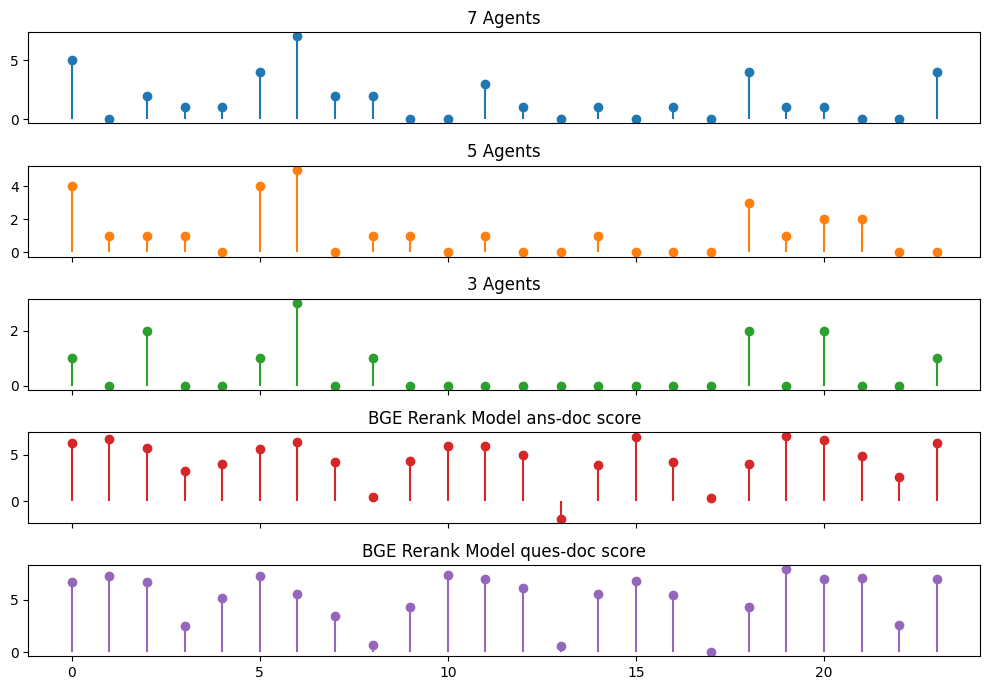

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# array1 = np.array([6, 0, 5, 0, 0, 0, 0, 0, 3, 4, 2, 2, 2, 3, 4, 7, 1, 0, 0, 2, 0, 2,])
# array2 = np.array([3, 0, 1, 0, 0, 0, 0, 0, 4, 2, 2, 0, 1, 2, 2, 4, 0, 1, 0, 0, 0, 2,])
# array3 = np.array([1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 2,])

fig, axs = plt.subplots(5, 1, figsize=(10, 7), sharex=True)  # 3 rows, 1 column

axs[0].stem(agent7, basefmt=" ", linefmt='C0-', markerfmt='C0o')
axs[0].set_title('7 Agents')
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

axs[1].stem(agent5, basefmt=" ", linefmt='C1-', markerfmt='C1o')
axs[1].set_title('5 Agents')

axs[2].stem(agent3, basefmt=" ", linefmt='C2-', markerfmt='C2o')
axs[2].set_title('3 Agents')

axs[3].stem(np.array(rerank_scores1), basefmt=" ", linefmt='C3-', markerfmt='C3o')
axs[3].set_title('BGE Rerank Model ans-doc score')

axs[4].stem(np.array(rerank_scores2)-np.min(rerank_scores2), basefmt=" ", linefmt='C4-', markerfmt='C4o')
axs[4].set_title('BGE Rerank Model ques-doc score')

plt.tight_layout()
plt.savefig('3-5-7-agents decision.svg')
plt.show()


如上图，index=1,3经检查，虽然语义相似度很高，但对于对话改善的价值确实不大，index=9虽然语义相似度很低，但确实有参考意义

In [ ]:
print(questions[0])
print(answers[0][0])

小朋友们，大家想过没有，鲁滨逊在荒岛上生活了将近二十八年，他的故事告诉我们了什么重要的道理呢？我们是不是可以从他的经历中学到一些特别的东西，比如面对困难时如何保持勇敢和乐观呢？
鲁滨逊的故事告诉我们，不管遇到多大的困难，都不要放弃。他在荒岛上生活了那么久，一直都很勇敢，也很聪明，学会了很多生存的技能。这个故事让我觉得，只要我们勇敢面对问题，用心去解决，就没有什么是过不去的。我们也要学会像鲁滨逊那样，即使在很困难的情况下，也要保持乐观，相信总有一天会有好的结果。这样的态度很重要，可以帮助我们克服生活中的挑战。



In [ ]:
print(2, list(reranked_results.keys())[2])
print(8, list(reranked_results.keys())[8])
print(9, list(reranked_results.keys())[9])
print(10, list(reranked_results.keys())[10])
print(23, list(reranked_results.keys())[23])

2 本书通过描绘鲁滨逊在孤岛上的冒险求生经历，赞扬了他作为新兴资产阶级封建贵族代表所具备的敢于冒险、勇于开拓、追求自由、自主坚毅的时代精神。鲁滨逊精神及美好品质，在如今疫情背景下的新经济时代依然具备现实意义。现在的青少年普遍敏感脆弱，比较容易被繁重的学业或生活中的困难所压倒，导致意志消沉。鲁滨逊则在一定程度上给青少年树立了榜样，增强了他们成长路上的精神力量：只有经历磨难克服苦难才会变强大。文学经典不
8 服困难的意志品质。所以，在学校中应重视学生学习意志的培养：从实际出发，帮助学生确立符合个人的情况的学习目的；在平时不断的鼓励学生克服困难，逐步建立学生的学习意志；[1]①强调自我的努力，这是培养学习意志坚强的人的基本途径。此外，学校领导、教师要致力于建设良好的校风、学风、鼓励学生向学习努力的同学看齐，抵制不良环境的影响。
9 基于上述理解，我给《鲁滨逊漂流记》设定的教学目标是：
1.理解“冒险”对于个体生命与人类生存的意义；2.理解“理性精神”在人类生存与发展中的价值；3.理解“反思”在构建生命意义中的作用。
二、教学策略：基于问题解决的思辨读写。
10 怕困难呀，坚强勇敢呀，是的，这都是我们对他的整体的印象。那么在下节课我们要继续的深入了解鲁滨逊的内心，体会他在荒岛上的境遇和心情，更深刻的去认识主人公鲁滨逊是怎样的人。我们下节课继续学习，再见。
23 在《鲁滨逊漂流记》中，鲁滨逊勇于冒险、沉着镇定、乐观积极、自强不息的精神体现在他在荒岛上克服困难的各种表现中。教师可以引导学生罗列并整理鲁滨逊所面临的生存、生活、生命意义等方面的困难，通过梳理鲁滨逊克服困难的种种办法，初步体会鲁滨逊所言所行表现出来的精神品质。然而在强大的动手能力、积极乐观、坚持不懈等众多支撑鲁滨逊成功求生的品质要素中，尤为重要的一项便是他的理性精神。书中鲁滨逊曾说“推理乃是数学


Text(0, 0.5, 'Sampling Frequency')

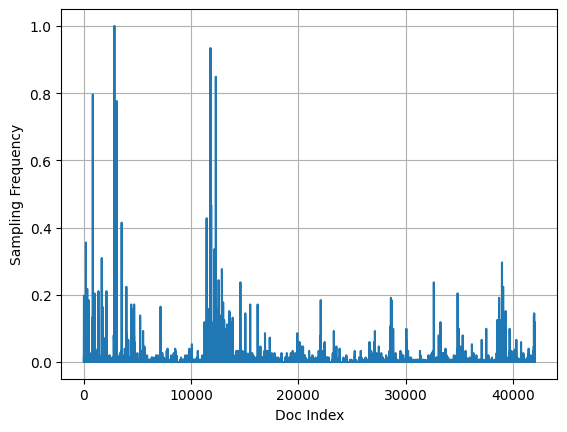

In [ ]:
plt.plot(HS_V)
plt.grid()
plt.xlabel('Doc Index')
plt.ylabel('Sampling Frequency')

# 给定`question`和`answer`，根据`HS_V`进行检索，生成`response`。

In [ ]:
# HS_V = labels_cumulative_collective.sum(0).sum(0)
HS_V = np.ones((42041))
responses = []
for i, (question, answer) in enumerate(zip(questions[349:], answers[349:])):
    reranked_results = rewritings_rrf(
        query=answer[0],
        HS_V=HS_V,
        model_name='glm-4',
        )
    
    response = glm4_client.chat.completions.create(
        model='glm-4', # gpt-4-turbo-preview
        messages=[
            {"role": "system", "content": teacher_sys},
            {"role": "user", "content": teacher_response_prompt.format(
                question=question,
                answer=answer[0],
                reference=list(reranked_results.keys())[:5])},
            ]
        )
    print(i+349, response.choices[0].message.content)
    responses.append(response.choices[0].message.content)

349 哇，你的故事听起来好有趣啊！让两个神在一个充满神奇的小岛上相遇，这个点子太棒了。他们变成好朋友，一起用神力创造奇妙的事物，这一定会让故事变得十分精彩。你提到了会下雨糖果的小岛，还有能飞上天的房子，这些都是非常棒的创意。你的故事不仅充满了想象，还包含了探索未知世界的勇气和友谊的重要性。继续保持你的想象力，将来你一定能成为一个优秀的故事创造者呢！而且，通过对不同文化的了解，比如霍比特人、尼安德特人和纳莱迪人，你的故事会更加丰富多彩。加油哦，期待你创作出更多好玩的故事！
350 哇，你这个想法真的很有创意哦！“梦想传递者”这个称呼真美好，他们就像是人们的梦想守护者一样。你说的这种光环魔法，感觉好神奇，让人人都能够梦想成真，这真是一种非常温暖和积极的力量呢！而且你还想到了教大家画地图，这就像是给每个人的梦想之旅指引方向，帮助他们找到实现梦想的道路。你的想法不仅有趣，而且充满了智慧和爱心，真棒！继续保持这样丰富的想象力和创造力，你一定能够成为一个伟大的故事创造者，或者将来真的能够创造出一个让人人都充满希望和梦想的世界呢！
351 你回答得真棒！鲁宾逊和星期五的这段对话确实很重要。在荒岛上，他们不仅是主人与仆人的关系，更是彼此的朋友。你提到了他们谈论如何成为一个好朋友，这正是因为在困难的时候，朋友的支持和陪伴显得尤为珍贵。就像你说的，有了朋友，我们就不会感到孤单，可以互相帮助，一起面对挑战。通过他们的故事，我们明白了在生活和学习中，建立良好的人际关系和友谊是多么重要的事情。你从这个故事中学到了很多，真是个爱思考的好孩子！
352 哇，你说的很有道理哦！鲁宾逊在荒岛上经历了许多好的事情，比如上帝给予他的帮助，这让他在心里种下了对上帝的信仰。而你提到的乐高例子也用得很形象，确实，如果我们只愿意看到好的一面，就很难理解为什么有人会做出不好的事情来。这就像是鲁宾逊对魔鬼的理解，因为他没有亲身经历过那些不好的事情，所以理解起来就有难度。

但你知道吗，其实鲁宾逊这个角色很复杂哦。他在岛上的时候，有时候很勇敢，有时候又很自私。他跟上帝的关系，也像是你说的，是一种很实际的关系。当他遇到困难时，他就求上帝帮忙；当一切顺利时，他可能就不会那么想了。这跟我们现实生活中，对待别人的态度有时候也很相似呢。

我们通过阅读鲁宾逊的故事，可以学会用辩证的思维方式去看待一个人，不仅仅只看表面，还要看

# Group-evaluation

### 导入response

In [ ]:
import re
with open('response1.1.txt', 'r', encoding='utf-8') as f:
    raw = f.readlines()
    raw = ''.join(raw)
responses = re.split(r'\d+ ', raw)[1:]
print('number of responses:', len(responses))

number of responses: 499


In [ ]:
for i, (question, answer, response) in enumerate(zip(questions, answers, responses)):
    # score = qwen_client.completion(
    #     prompt=eva_exp_prompt.format(
    #         teaching_record='Question: {}\nAnswer: {}\nResponse: {}'
    #        .format(question, answer, response)
    #     ),
    #     system_prompt=eva_exp_sys,)
    score = glm4_client.chat.completions.create(
        model='glm-4',
        temperature=0.5,
        messages=[
            {"role": "system", "content": eva_exp_sys},
            {"role": "user", "content": eva_exp_prompt.format(
                teaching_record='Question: {}\nAnswer: {}\nResponse: {}'
           .format(question, answer, response))},
            ],
    )
    score = score.choices[0].message.content
    print(i)
    with open('scores_glm4.txt', 'a') as f:
        f.write('score {}: {}\n'.format(i, score))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
np.save('HS_V', HS_V)
# HS_V = np.load('HS_V.npy')

# Pair-wise Assessment using Multi LLM APIs

In [ ]:
import json
with open('Q_A.json', 'r', encoding='utf-8') as f:
    Q_A = json.load(f)
questions = list(Q_A.keys())

print('导入学生1的回答')
answers = [Q_A[item][0] for item in Q_A] # answers from student #1

# print('导入学生2的回答')
# answers = [Q_A[item][1] for item in Q_A] # answers from student #2

print('number of questions:', len(questions))
print('number of answers:', len(answers))

import re
with open('response1.1.txt', 'r', encoding='utf-8') as f:
    responses_with_HSW = re.split(r'\d+ ', ''.join(f.readlines()))[1:]

with open('response1.1_no_HSW.txt', 'r', encoding='utf-8') as f:
    responses_without_HSW = re.split(r'\d+ ', ''.join(f.readlines()))[1:]
    
print('number of responses:', len(responses_with_HSW), len(responses_without_HSW))

导入学生1的回答
number of questions: 499
number of answers: 499
number of responses: 499 499


### 使用GLM-4 API

In [ ]:
for model in openai_client.models.list().data:
    print(model.id)

gpt-3.5-turbo-16k
gpt-3.5-turbo-16k-0613
whisper-1
davinci-002
gpt-3.5-turbo
dall-e-2
tts-1-hd-1106
tts-1-hd
gpt-4-0613
gpt-4
text-embedding-3-large
gpt-4-1106-vision-preview
gpt-3.5-turbo-instruct-0914
gpt-3.5-turbo-instruct
gpt-3.5-turbo-0301
gpt-3.5-turbo-0613
gpt-4-0125-preview
tts-1
dall-e-3
gpt-4-1106-preview
gpt-3.5-turbo-1106
babbage-002
tts-1-1106
gpt-4-vision-preview
text-embedding-3-small
text-embedding-ada-002
gpt-3.5-turbo-0125
gpt-4-turbo-preview


In [ ]:
for i, (q, a, r1, r2) in enumerate(zip(questions, answers, responses_with_HSW, responses_without_HSW)):
    # messages = [
    #     {'role': 'system', 'content': 'You are a helpful assistant.'},
    #     {'role': 'user', 'content': pair_eval_prompt.format(Question=q, Answer=a, Response_1=r1, Response_2=r2)},
    #     ]
    # openai_client
    response = openai_client.chat.completions.create(
        model='gpt-4-turbo-preview', # glm-3-turbo gpt-4-turbo-preview glm-4 gpt-3.5-turbo-0125
        messages=[
            {'role': 'system', 'content': 'You are a helpful assistant.'},
            {"role": "user", "content": pair_eval_prompt.format(Question=q, Answer=a, Response_1=r2, Response_2=r1)}
            ],
        temperature=0.9,
        )
    print(i, response.choices[0].message.content)
    if i == 99:
        break

0 Response 2
1 Response 2
2 Response 2
3 Response 2
4 Response 2
5 Response 2
6 Response 1
7 Response 2
8 Response 2
9 Response 2
10 Response 1
11 Response 1
12 Response 1
13 Response 1
14 Response 2
15 Response 2
16 Response 2
17 Response 1
18 Response 2
19 Response 2
20 Response 1
21 Response 2
22 Response 2
23 Response 2
24 Response 1
25 Response 2
26 Response 2
27 Response 2
28 Response 1
29 Response 1
30 Response 2
31 Response 2
32 Response 1
33 Response 1
34 Response 2
35 Response 1
36 Response 2
37 Response 2
38 Response 2
39 Response 2
40 Response 1
41 Response 2
42 Response 2
43 Response 2
44 Response 2
45 Response 1
46 Response 1
47 Response 1
48 Response 2
49 Response 2
50 Response 2
51 Response 1
52 Response 2
53 Response 2
54 Response 2
55 Response 1
56 Response 2
57 Response 2
58 Response 2
59 Response 1
60 Response 1
61 Response 1
62 Response 1
63 Response 1
64 Response 2
65 Response 2
66 Response 1
67 Response 1
68 Response 1
69 Response 1
70 Response 1
71 Response 2
72

### 使用Qwen API

In [ ]:
for i, (q, a, r1, r2) in enumerate(zip(questions, answers, responses_with_HSW, responses_without_HSW)):
    messages = [
        {'role': 'system', 'content': 'You are a helpful assistant.'},
        {'role': 'user', 'content': pair_eval_prompt.format(Question=q, Answer=a, Response_1=r2, Response_2=r1)},
        ]
    response = qwen_client(messages=messages)
    print(i, response['output'].choices[0].message['content'])

0 Response 2
1 Response 1
2 Response 1
3 Response 1
4 Response 1
5 Response 2
6 Response 1
7 Response 2
8 Response 2
9 Response 2
10 Response 2
11 Response 2
12 Response 1
13 Response 1
14 Response 1
15 Response 1
16 Response 1
17 Response 1
18 Response 1
19 Response 2
20 Response 1
21 Response 1
22 Response 2
23 Response 2
24 Response 1
25 Response 2
26 Response 2
27 Response 2
28 Response 2
29 Response 2
30 Response 2
31 Response 2
32 Response 1
33 Response 1
34 Response 1
35 Response 2
36 Response 1
37 Response 2
38 Response 1
39 Response 2
40 Response 1
41 Response 2
42 Response 2
43 Response 1
44 Response 2
45 Response 1
46 Response 2
47 Response 1
48 Response 1
49 Response 2
50 Response 2
51 Response 2
52 Response 1
53 Response 2
54 Response 2
55 Response 1
56 Response 1
57 Response 2
58 Response 1
59 Response 1
60 Response 2
61 Response 2
62 Response 1
63 Response 2
64 Response 2
65 Response 2
66 Response 2
67 Response 1
68 Response 1
69 Response 2
70 Response 1
71 Response 2
72

In [ ]:
response = glm4_client.chat.completions.create(
    model='glm-4', #  'gpt-4-turbo-preview'
    messages=[
        {"role": "system", "content": teacher_sys},
        {"role": "user", "content": teacher_response_prompt.format(question=question, answer=answers[0])},
        {"role": "user", "content": f"OUTPUT ({config.fusion_k} queries):"}
        ]
    )
generated_queries = response.choices[0].message.content.strip().split("\n") # response.choices[0]["message"]["content"].strip().split("\n")
generated_queries.append(answers[0])

In [ ]:
all_results = {}
for query in generated_queries:
    search_results = vector_search(
        db,
        query, 
        filter=None, # {'role': 'teacher-record'}, {'time': '2023.9'}
        retrieval_k=config.retrieval_k,
        )
    all_results[query] = search_results
#### 注意:
#### all_results中的检索文档可能有重复，即多个Query检索到了同一篇文档，因此reranked_results中的文档数量可能少于all_results中的文档数量
reranked_results = reciprocal_rank_fusion(
    search_results_dict=all_results, 
    HS_vector=HS_V, 
    verbose=False,
    )
print('number of retrieved documents:', len(reranked_results))

In [ ]:
reranked_results_wo_weight = reciprocal_rank_fusion(all_results, HS_vector=np.ones_like(HS_V), verbose=False)

In [ ]:
for result in reranked_results_wo_weight.keys():
    score = rerank_func.compute_score([answers[0], result])
    print(score)